### ■ 유통 판매량 예측 및 재고 최적화
# 단계 1: 가설 도출과 데이터 탐색

<img src = "https://github.com/Jangrae/img/blob/master/store.png?raw=true" width=800, align="left"/>

# 수행 과제

다음과 같은 과정으로 프로젝트를 진행합니다.

#### 1. 환경 설정
- 이후 진행에 필요한 환경 설정을 수행합니다.

#### 2. 데이터 탐색
- 대상 데이터에 대해 충분히 탐색합니다.
- 특히 시계열 패턴을 찾기 위한 다양한 시각화를 수행합니다.
- 탐색 결과를 기반으로 이후에 새로운 변수를 추가하게 됩니다.

#### 참고: 함수 만들어 사용
- 여러 상품을 탐색하므로 같은 코드를 반복해서 사용하게 됩니다.
- 함수를 만들어 사용하면 좀더 효율적인 탐색이 가능합니다.

#### 참고: 대상 상품(핵심 상품)

| product_id|product_code|subcategory|category|leadtime|price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Food|2|6|
|7|HC001|Cleaning|Household|2|15|
|12|GA001|Milk|Food|2|6|

# 1. 환경 설정

- 이후 진행에 필요한 환경 설정을 수행합니다.

## (1) 경로 설정

- 프로젝트 수행 환경에 맞게 파일 경로를 설정합니다.

### 1) 로컬 수행(Anaconda)
- project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [8]:
# 기본 경로
path = ''

### 2) 구글 콜랩 수행

- 구글 콜랩을 사용중이면 구글 드라이브를 연결합니다.

In [10]:
# # 구글 드라이브 연결, 패스 지정
# import sys
# if 'google.colab' in sys.modules:
#     from google.colab import drive
#     drive.mount('/content/drive')
#     path = '/content/drive/MyDrive/project/'

## (2) 라이브러리 불러오기

- 이후 사용할 기본 라이브러리를 불러옵니다.

In [12]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

- 시각화에 사용할 폰트 크기를 설정합니다.

In [14]:
# 시각화 폰트 사이즈 설정
plt.rc('font', size=7)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', linewidth=0.3) 

## (3) 데이터 불러오기

- 이후 분석 대상이 되는 파일을 불러오고 기본 정보를 확인합니다.

### 1) 데이터 불러오기

- 분석 대상인 학습용 데이터를 불러옵니다.
- 데이터프레임 이름은 다음과 같이 통일합니다.
    - sales: 판매 정보
    - orders: 고객 방문수
    - oil_price: 휘발유 가격
    - stores: 매장 정보
    - products: 상품 정보
- 날짜 데이터를 갖는 date 변수는 이후 편의를 위해 datetime 형으로 변환합니다.

In [17]:
# 데이터 불러오기
sales = pd.read_csv(path + 'sales_train.csv')
orders = pd.read_csv(path + 'orders_train.csv')
oil_price = pd.read_csv(path + 'oil_price_train.csv')
stores = pd.read_csv(path + 'stores.csv')
products = pd.read_csv(path + 'products.csv')

In [18]:
# datetime 형으로 변환
sales['date'] = pd.to_datetime(sales['date'] )
oil_price['date'] = pd.to_datetime(oil_price['date'] )
orders['date'] = pd.to_datetime(orders['date'] )

### 2) 기본 정보 확인

- 각 데이터의 기본 정보를 확인합니다.
- date 변수가 있는 데이터의 날짜 범위(최솟값, 최댓값)를 확인합니다.

In [168]:
sales.head() # 2014-01-02 00:00:00 ~ 2017-02-28 00:00:00	

date  store_id       qty  product_id
0 2014-01-02         1  2524.000           3
1 2014-01-02         1   388.988           5
2 2014-01-02         1   852.000           7
3 2014-01-02         1   772.000           8
4 2014-01-02         1   195.000          10

In [170]:
orders.head() # 2014-01-02 00:00:00 ~ 2017-02-28 00:00:00

date  store_id  count
0 2014-01-02         1   1875
1 2014-01-02         2   2122
2 2014-01-02         3   3350
3 2014-01-02         4   1661
4 2014-01-02         5   1807

In [172]:
oil_price.head() # 2014-01-02 00:00:00 ~ 2017-02-28 00:00:00	


date  wti_price
0 2014-01-02      95.14
1 2014-01-03      93.66
2 2014-01-06      93.12
3 2014-01-07      93.31
4 2014-01-08      91.90

In [174]:
stores.head() # date 시계열 정보는 없음 대신 매장 정보를 알 수 있음

# target 매장 id: 44        도시:Saint Paul     주: Minnesota       store_ type:1  

store_id           city      state  store_type
0         1     Saint Paul  Minnesota           4
1         2     Saint Paul  Minnesota           4
2         3     Saint Paul  Minnesota           4
3         4     Saint Paul  Minnesota           4
4         5  Oklahoma City   Oklahoma           4

In [176]:
products.head() # 상품 정보 ,   

# target   (서브 카테고리를 기준으로 분석해볼까? )
# product_id  product_code  subcategory      category         leadtime  price
# 3           DB001         Beverage         Drink            2         8
# 7           HC001         Cleaning         Household Goods  2         15
# 12          GA001         Milk             Food             2         6

# (추가)
# 27          HH001         Home Appliances  Household Goods  2         150  (가전제품 )

product_id product_code      subcategory         category  leadtime  price
0          20        HG001  Gardening Tools  Household Goods         2     50
1          27        HH001  Home Appliances  Household Goods         2    150
2          16        HK001          Kitchen  Household Goods         2     23
3          15        HK002          Kitchen  Household Goods         2     41
4          32        GS001          Seafood          Grocery         3     34

# 2. 데이터 탐색

- 대상 데이터에 대해 충분히 탐색합니다.
- 특히 시계열 패턴을 찾기 위한 다양한 시각화를 수행합니다.
- 탐색 결과를 기반으로 이후에 새로운 변수를 추가하게 됩니다.

## (1) 기본 데이터 탐색

- 개별 데이터에 대한 충분한 탐색을 수행합니다.
- 다음과 같은 탐색이 포함될 수 있습니다.
    - 각 데이터 결측치 존재 여부 확인
    - 각 데이터에 포함된 범줏값 비율 확인
    - 각 데이터에 포함된 연속값 범위와 분포 확인
    - 기타 등등...

### 1) 결측치 확인

- 데이터로 결측치 존재 여부를 확인합니다.

In [28]:
sales.isna().sum()

date          0
store_id      0
qty           0
product_id    0
dtype: int64

In [29]:
orders.isna().sum()

date        0
store_id    0
count       0
dtype: int64

In [30]:
oil_price.isna().sum() # oil_price 에 결측치가 있음

date          0
wti_price    27
dtype: int64

In [31]:
stores.isna().sum() 

store_id      0
city          0
state         0
store_type    0
dtype: int64

In [32]:
products.isna().sum()

product_id      0
product_code    0
subcategory     0
category        0
leadtime        0
price           0
dtype: int64

### 2) 범줏값 비율 확인

- 중요 범줏값의 비율을 확인합니다.

In [34]:
sales['product_id'].value_counts() # 기간동안 판매량은 종류별로 전부 고르게 분포함

product_id
3     61992
5     61992
7     61992
8     61992
10    61992
11    61992
12    61992
15    61992
16    61992
20    61992
24    61992
27    61992
29    61992
32    61992
38    61992
Name: count, dtype: int64

In [35]:
orders

date  store_id  count
0     2014-01-02         1   1875
1     2014-01-02         2   2122
2     2014-01-02         3   3350
3     2014-01-02         4   1661
4     2014-01-02         5   1807
...          ...       ...    ...
57549 2017-02-28        49   3183
57550 2017-02-28        50   2651
57551 2017-02-28        51   1545
57552 2017-02-28        53   1141
57553 2017-02-28        54    729

[57554 rows x 3 columns]

## (2) 판매량, 고객 방문수

- 시각화를 통해 상품별 판매량, 고객 방문수 등을 월별로 살펴봅니다.
- 대상 매장(44), 대상 상품(3, 7, 12)에 대해서 살펴봅니다.
- 다음과 같은 시각화가 포함될 수 있습니다.
    - 3년간(2014년~2016년)상품별 월별 판매량
    - 2016년 상품별 월별 판매량
    - 3년간(2014년~2016년) 월별 고객 방문수
    - 2016년 월별 고객 방문수
    - 기타 등등...

### 1) 상품별 월별 판매 수량

- 상품의 기간별 판매량을 확인합니다.
- 지정한 매장, 지정한 상품, 지정한 기간의 월별 판매량을 시각화해 확인하는 함수를 만듭니다.
- 함수 이름: monthly_sales_qty
- 입력: 매장번호(store_id), 상품번호(product_id), 시작일(sdate), 종료일(edate)

In [38]:
# 함수 만들기
def monthly_sales_qty(store_id, product_id, sdate, edate):
    temp = sales.loc[(sales['store_id']==store_id) & (sales['product_id']==product_id) & (sales['date'].between(sdate, edate))]
    # 매장, 상품번호 , 기간 동안 월별 판매량을 시각화 
    temp['month'] = temp['date'].dt.month
    monthly = temp.groupby(by='month', as_index=False)[['qty']].sum()

    # 추가한 내용
    title = products.loc[(products['product_id']==product_id)]['subcategory'].values[0]
    
    plt.figure(figsize=(12, 3))
    plt.bar(x=monthly['month'], height=monthly['qty'] / 1000)
    # 추가한 내용
    plt.title(f'{title} Qty per Month')
    
    plt.xlabel('Month')
    plt.ylabel('Qty(Thousand)')
    plt.xticks(range(1, 13), range(1, 13))
    plt.show()

- 위 함수를 사용해 주요 상품의 3년간(2014년 ~ 2016년) 월별 판매량을 확인합니다.

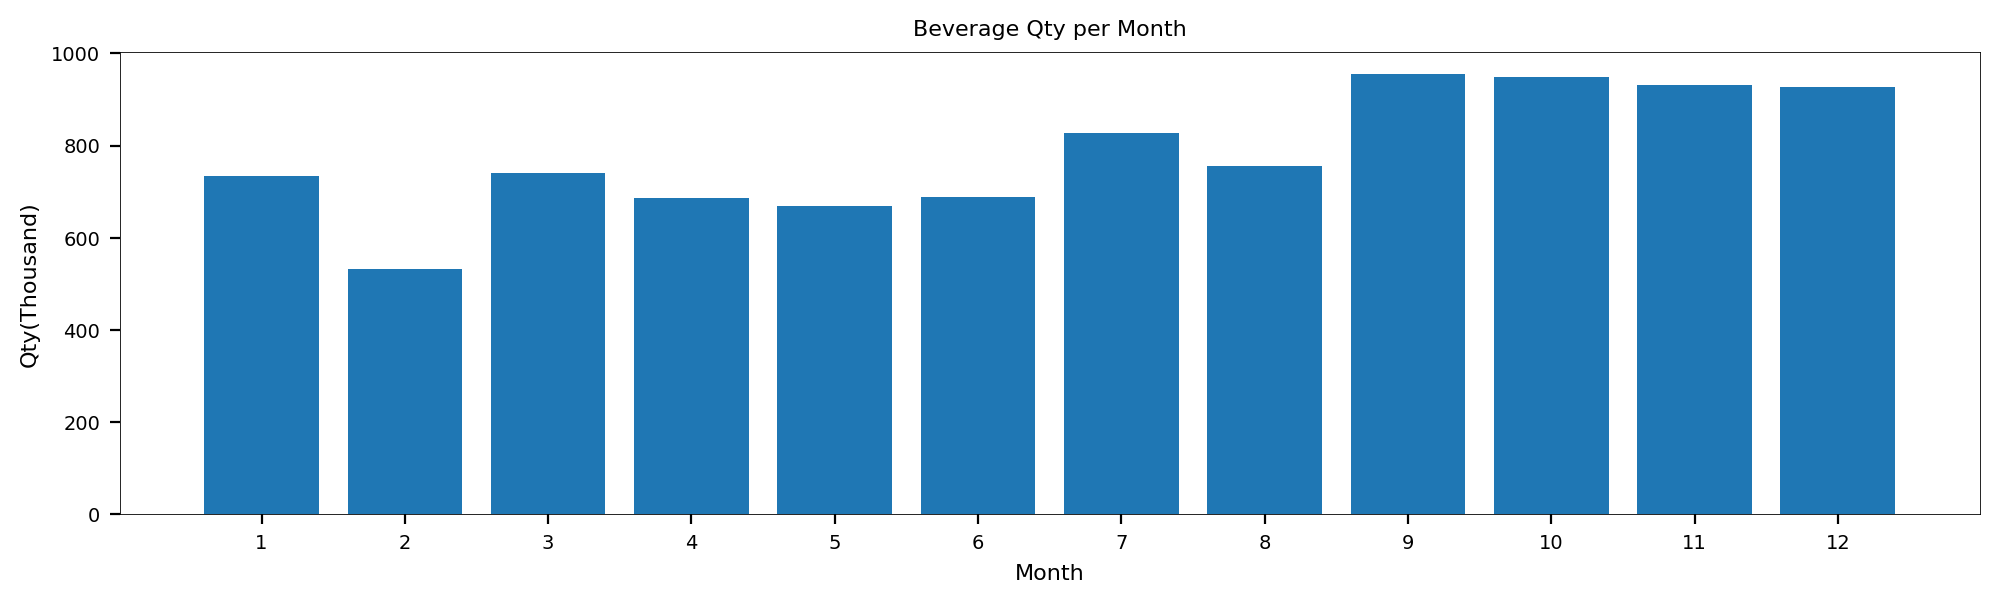

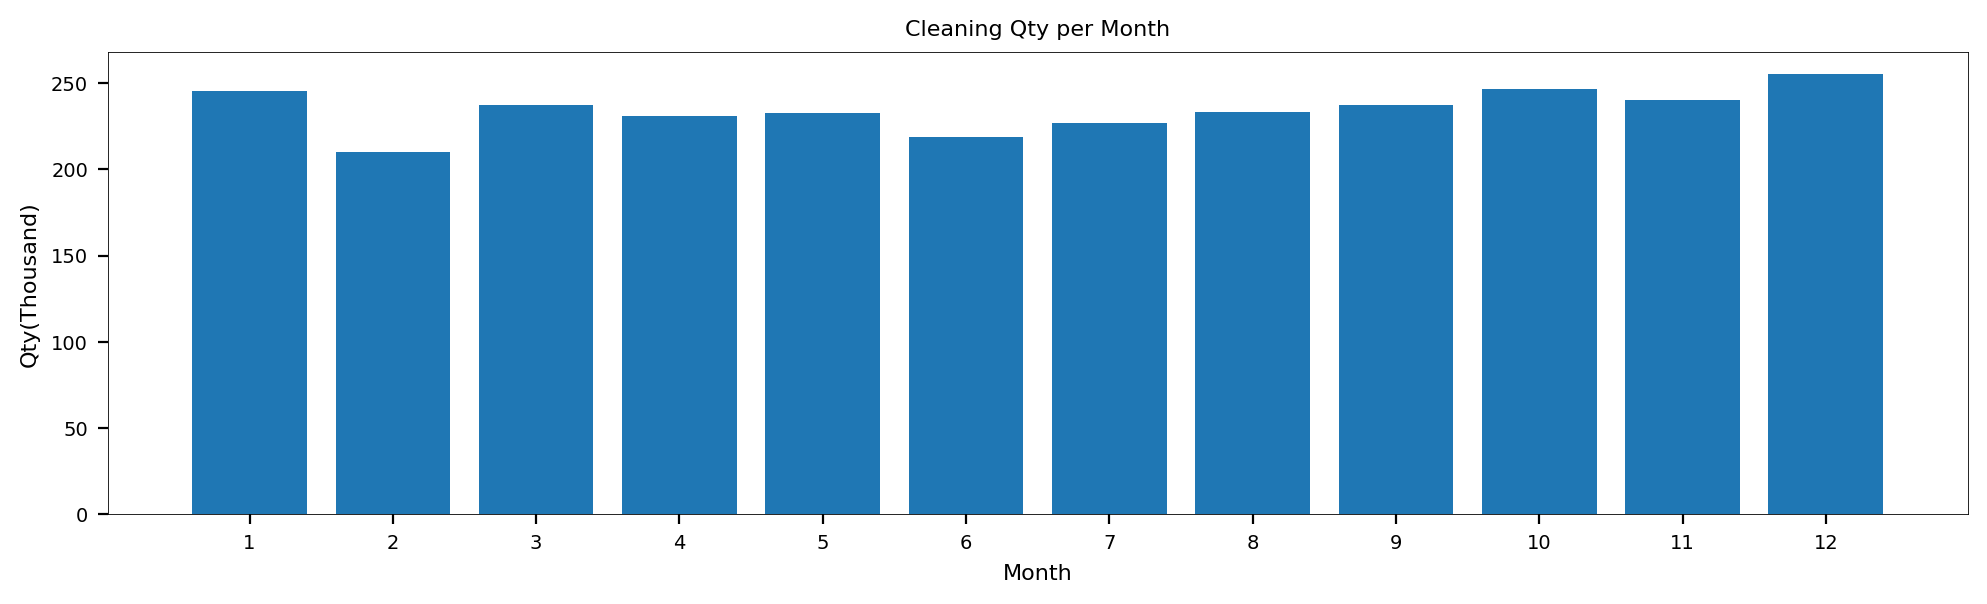

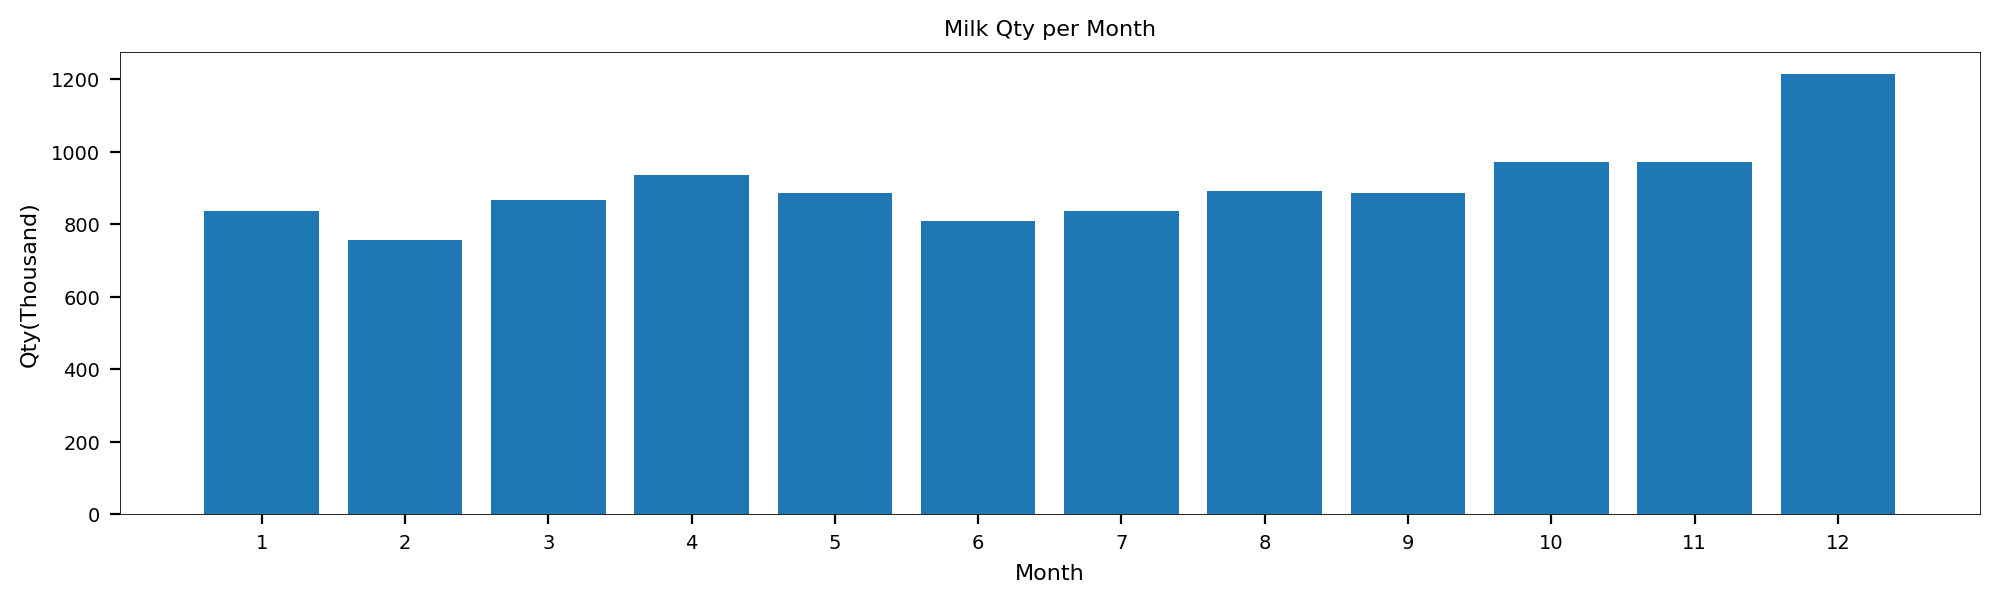

In [40]:
# 상품별 2014년~2016년 월별 판매량
main_product = [3, 7, 12]  # 
for p in main_product:
    monthly_sales_qty(44, p, '2014-01-01', '2016-12-31')

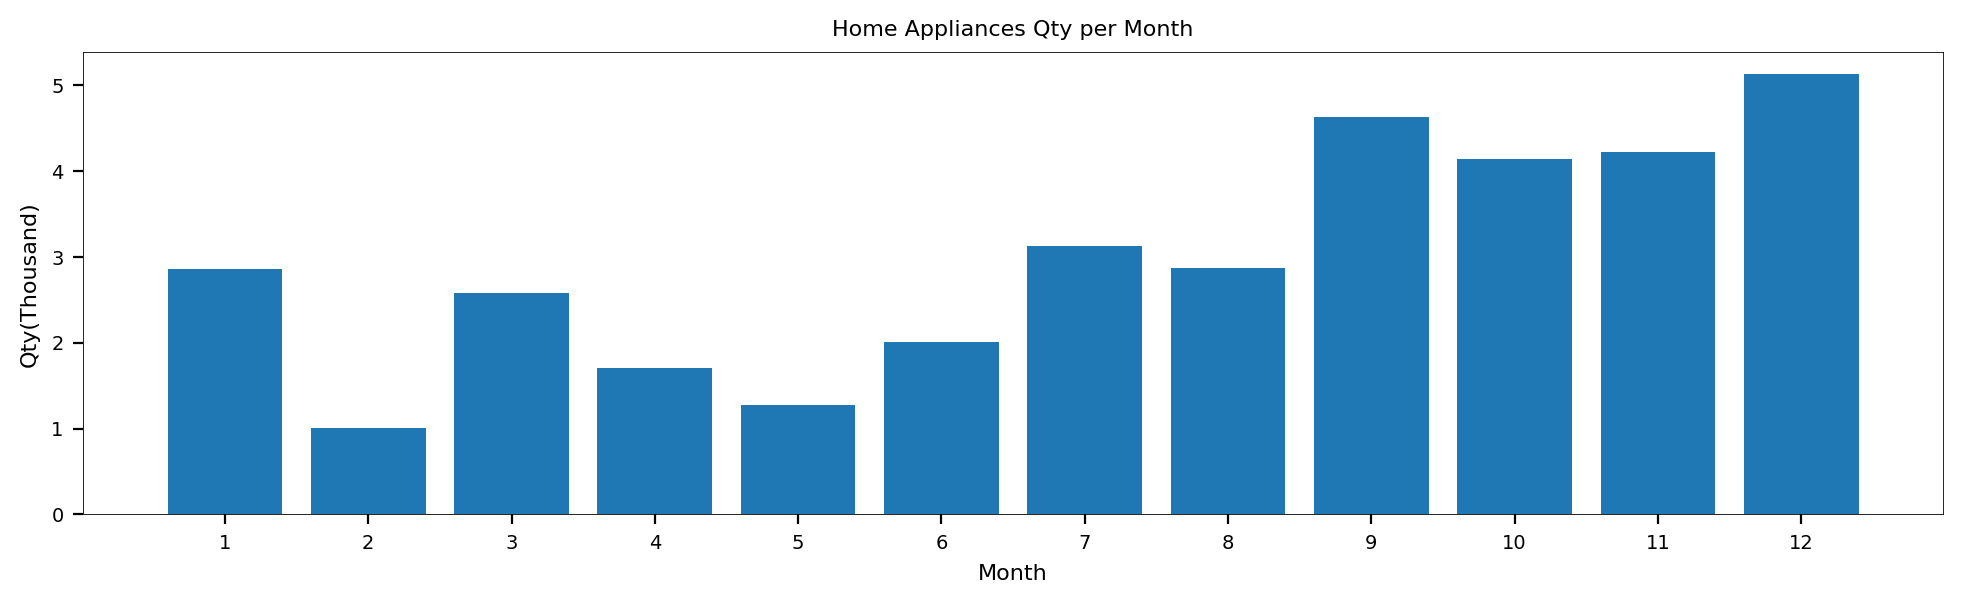

In [41]:
# (추가 학습)
monthly_sales_qty(44, 27, '2014-01-01', '2016-12-31')# 27은 가전제품

- 위 함수를 사용해 주요 상품의 1년간(2016년) 월별 판매량을 확인합니다.

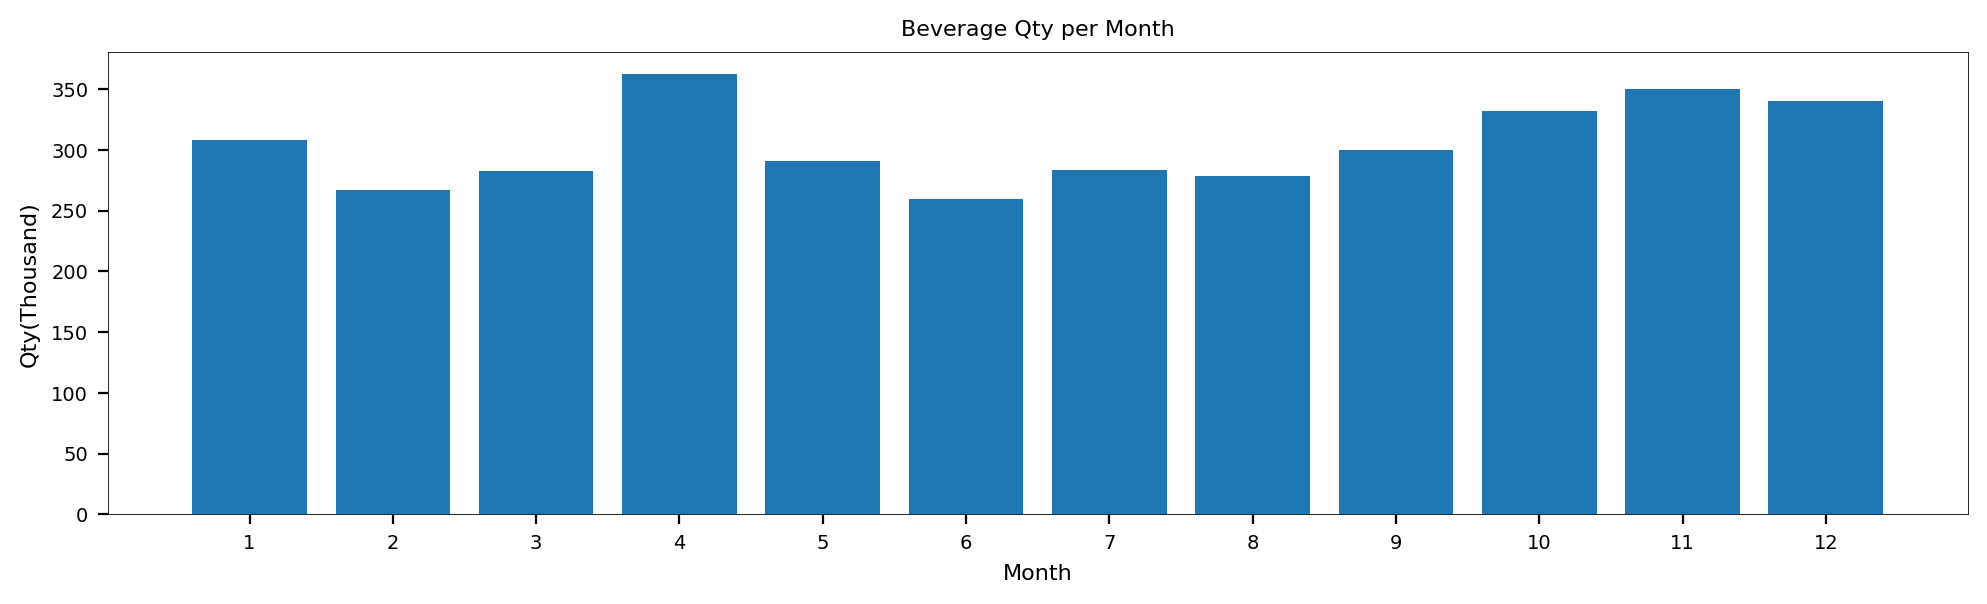

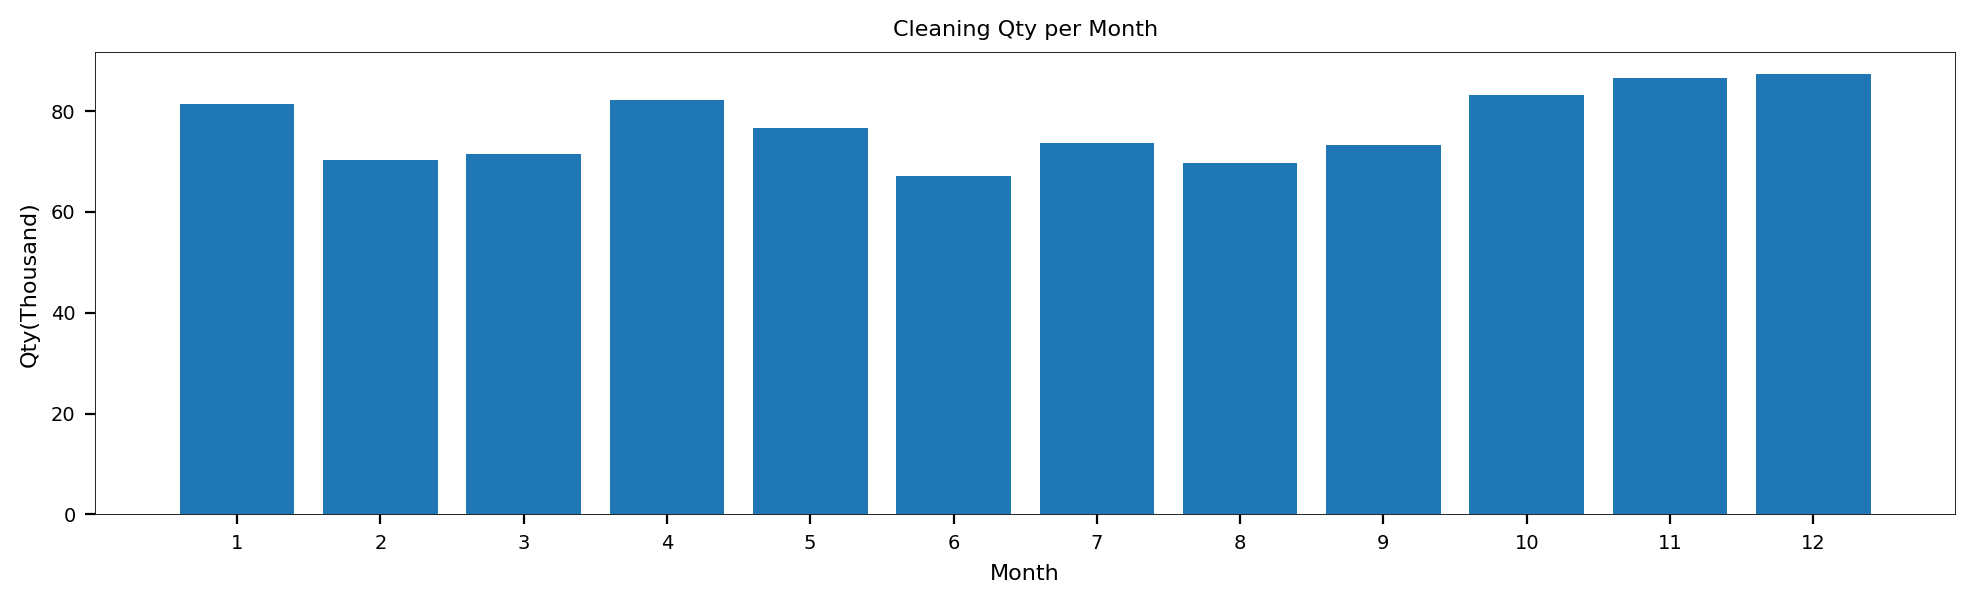

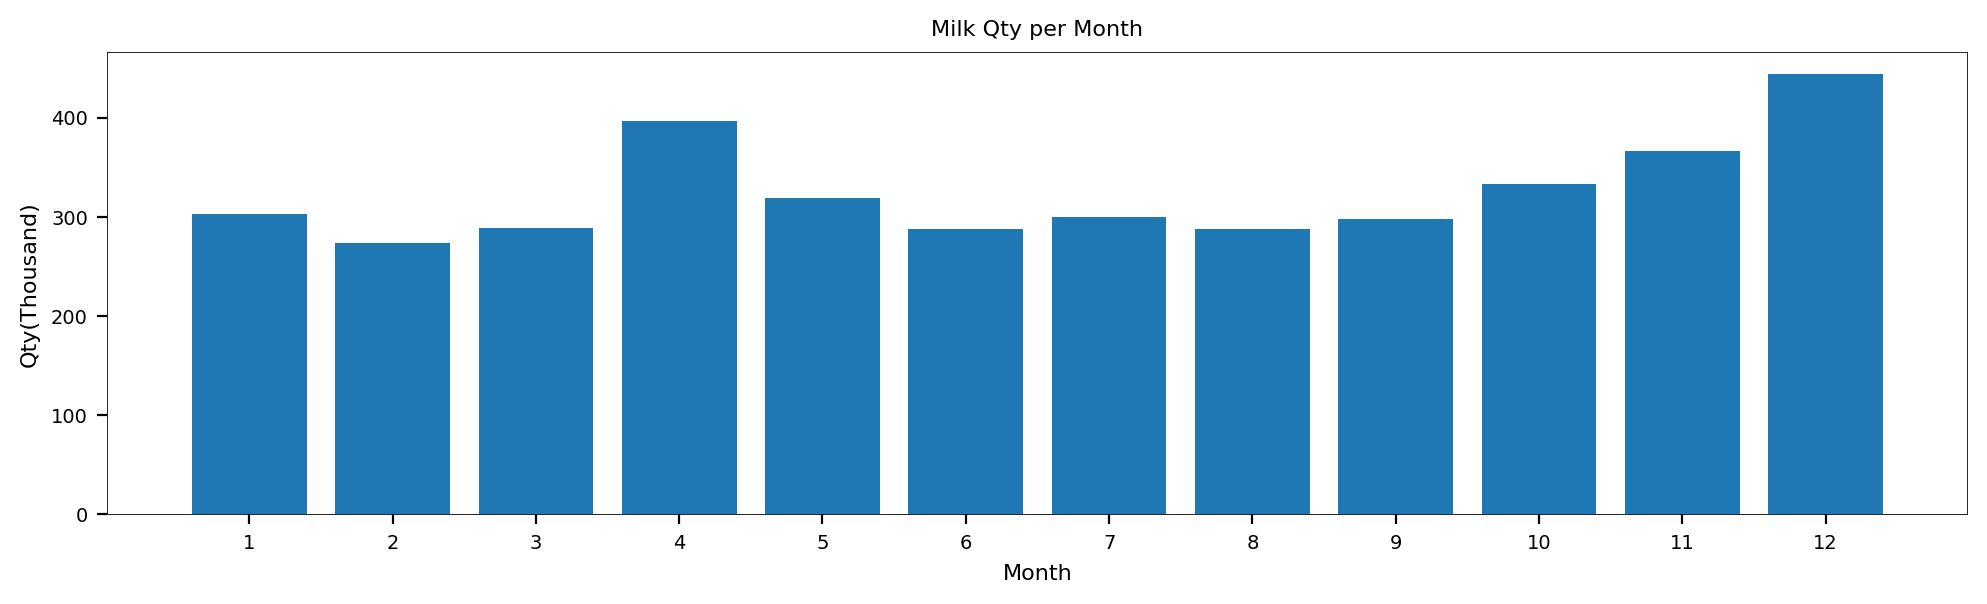

In [43]:
# 상품별 2016년 월별 판매량
main_product = [3, 7, 12]
for p in main_product:
    monthly_sales_qty(44, p, '2016-01-01', '2016-12-31')

### 2) 월별 고객 방문수

- 월별 고객 방문수를 확인합니다.
- 지정한 매장, 지정한 기간의 월별 고객 방문수를 시각화해 확인하는 함수를 만듭니다.
- 함수 이름: monthly_customer_visits
- 입력: 매장번호(store_id), 시작일(sdate), 종료일(edate)

In [45]:
# 일별 매장별 고객 갱문 수는 orders 데이터에 저장되어있음 orders[count] 
def monthly_customer_visits(store_id , sdate, edate):
    temp = orders.loc[(orders['store_id']==store_id)& (orders['date'].between(sdate,edate))]
    temp['month'] = temp['date'].dt.month
    monthly = temp.groupby(by='month', as_index=False)['count'].sum() 

    # 그래프 시각화
    plt.figure(figsize=(12, 3))
    plt.title(f'Monthly visit customer Counts at Store:{store_id}')
    plt.bar(x=monthly['month'], height=monthly['count']/1000)
    plt.xlabel('Month')
    plt.ylabel('Qty(Thousand)')
    plt.xticks(range(1, 13), range(1, 13))
    plt.show()
    


- 위 함수를 사용해 3년간(2014년 ~ 2016년) 월별 고객 방문수를 확인합니다.

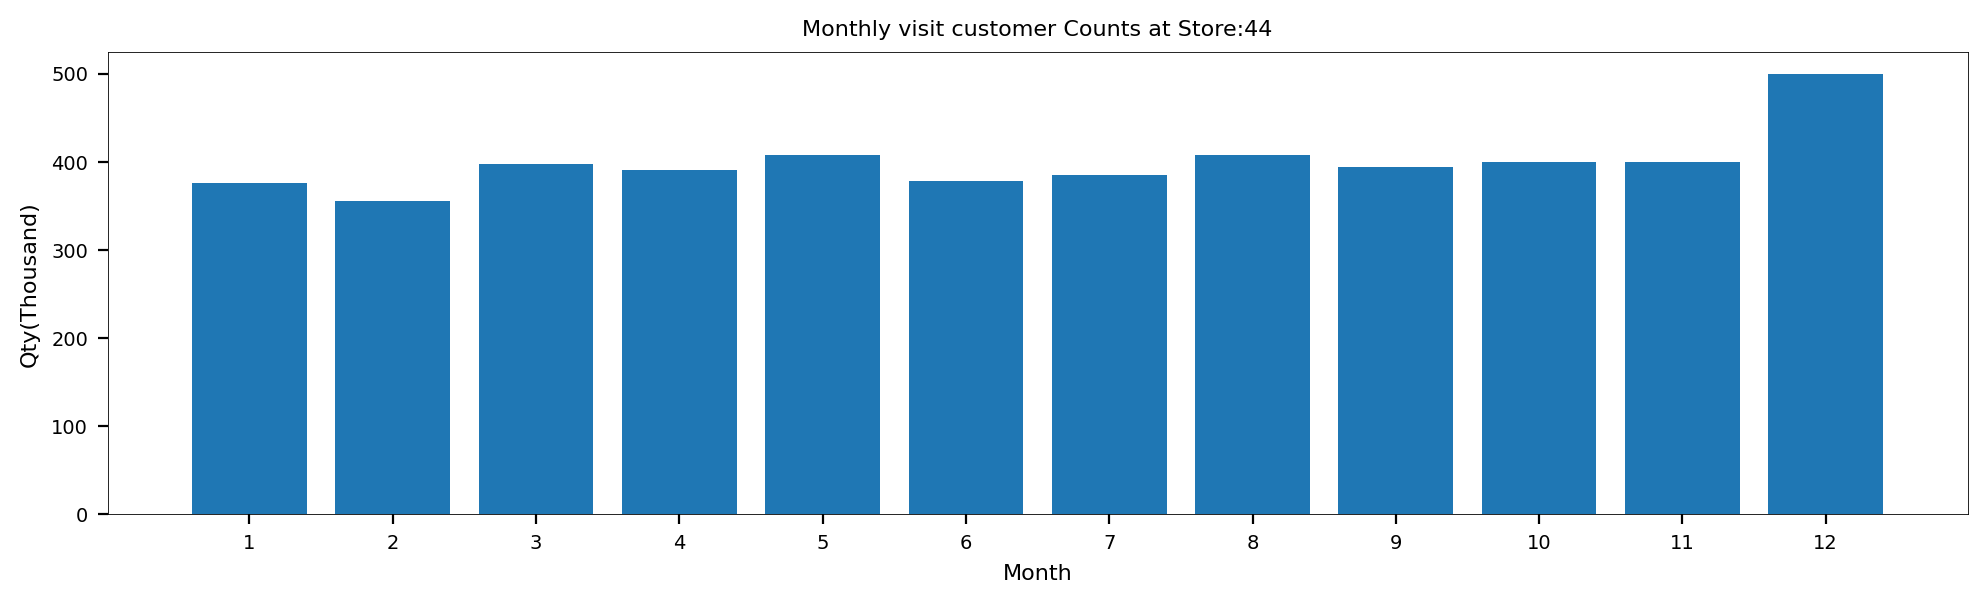

In [47]:
store_id = 44
monthly_customer_visits(store_id,'2014-01-01', '2016-12-31')


- 위 함수를 사용해 1년간(2016년) 월별 고객 방문수를 확인합니다.

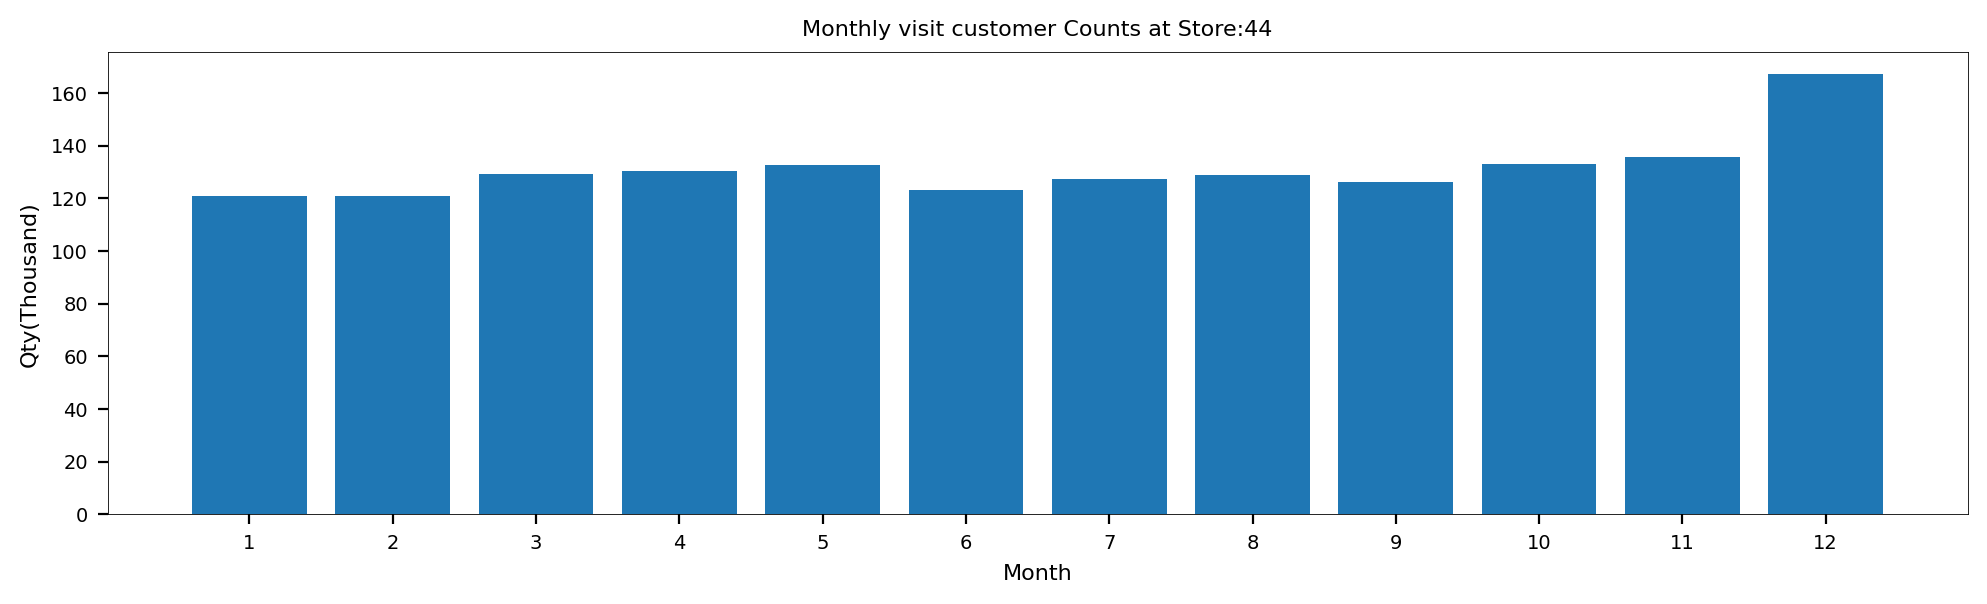

In [49]:
store_id = 44
monthly_customer_visits(store_id,'2016-01-01', '2016-12-31')

# 12월에 항상 방문 고객이 많음 > why? 

## (3) 시계열 패턴 찾아보기 #1

- 판매량을 선그래프로 시각화해 시계열 패턴을 찾아 봅니다.
- 대상 기간을 변경해 가면서 패턴을 확인해 보길 권고합니다.
- 다음과 같은 시각화가 포함될 수 있습니다.
    - 상품별 판매량 추이
    - 방문 고객수와 상품 판매량 추이 비교
    - 휘발류 가격과 상품 판매량 추이 비교
    - 대상 상품과 같은 카테고리의 상품별 판매량 추이
    - 상품별 판매 변화량 비교
    - 요일별 판매량, 판매 변화량 비교
    - 기타 등등...

### 1) 상품별 판매량 추이

- 대상 상품의 판매량 추이를 선그래프로 시각화해 확인합니다.
- 우선 사용할 함수를 만듭니다.
- 이름: product_sales_trend
- 입력: 매장번호(store_id), 상품번호(product_id), 시작일(sdate), 종료일(edate)

In [52]:
# 대상 상품의 판매량은 qty , sales 데이터 프레임에 있음
def product_sales_trend(store_id, product_id, sdate,edate):
    temp = sales.loc[(sales['store_id']==store_id) 
    & (sales['product_id']==product_id)
    & (sales['date'].between(sdate,edate))]

    #대상 상품 분류 
    target = products.loc[products['product_id']==product_id]['subcategory'].values[0]
    # 그래프 시각화 
    plt.plot('date','qty',data=temp,linewidth=0.8)
    
    plt.title(f'{target}\'s qty per date')
    plt.tight_layout()
    plt.show


- 위 함수를 사용해 주요 상품의 3년간(2014년 ~ 2016년) 판매량 추이를 확인합니다.

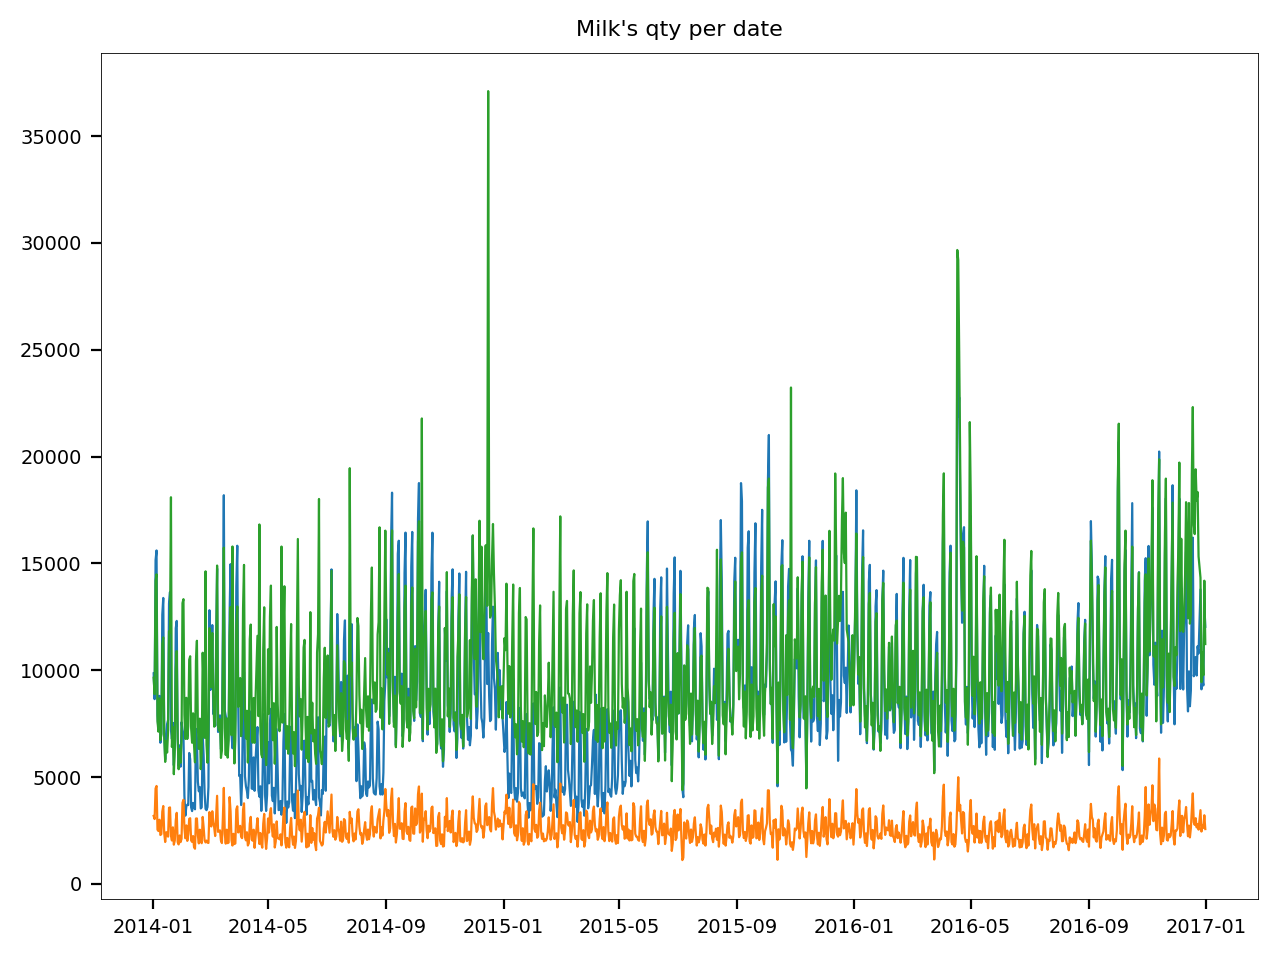

In [54]:
target_store = 44
target_products = [3,7,12]

for t in target_products:
    product_sales_trend(target_store,t,'2014-01-01', '2016-12-31')


- 위 함수를 사용해 주요 상품의 1년간(2016년) 판매량 추이를 확인합니다.

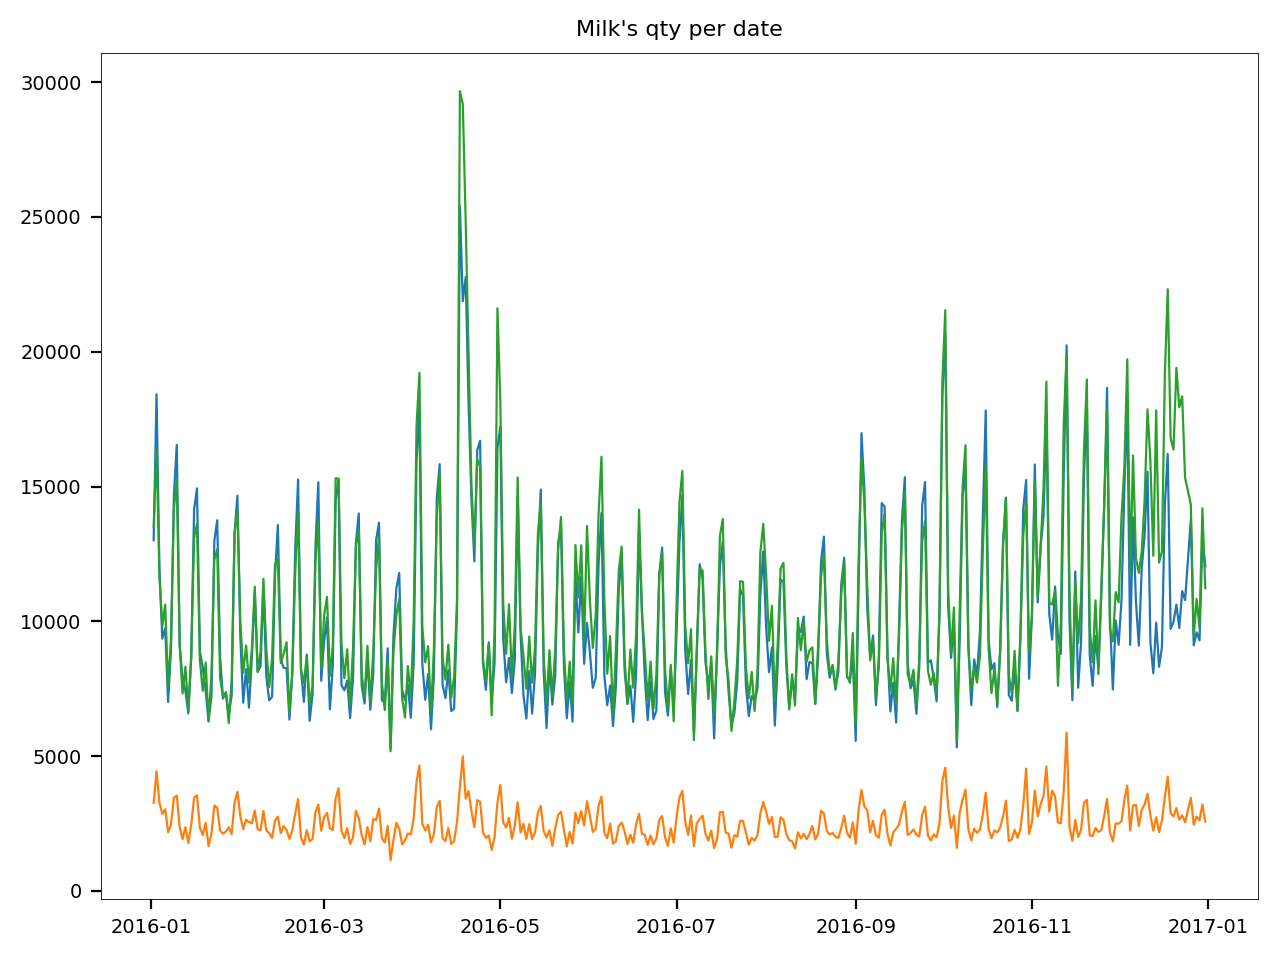

In [56]:
target_store = 44
target_products = [3,7,12]

for t in target_products:
    product_sales_trend(target_store,t,'2016-01-01', '2016-12-31')


### 2) 고객 방문수와 상품 판매량 추이 비교

- 고객 방문수 추이와 대상 상품 판매량 추이를 선그래프로 시각화해 비교합니다.
- 우선 사용할 함수를 만듭니다.
- 함수 이름: product_customer_trend
- 입력: 매장번호(store_id), 상품번호(product_id), 시작일(sdate), 종료일(edate)

In [58]:
# 대상 상품의 판매량은 qty , sales 데이터 프레임에 있음
# 고객 방문수는 count orders 데이터프레임에 있음 
def product_customer_trend(store_id, product_id, sdate,edate):
    #상품 판매량 추이
    temp1 = sales.loc[(sales['store_id']==store_id)&
    (sales['product_id']==product_id)&
    (sales['date'].between(sdate,edate))]
    
    # 고객 방문 수 추이   # orders 데이터프레임에 count 컬럼에 존재 
    temp2 = orders.loc[(orders['store_id']==store_id)&
    (orders['date'].between(sdate,edate))]

    # 타겟 상품 분류
    target = products.loc[products['product_id'] ==product_id]['subcategory'].values[0]
    
    # 그래프 시각화
    plt.subplot(2, 1, 1)
    plt.plot('date', 'qty', data=temp1, linewidth=0.8)
    plt.title(f'{target}\'s Qty per date ', size=12, pad=10)
    plt.subplot(2, 1, 2)
    plt.plot('date', 'count', data=temp2, linewidth=0.8)
    plt.title('Customer visit Count per date' , size=12, pad=10)
    plt.tight_layout()
    plt.show()


- 위 함수를 사용해 3년간(2014년~2016년) 고객 방문수와 주요 상품의 판매량 추이를 확인합니다.

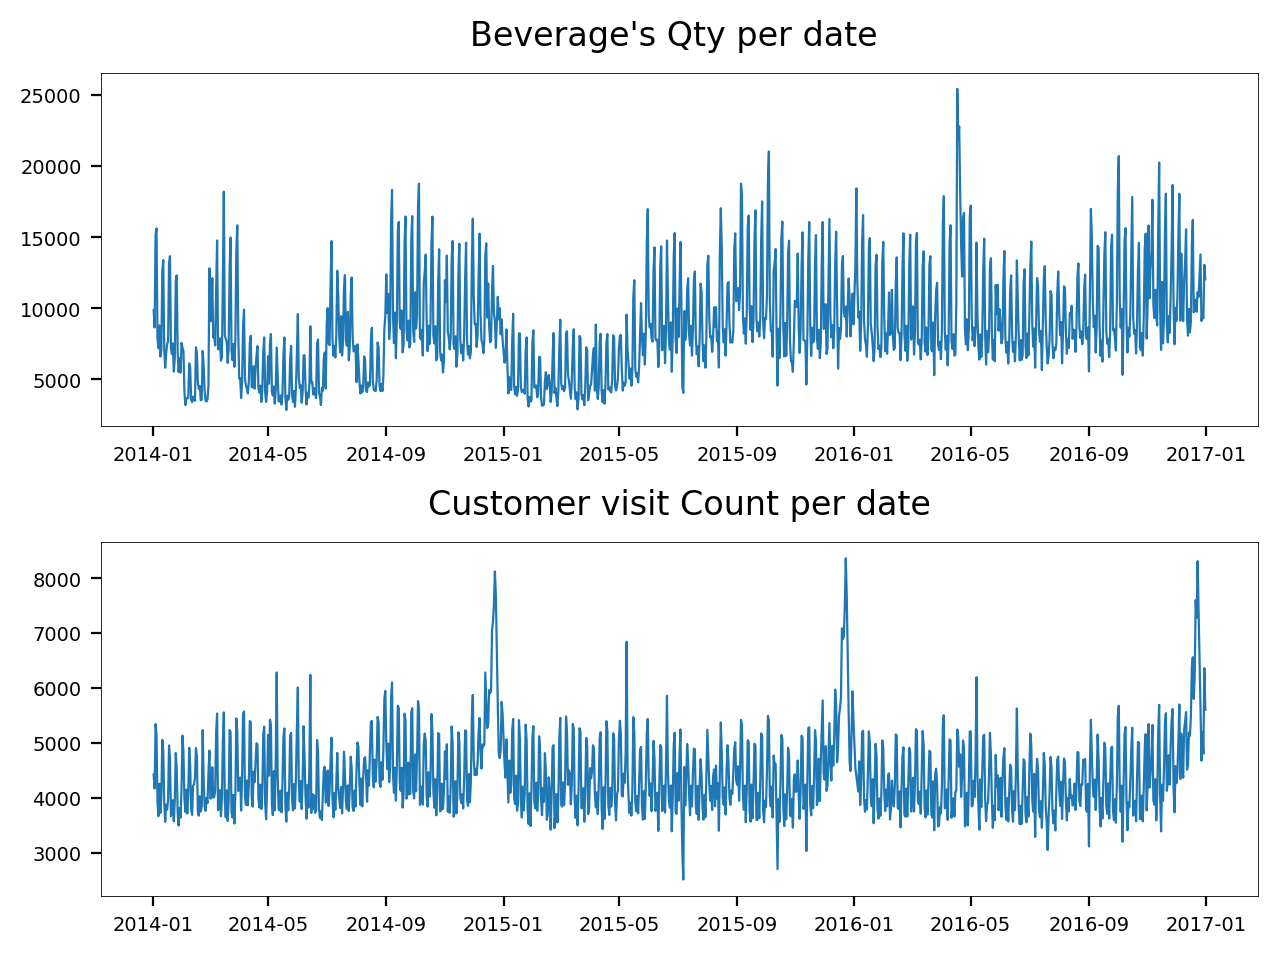

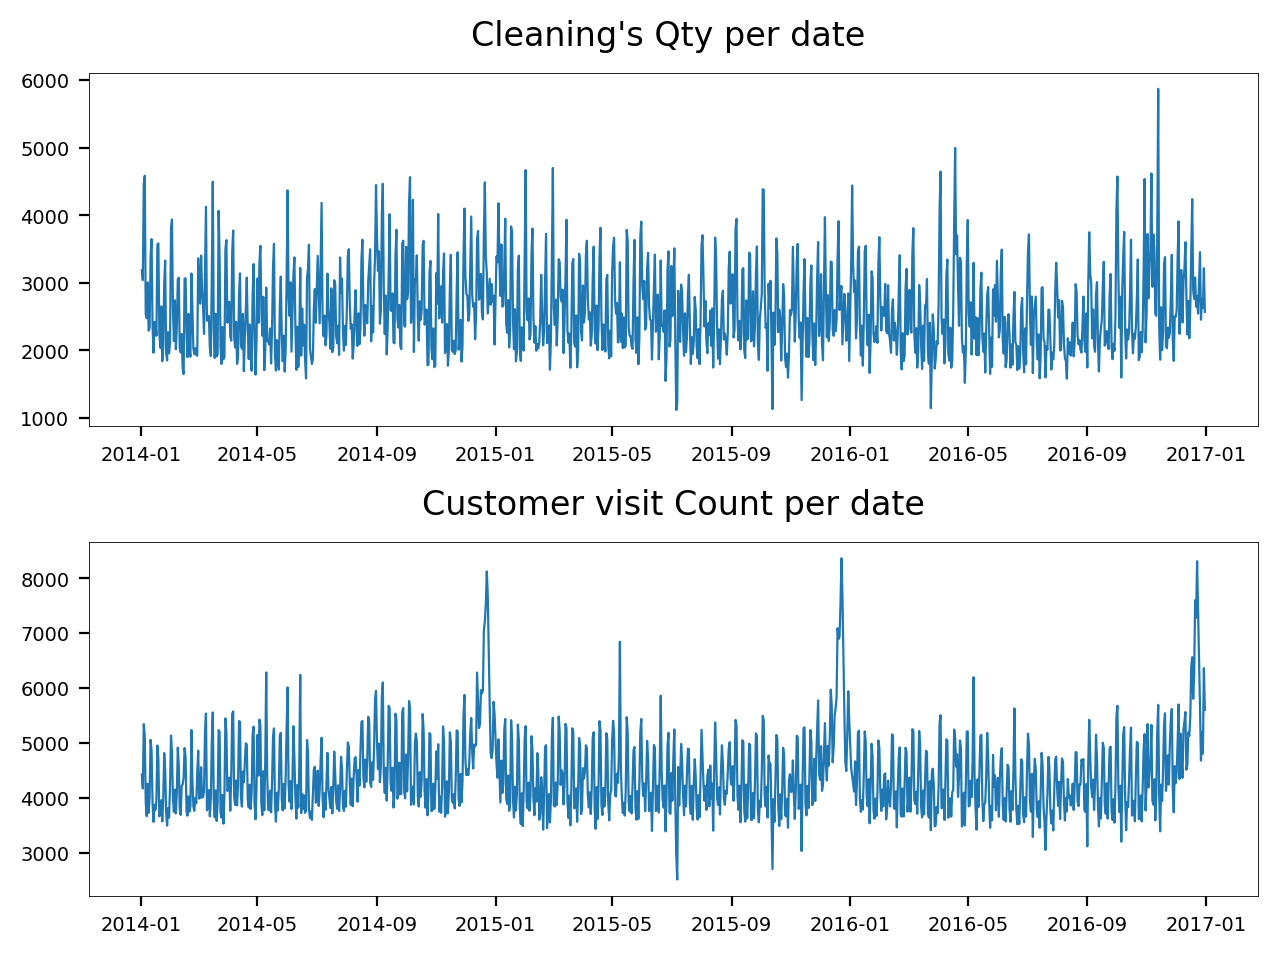

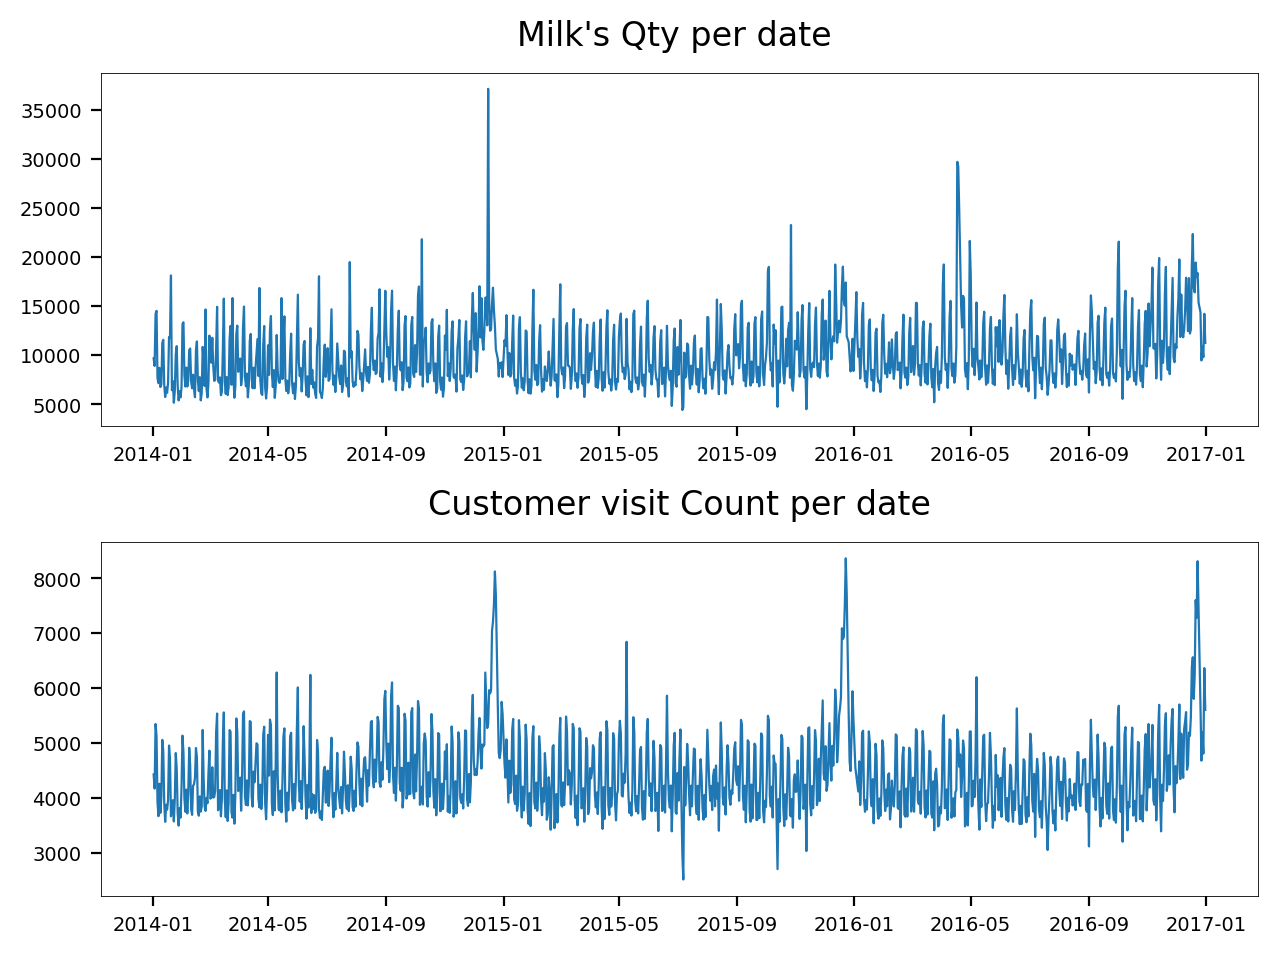

In [60]:
target_store = 44
target_products = [3,7,12]

for t in target_products:
    product_customer_trend(target_store,t,'2014-01-01', '2016-12-31')


- 위 함수를 사용해 1년간(2016년) 고객 방문수와 주요 상품의 판매량 추이를 확인합니다.

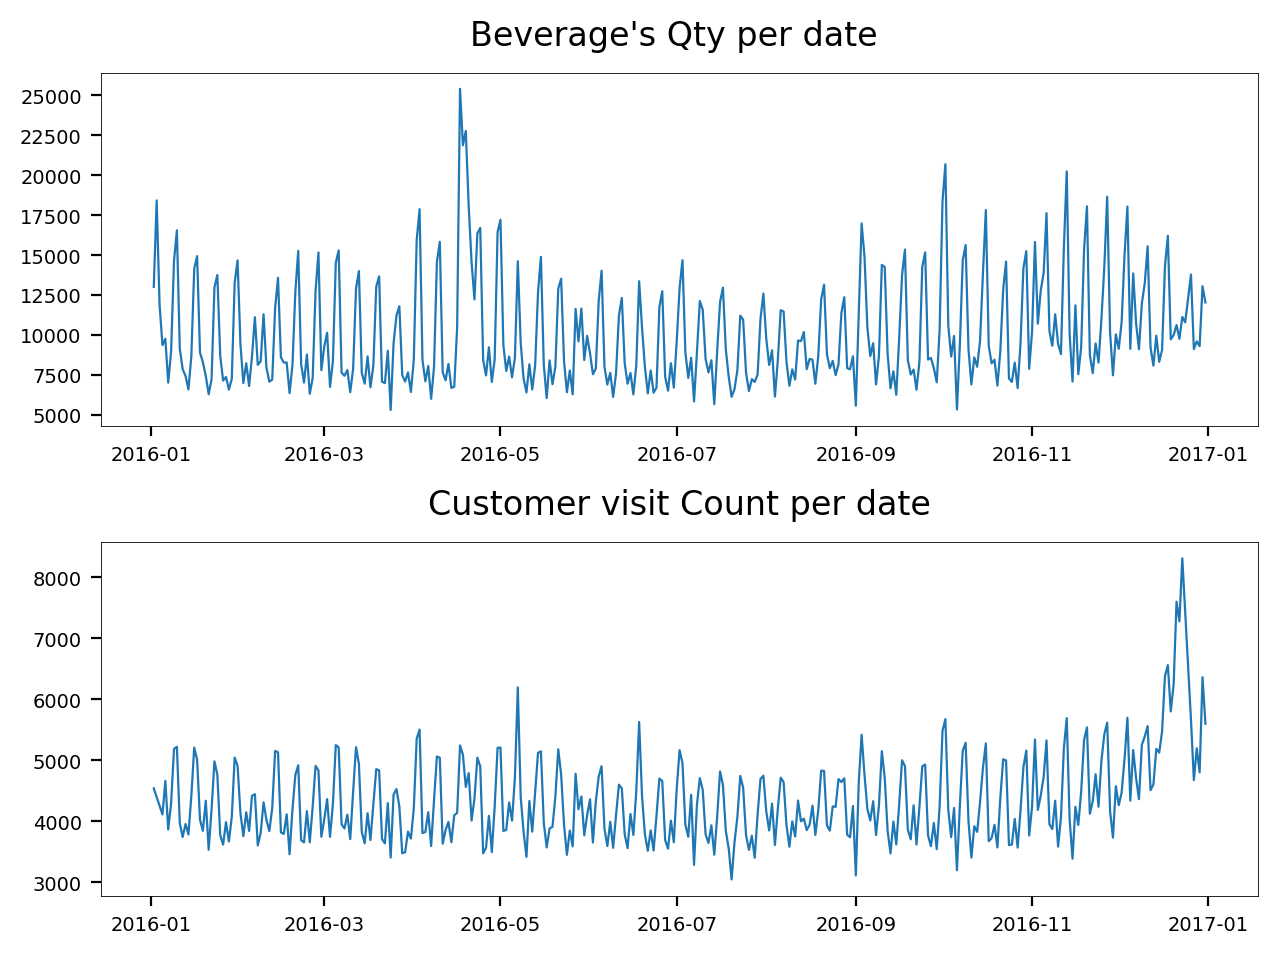

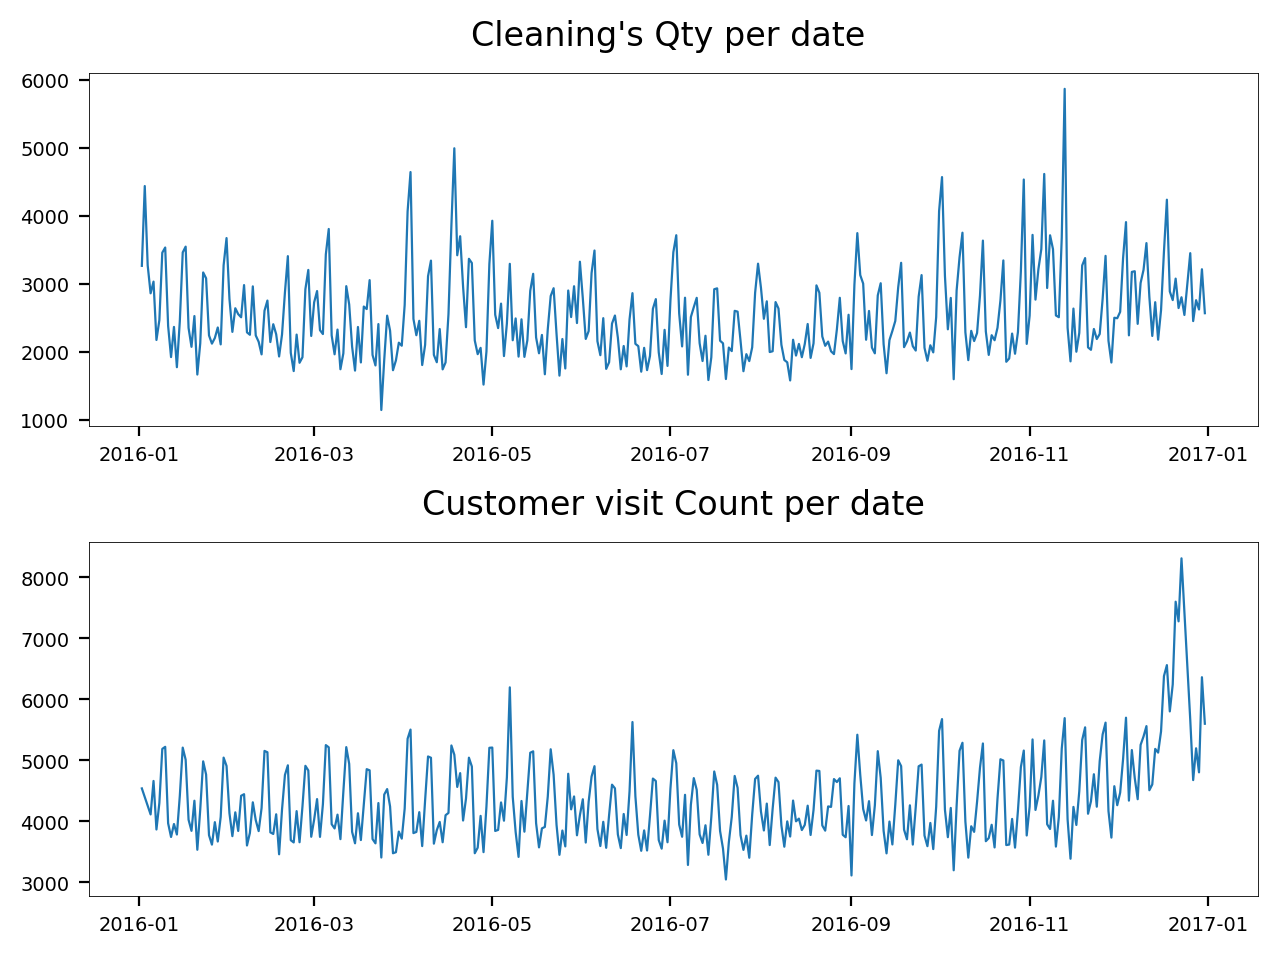

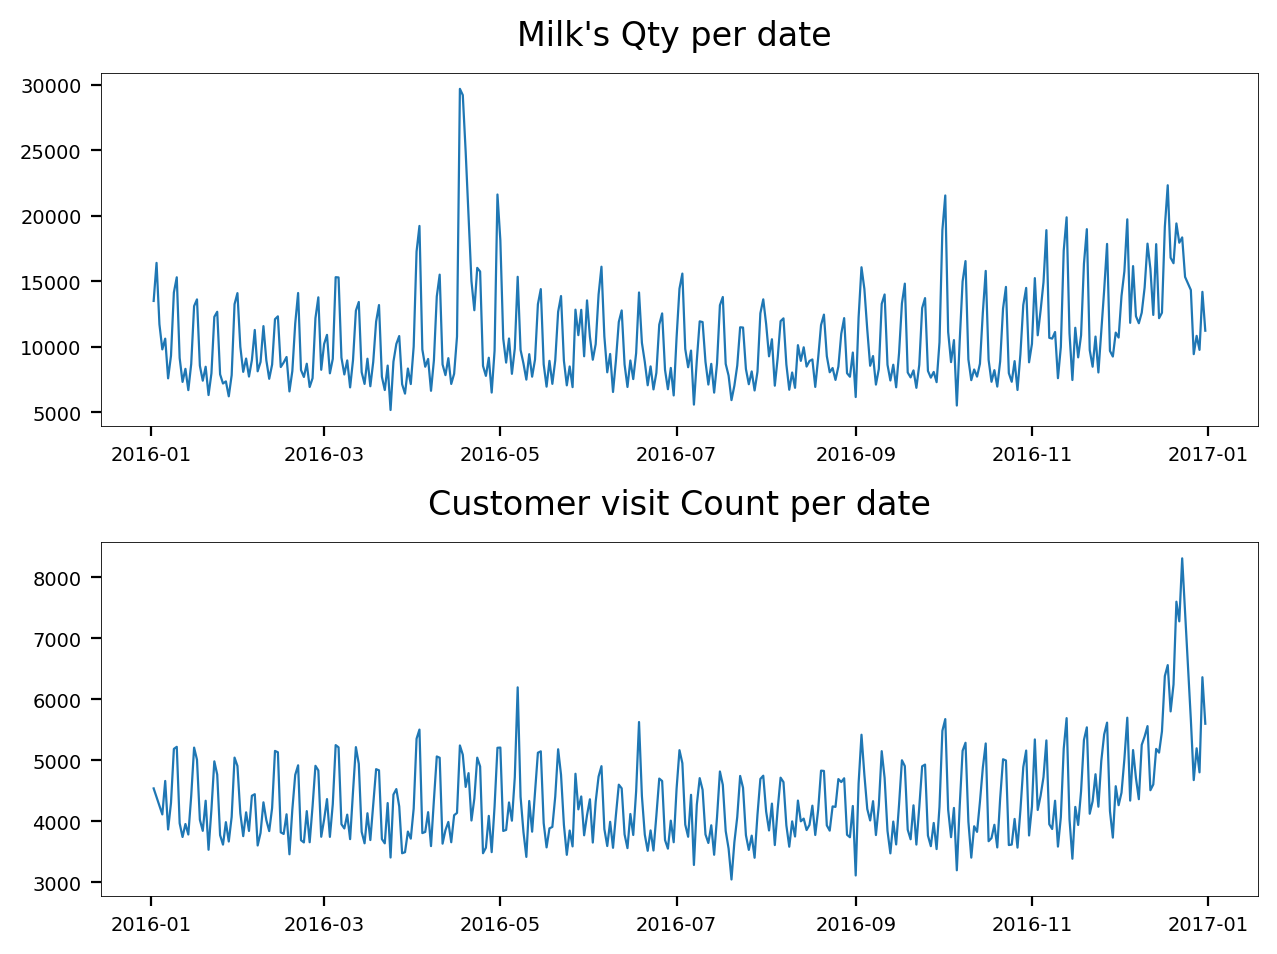

In [62]:

target_store = 44
target_products = [3,7,12]

for t in target_products:
    product_customer_trend(target_store,t,'2016-01-01', '2016-12-31')


### 3) 휘발유 가격과 상품 판매량 추이 비교

- 휘발유 가격 추이와 대상 상품 판매량 추이를 선그래프로 시각화해 비교합니다.
- 우선 사용할 함수를 만듭니다.
- 함수 이름: product_oil_trend- 
입력: 매장번호(store_id), 상품번호(product_id), 시작일(sdate), 종료일(edate)

In [64]:
# oil_price데이터셋에  wti_price 이 있음  
def product_oil_trend(store_id , product_id ,sdate,edate):
    #상품 판매량 추이
    temp1 = sales.loc[(sales['store_id']==store_id)&
    (sales['product_id']==product_id)&
    (sales['date'].between(sdate,edate))]

    # 기름값 판매량 추이  # oil_price > wti_price
    temp2 = oil_price.loc[oil_price['date'].between(sdate,edate)]

    # 타겟 상품 분류
    target = products.loc[products['product_id'] ==product_id]['subcategory'].values[0]
    
    # 그래프 시각화
    plt.subplot(2, 1, 1)
    plt.plot('date', 'qty', data=temp1, linewidth=0.8)
    plt.title(f'{target}\'s Qty per date ', size=12, pad=10)
    plt.subplot(2, 1, 2)
    plt.plot('date', 'wti_price', data=temp2, linewidth=0.8)
    plt.title('Oil_price per date' , size=12, pad=10)
    plt.tight_layout()
    plt.show()
    
    


- 위 함수를 사용해 3년간(2014년~2016년) 휘발유 가격과 주요 상품의 판매량 추이를 확인합니다.

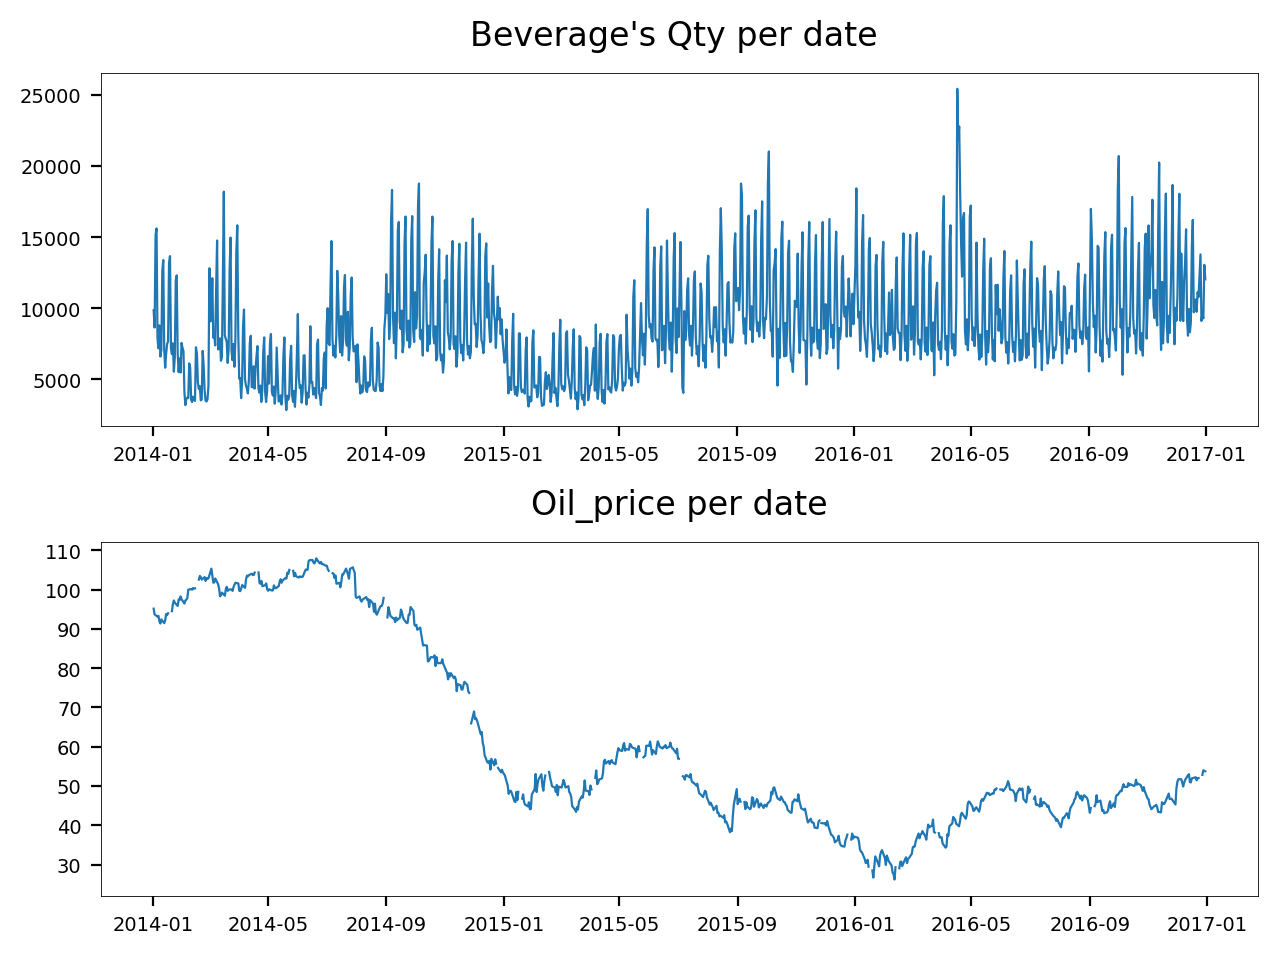

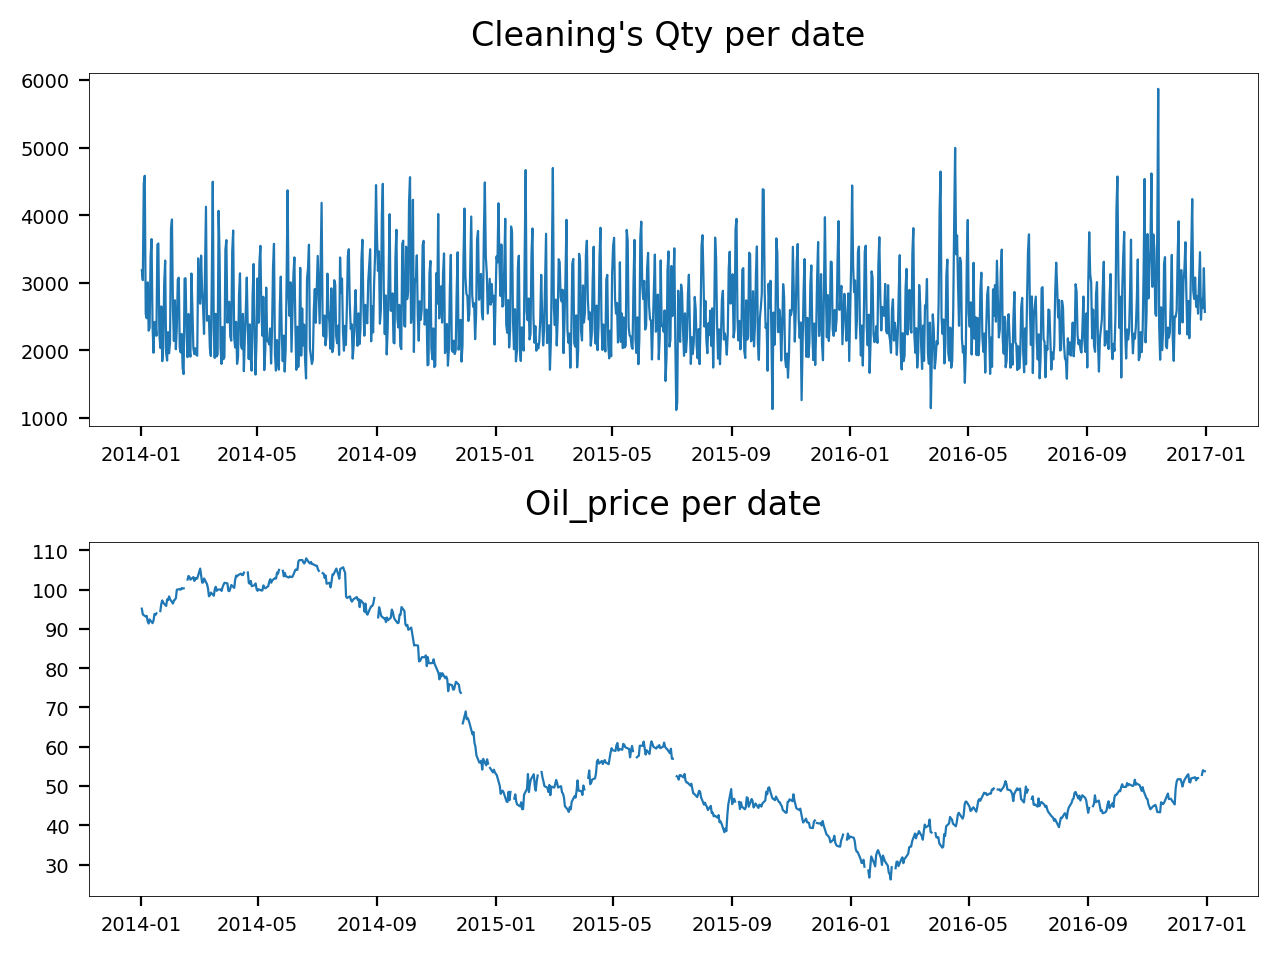

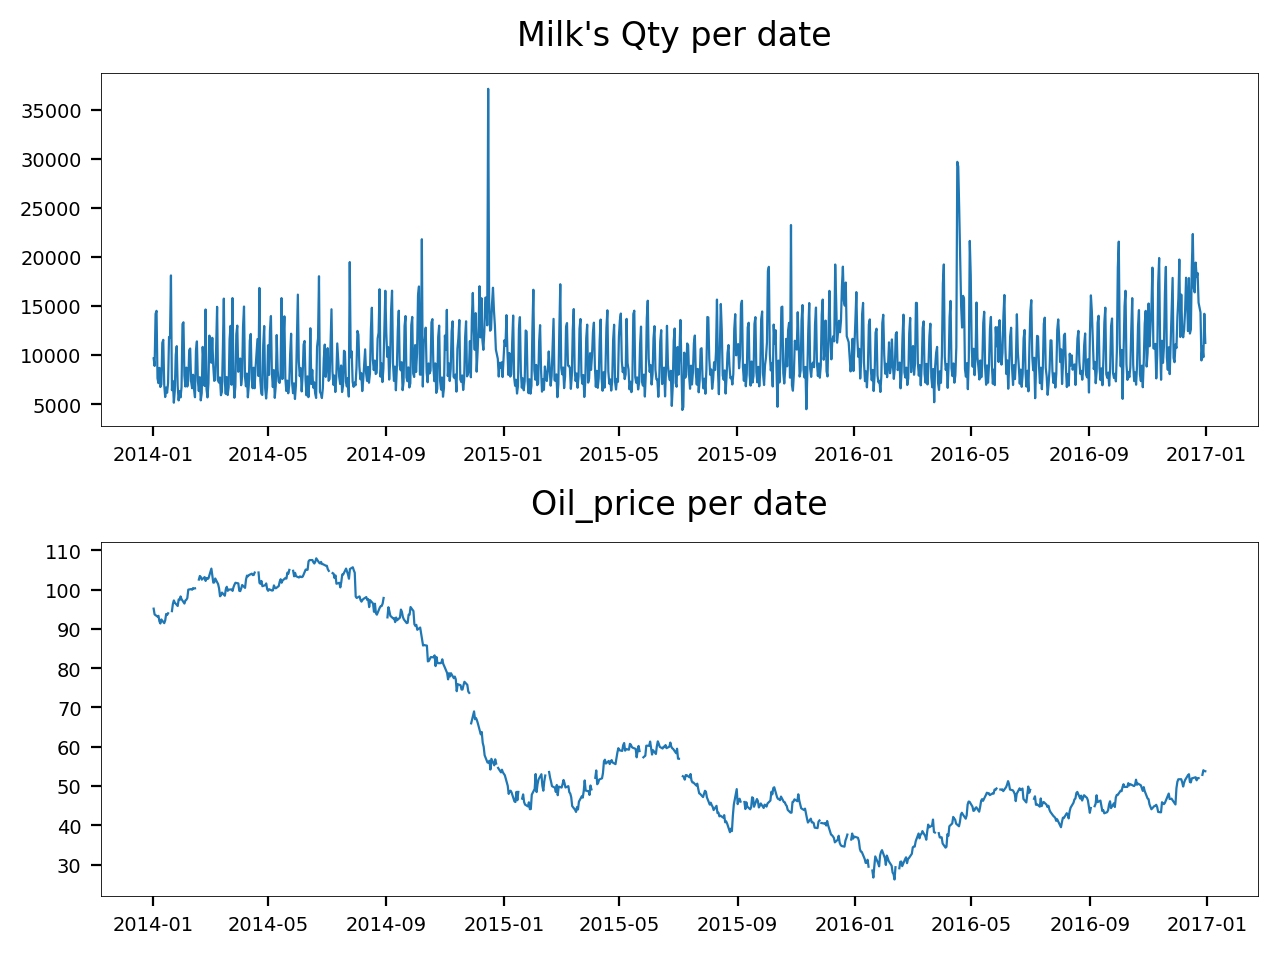

In [66]:
target_store = 44
target_products = [3,7,12]

for t in target_products:
    product_oil_trend(target_store,t,'2014-01-01', '2016-12-31')


- 위 함수를 사용해 1년간(2016년) 휘발유 가격과 주요 상품의 판매량 추이를 확인합니다.

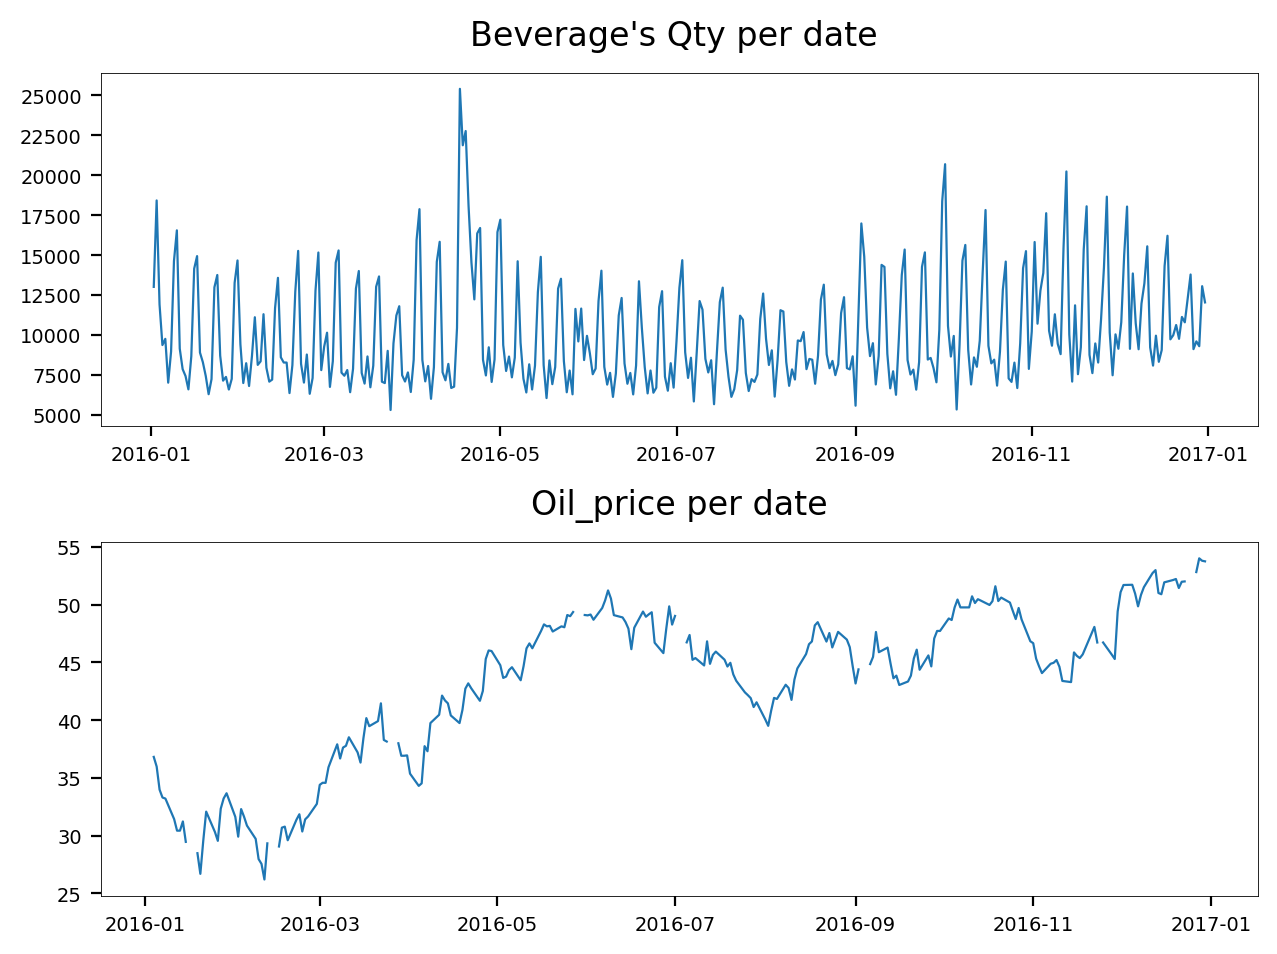

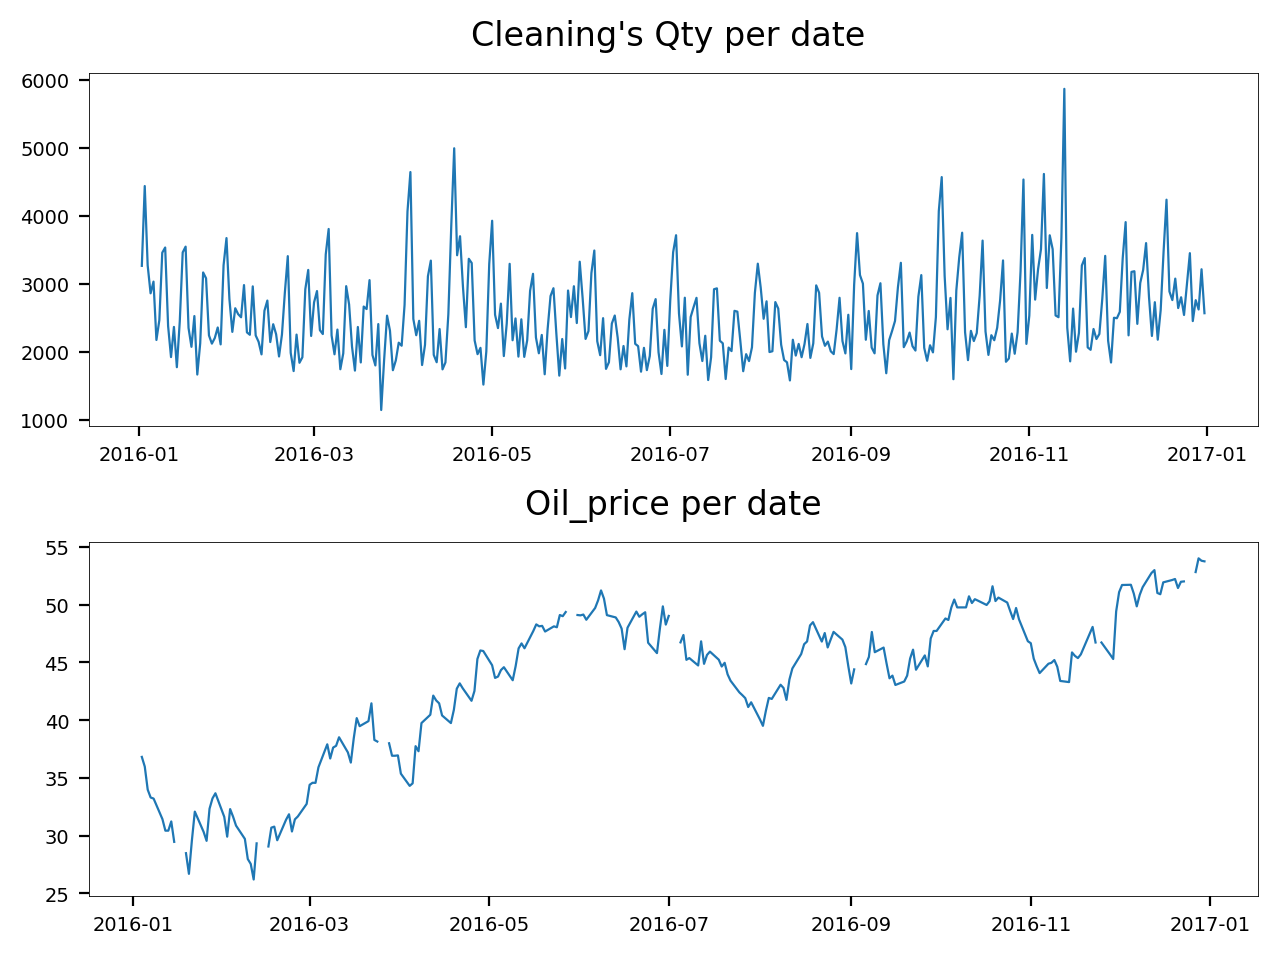

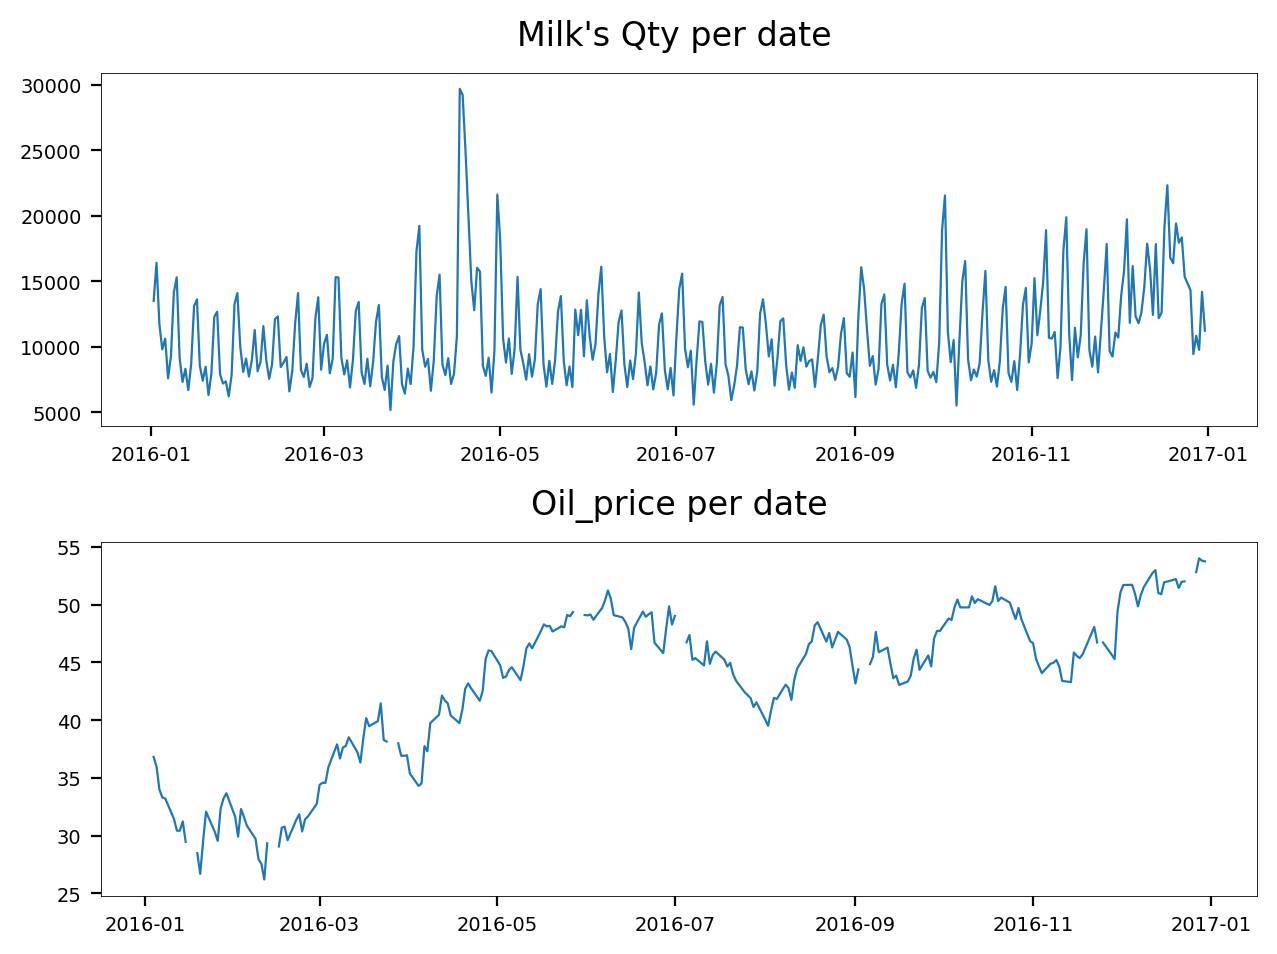

In [68]:
target_store = 44
target_products = [3,7,12]

for t in target_products:
    product_oil_trend(target_store,t,'2016-01-01', '2016-12-31')



### 4) 대상 상품과 같은 카테고리의 상품별 판매량 추이

- 대상 상품과 같은 카테고리에 포함된 상품 판매량을 집계해 판매량 추이를 선그래프로 시각화해 확인합니다.
- 우선 사용할 함수를 만듭니다.
- 함수 이름: category_product_sales_trend
- 입력: 매장번호(store_id), 상품번호(product_id), 시작일(sdate), 종료일(edate)

In [70]:
products

product_id product_code      subcategory         category  leadtime  price
0           20        HG001  Gardening Tools  Household Goods         2     50
1           27        HH001  Home Appliances  Household Goods         2    150
2           16        HK001          Kitchen  Household Goods         2     23
3           15        HK002          Kitchen  Household Goods         2     41
4           32        GS001          Seafood          Grocery         3     34
5           38        DA001             Wine            Drink         2     12
6           29        FP001         Prepared             Food         2     18
7           11        FF001           Frozen             Food         2     29
8           10        GE001             EGGS          Grocery         2      5
9           24        GM001            Meats          Grocery         3     17
10           5        FB001           BAKERY             Food         2      6
11           8        FM001           Yogurt             Food         2      4
12           7        HC001         Cleaning  Household Goods         2     15
13           3        DB001         Beverage            Drink         2      8
14          12        GA001             Milk             Food         2      6

In [71]:

def category_product_sales_trend(store_id,product_id,sdate,edate):
    #대상 상품 판매량 추이
    temp1 = sales.loc[(sales['store_id']==store_id)&
    (sales['product_id']==product_id)&
    (sales['date'].between(sdate,edate))]

    
    
    # product 에서  product_id 에 해당하는 category 추출
    category_name =  products.loc[products['product_id'] ==product_id]['category'].values[0]
    #print(category_name)
    # 연관 상품의 판매량 추이 
    category_chain = products.loc[products['category']==category_name]['product_id'].values
    #print(category_chain)

    
    # 연관상품 판매량 집계 
    related_sales = sales.loc[(sales['store_id'] == store_id) &
                          (sales['product_id'].isin(category_chain)) &
                          (sales['date'].between(sdate, edate))]
    #print(related_sales)
    temp2 = related_sales.groupby('date')['qty'].sum().reset_index()
    print(temp2)
    # 대상 상품과 연관된 상품의 중분류 
    target = products.loc[products['product_id'] ==product_id]['subcategory'].values[0]
    
    # 그래프 시각화
    plt.subplot(2, 1, 1)
    plt.plot('date', 'qty', data=temp1, linewidth=0.8)
    plt.title(f'{target}\'s Qty per date ', size=12, pad=10)
    plt.subplot(2, 1, 2)
    plt.plot('date', 'qty', data=temp2, linewidth=0.8)
    plt.title(f'{target} relate products Qty per date ' , size=12, pad=10)
    plt.tight_layout()
    plt.show()

- 위 함수를 사용해 3년간(2014년~2016년) 주요 상품의 판매량 추이와 같은 카테고리 판매량 추이를 확인합니다.

           date      qty
0    2014-01-02  10142.0
1    2014-01-03   8980.0
2    2014-01-04  15684.0
3    2014-01-05  15606.0
4    2014-01-06   8083.0
...         ...      ...
1085 2016-12-27   9559.0
1086 2016-12-28  10188.0
1087 2016-12-29   9908.0
1088 2016-12-30  14094.0
1089 2016-12-31  13066.0

[1090 rows x 2 columns]


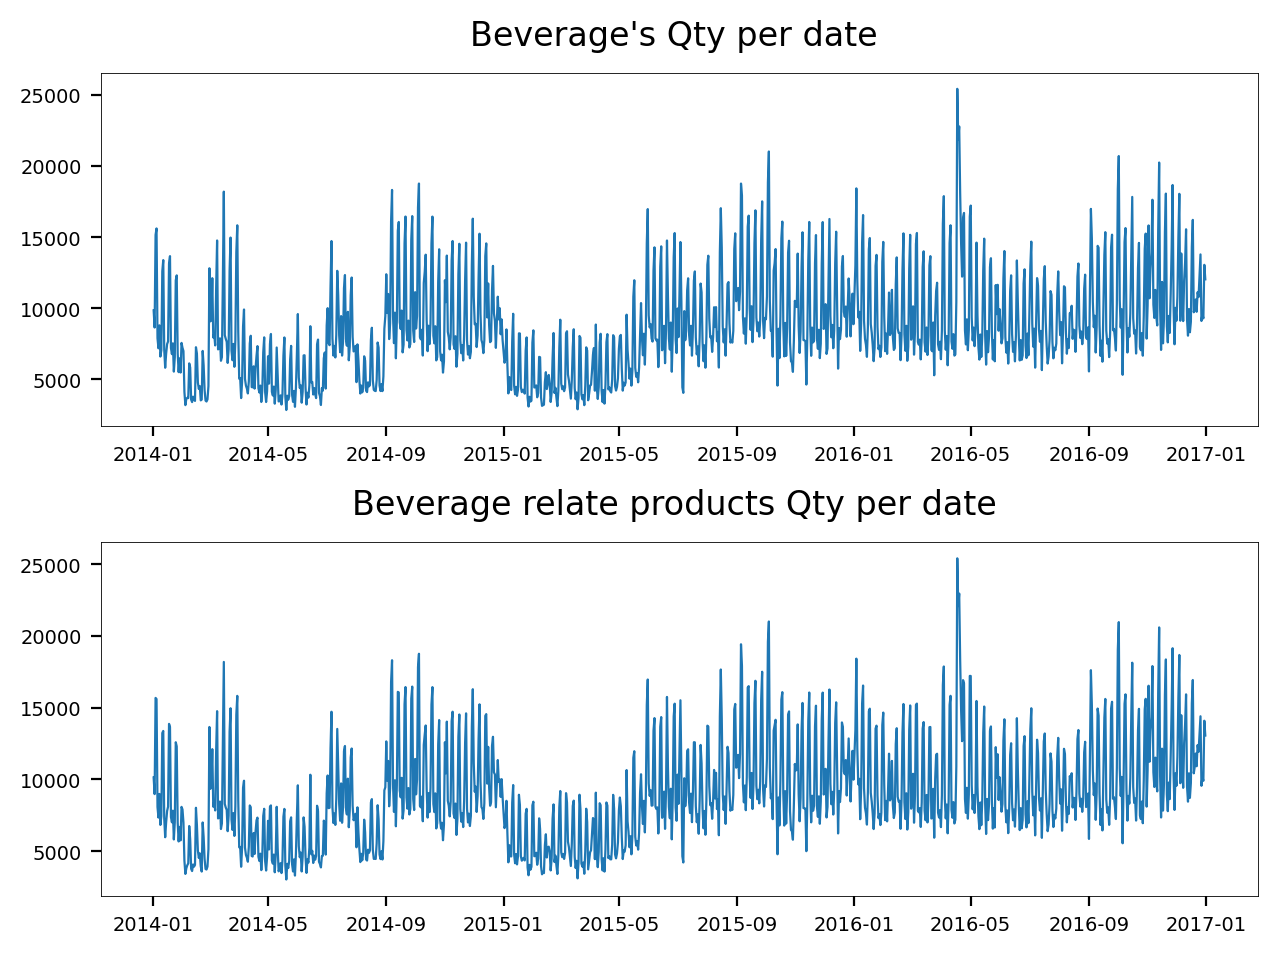

           date     qty
0    2014-01-02  3312.0
1    2014-01-03  3212.0
2    2014-01-04  4689.0
3    2014-01-05  4791.0
4    2014-01-06  2664.0
...         ...     ...
1085 2016-12-27  2690.0
1086 2016-12-28  4837.0
1087 2016-12-29  2899.0
1088 2016-12-30  3775.0
1089 2016-12-31  3052.0

[1090 rows x 2 columns]


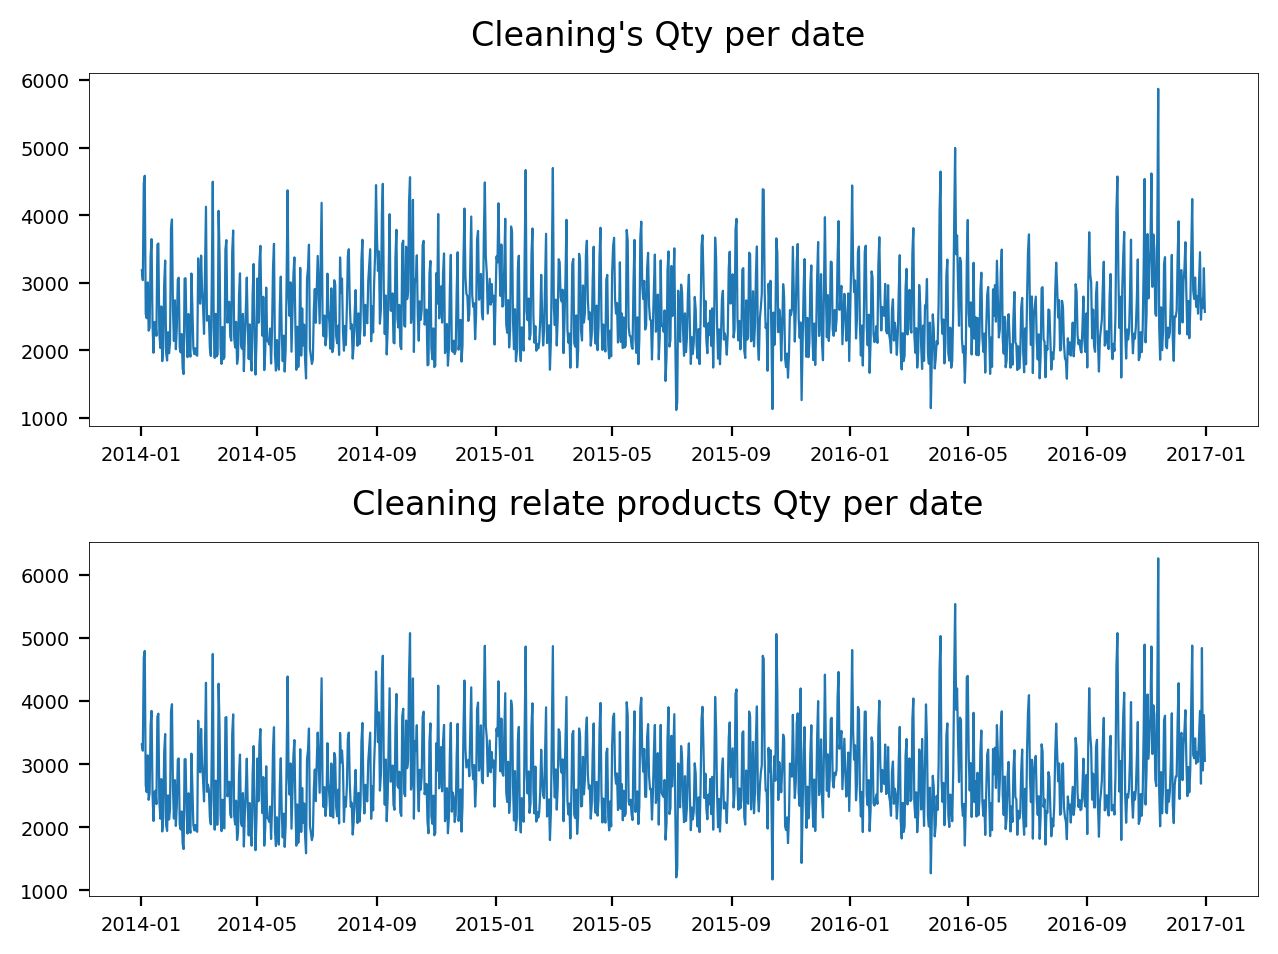

           date          qty
0    2014-01-02  15195.55000
1    2014-01-03  13952.68900
2    2014-01-04  22059.12500
3    2014-01-05  22443.85100
4    2014-01-06  11853.28100
...         ...          ...
1085 2016-12-27  14790.66700
1086 2016-12-28  16979.95800
1087 2016-12-29  15590.32800
1088 2016-12-30  21744.12600
1089 2016-12-31  17690.81602

[1090 rows x 2 columns]


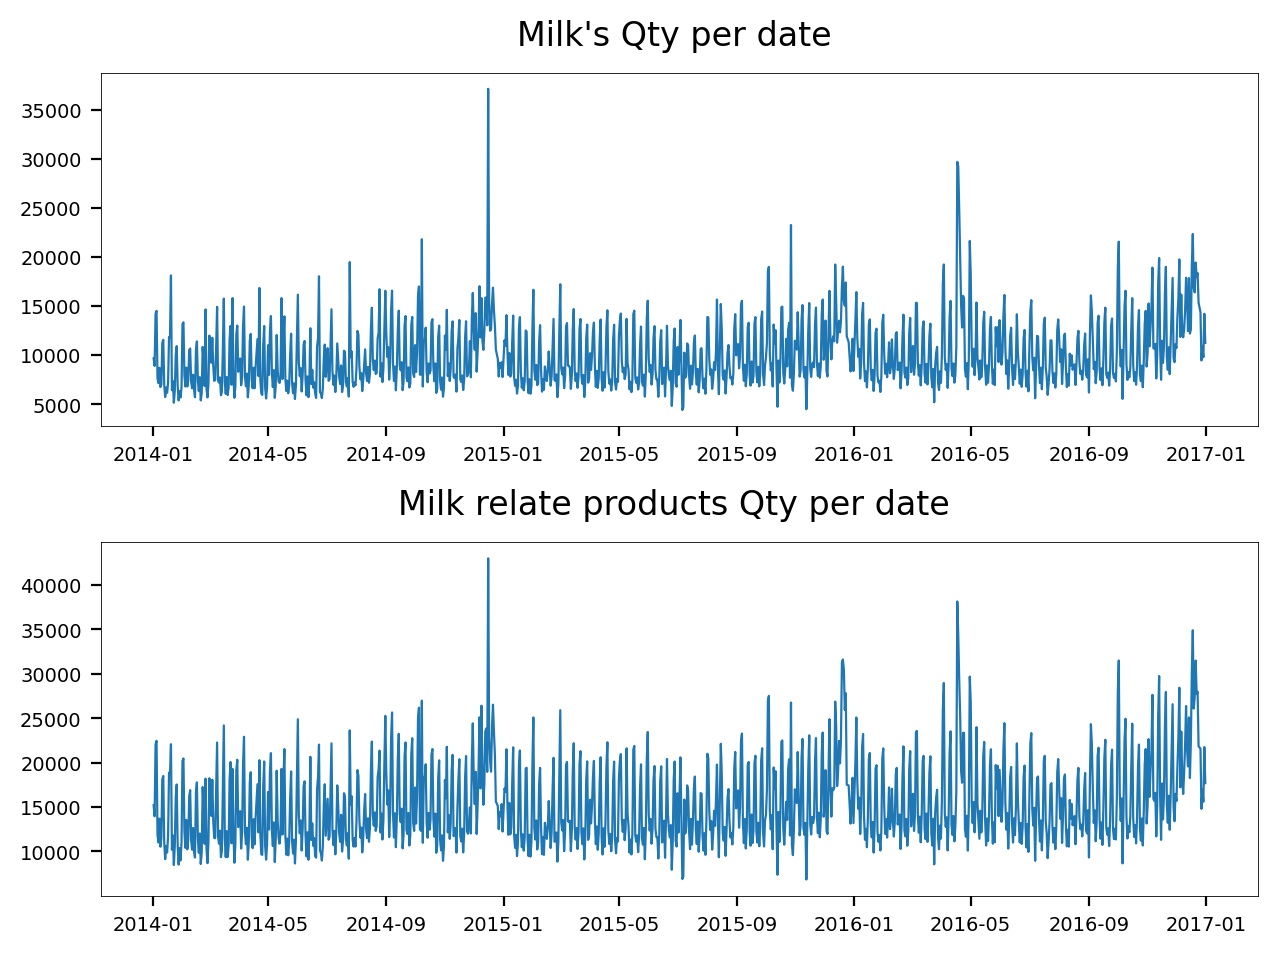

In [73]:

target_store = 44
target_products = [3,7,12]

for t in target_products:
    category_product_sales_trend(target_store,t,'2014-01-01', '2016-12-31')

- 위 함수를 사용해 1년간(2016년) 주요 상품의 판매량 추이와 같은 카테고리 판매량 추이를 확인합니다.

          date      qty
0   2016-01-02  13437.0
1   2016-01-03  18421.0
2   2016-01-04  12172.0
3   2016-01-05   9660.0
4   2016-01-06  10047.0
..         ...      ...
359 2016-12-27   9559.0
360 2016-12-28  10188.0
361 2016-12-29   9908.0
362 2016-12-30  14094.0
363 2016-12-31  13066.0

[364 rows x 2 columns]


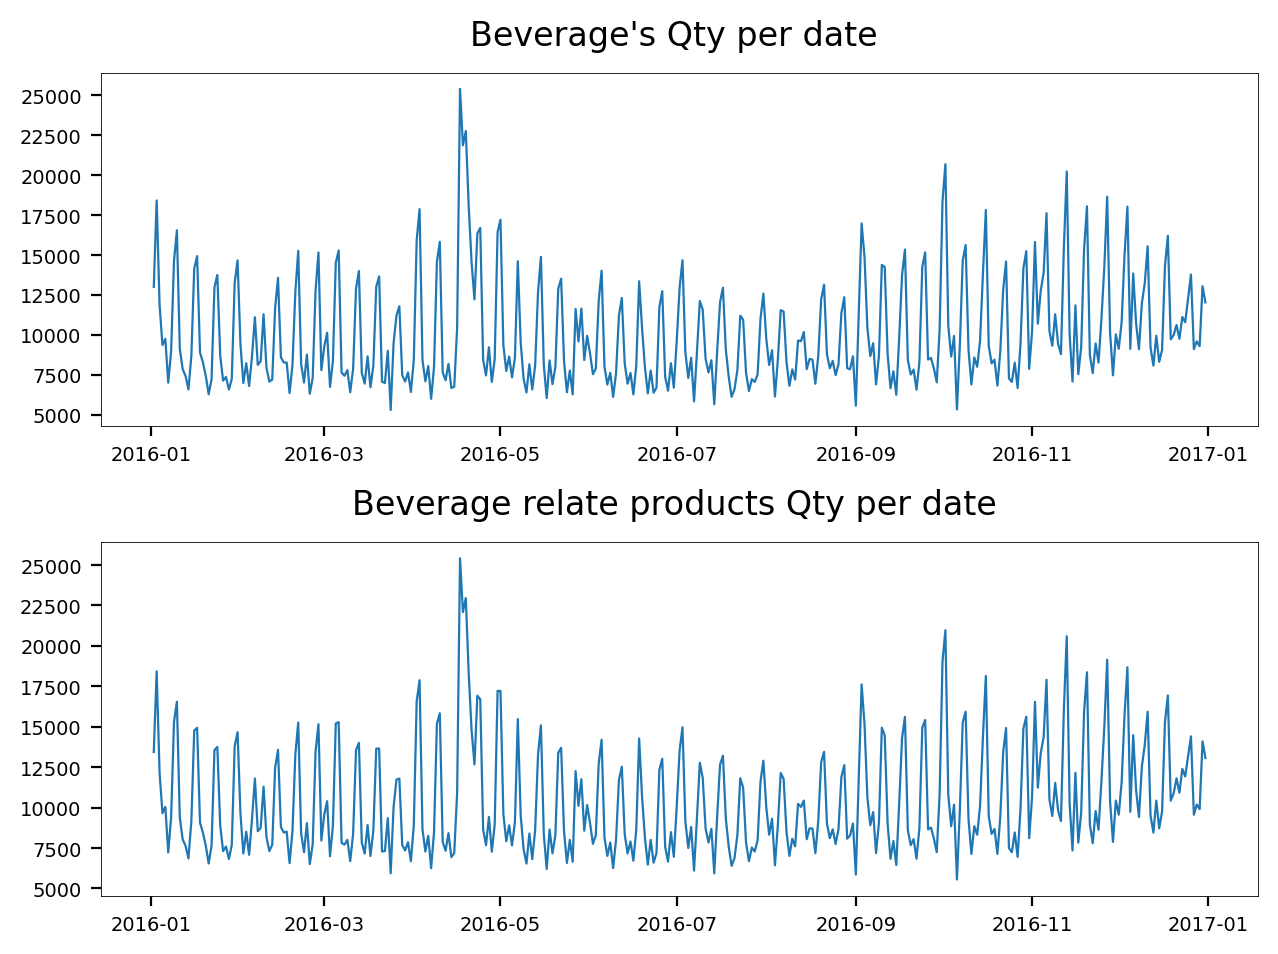

          date     qty
0   2016-01-02  3558.0
1   2016-01-03  4805.0
2   2016-01-04  3535.0
3   2016-01-05  3069.0
4   2016-01-06  3299.0
..         ...     ...
359 2016-12-27  2690.0
360 2016-12-28  4837.0
361 2016-12-29  2899.0
362 2016-12-30  3775.0
363 2016-12-31  3052.0

[364 rows x 2 columns]


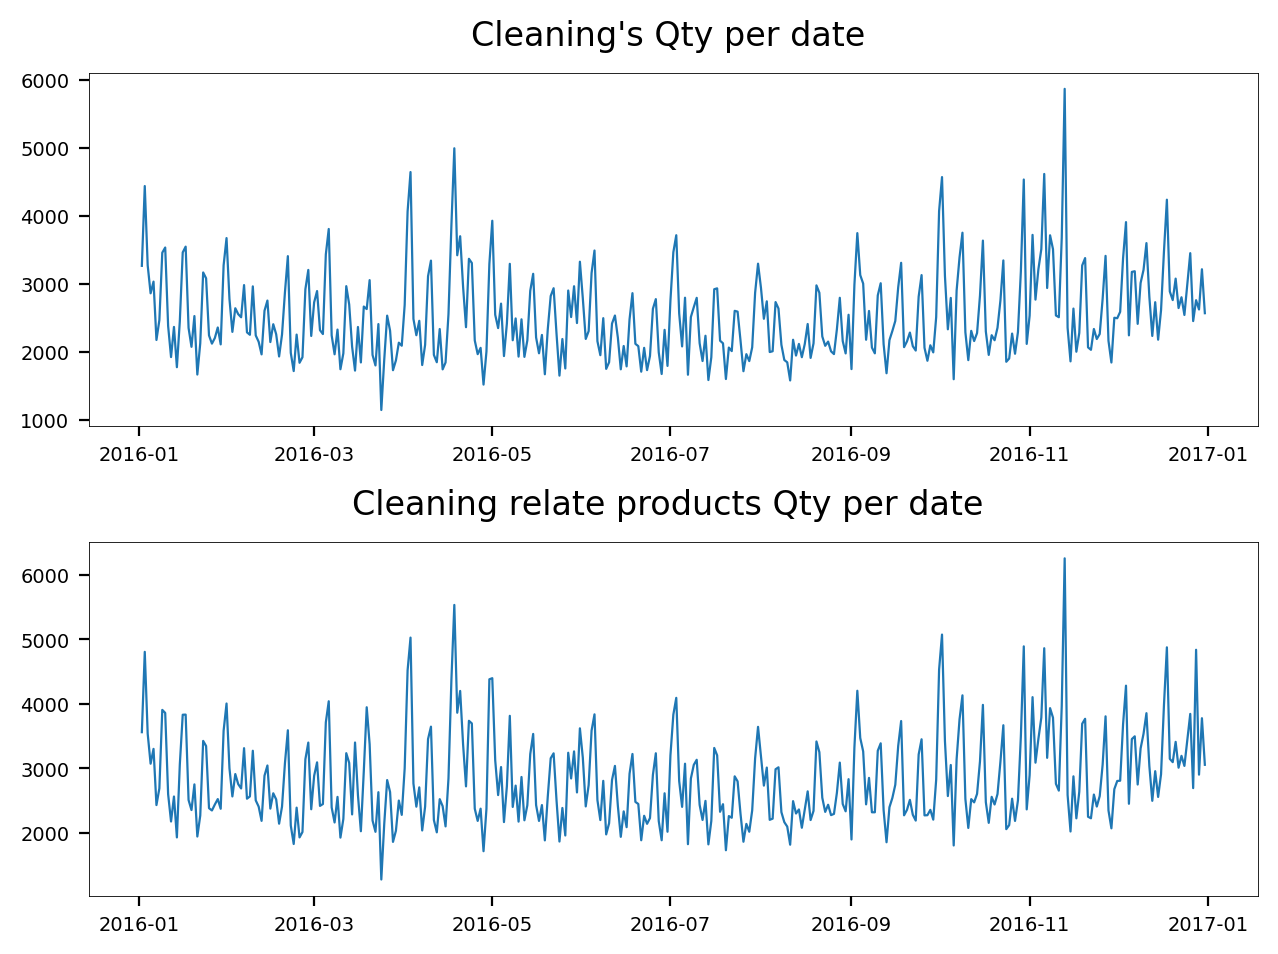

          date          qty
0   2016-01-02  20019.71303
1   2016-01-03  25070.27000
2   2016-01-04  17884.47297
3   2016-01-05  14795.26400
4   2016-01-06  16064.01110
..         ...          ...
359 2016-12-27  14790.66700
360 2016-12-28  16979.95800
361 2016-12-29  15590.32800
362 2016-12-30  21744.12600
363 2016-12-31  17690.81602

[364 rows x 2 columns]


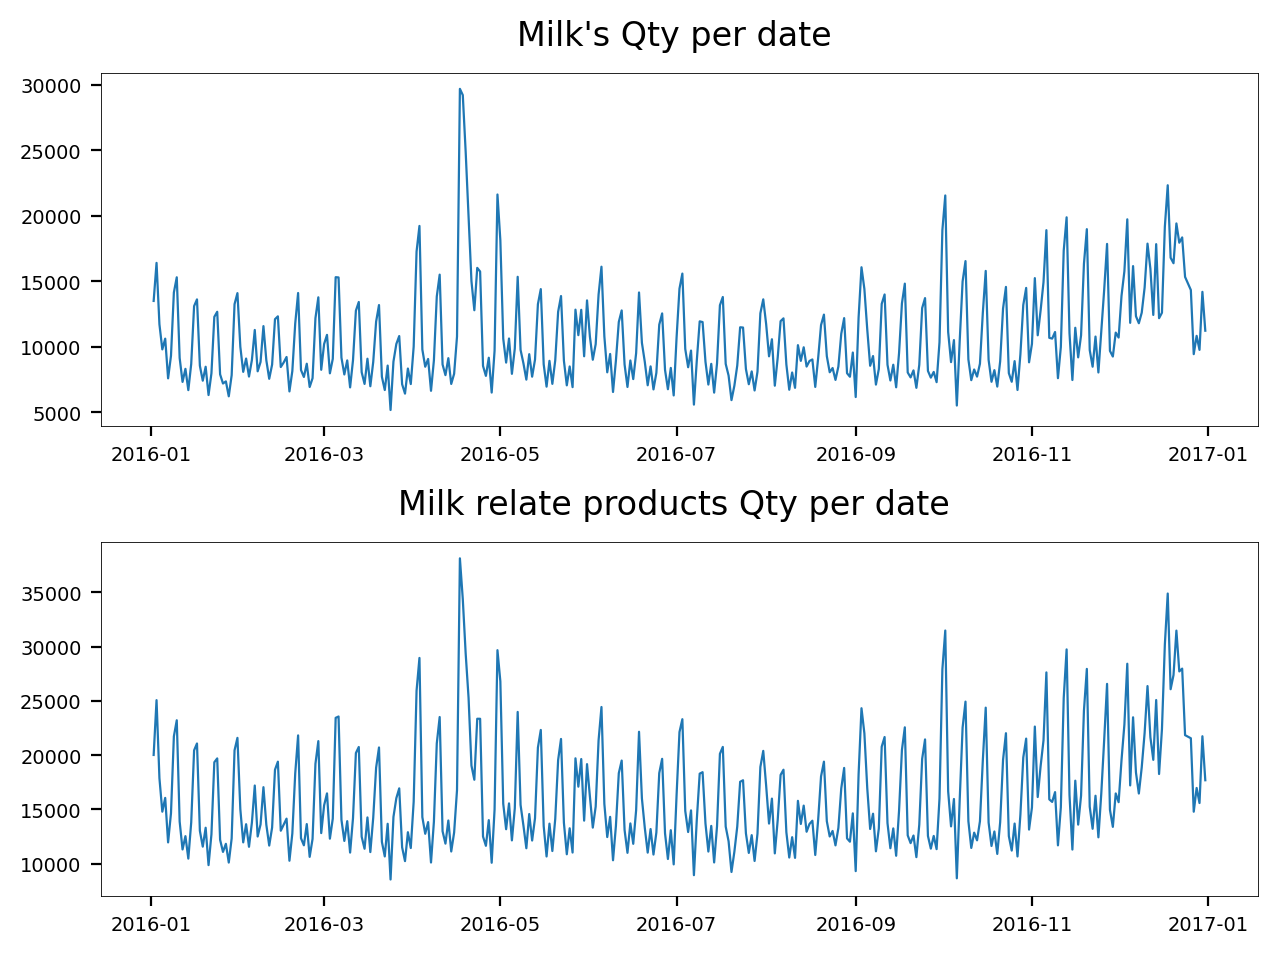

In [75]:
target_store = 44
target_products = [3,7,12]

for t in target_products:
    category_product_sales_trend(target_store,t,'2016-01-01', '2016-12-31')


In [76]:
# (추가) 해당 상품이 얼마나 비중을 차지하는지 알고싶음  (안 하셔도 됩니다 )
def category_product_sales_trend_percents(store_id, product_id, sdate, edate):
    # 대상 상품 판매량 추이
    temp1 = sales.loc[(sales['store_id'] == store_id) &
                      (sales['product_id'] == product_id) &
                      (sales['date'].between(sdate, edate))]

    # category 추출
    category_name = products.loc[products['product_id'] == product_id]['category'].values[0]
    
    # 연관 상품의 판매량 추이
    category_chain = products.loc[products['category'] == category_name]['product_id'].values
    
    # 연관상품 판매량 집계
    related_sales = sales.loc[(sales['store_id'] == store_id) &
                              (sales['product_id'].isin(category_chain)) &
                              (sales['date'].between(sdate, edate))]
    temp2 = related_sales.groupby('date')['qty'].sum().reset_index()

    # 대상 상품과 연관된 상품의 중분류
    target = products.loc[products['product_id'] == product_id]['subcategory'].values[0]

    # 대분류 category에서 대상 상품의 비중 계산
    total_qty_target = temp1['qty'].sum()
    total_qty_category = temp2['qty'].sum()
    
    if total_qty_category > 0:
        proportion = total_qty_target / total_qty_category * 100
    else:
        proportion = 0  # 0으로 나눔 방지
    print(f"{product_id}의 판매량이 {category_name}에서 차지하는 비중: {proportion:.2f}%")

In [77]:
target_store = 44
target_products = [3,7,12]

for t in target_products:
    category_product_sales_trend_percents(target_store,t,'2014-01-01', '2016-12-31')

3의 판매량이 Drink에서 차지하는 비중: 96.16%
7의 판매량이 Household Goods에서 차지하는 비중: 92.48%
12의 판매량이 Food에서 차지하는 비중: 65.36%


### 5) 상품별 판매 변화량 비교

- 상품별 판매 변화량을 비교합니다.
- df['변수'].diff() 형태로 변수에 대한 변화량을 확인할 수 있습니다.
- 변화량을 선그래프로 시각화하거나, 변화량의 분포를 히스토그램으로 시각화할 수 있습니다.
- 우선 사용할 함수를 만듭니다.
- 함수 이름: product_sales_diff_trend
- 입력: 매장번호(store_id), 상품번호(product_id), 시작일(sdate), 종료일(edate)

In [79]:

def product_sales_diff_trend(store_id , product_id ,sdate,edate):
    #대상 상품 판매량 추이
    temp = sales.loc[(sales['store_id']==store_id)&
    (sales['product_id']==product_id)&
    (sales['date'].between(sdate,edate))]

    # 상품 판매 변화량 측정할 열 생성 
    temp['Qty_diff'] = temp['qty'].diff()

    # 대상 상품과 연관된 상품의 중분류 
    target = products.loc[products['product_id'] ==product_id]['subcategory'].values[0]
    
    # 그래프 시각화
    plt.figure(figsize=(6, 3))
    plt.plot('date', 'Qty_diff', data=temp, linewidth=0.8)
    plt.title(f'{target}\'s Qty_diff per date ', size=12, pad=10)
    plt.tight_layout()
    plt.show()

- 위 함수를 사용해 3년간(2014년~2016년) 주요 상품의 판매 변화량과 변화량 분포를 확인합니다.

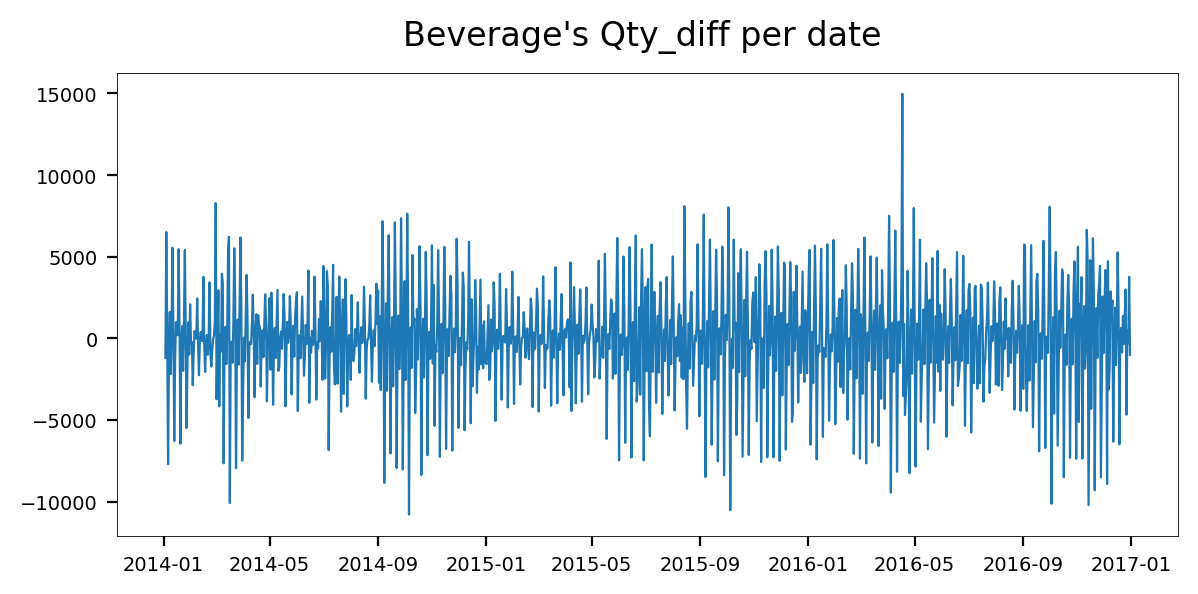

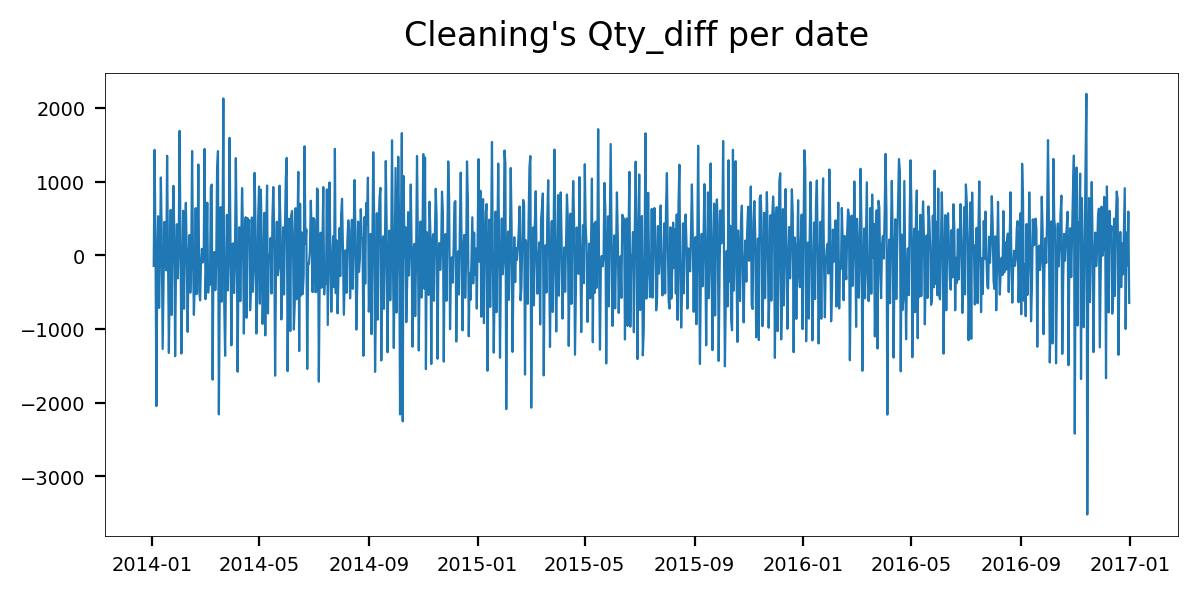

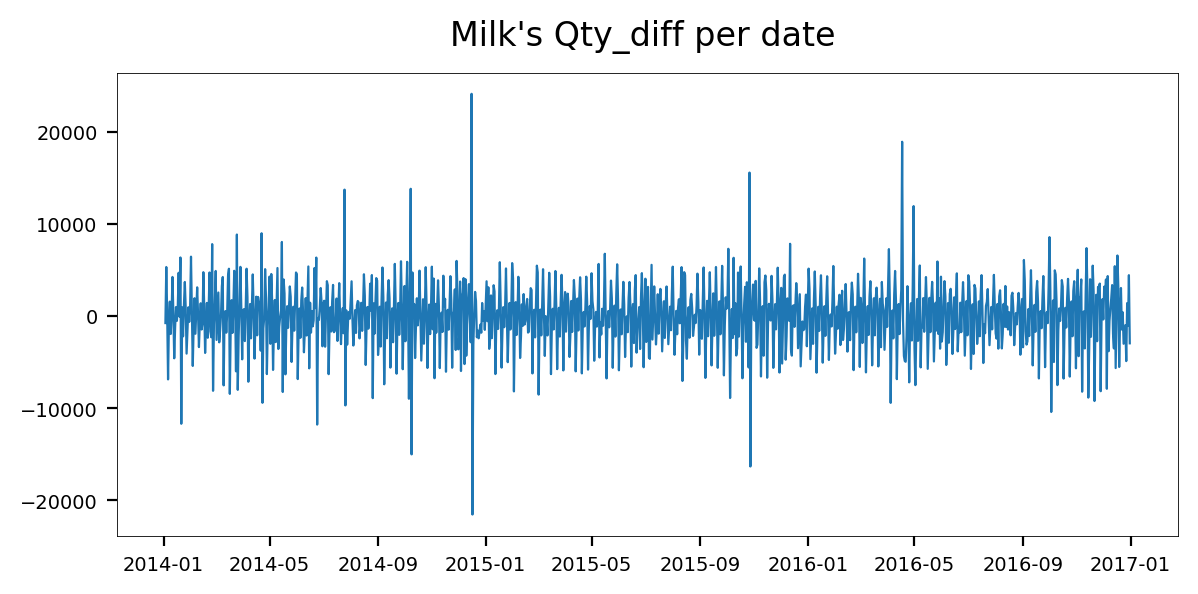

In [81]:
target_store = 44
target_products = [3,7,12]

for t in target_products:
    product_sales_diff_trend(target_store,t,'2014-01-01', '2016-12-31')



- 위 함수를 사용해 1년간(2016년) 주요 상품의 판매 변화량과 변화량 분포를 확인합니다.

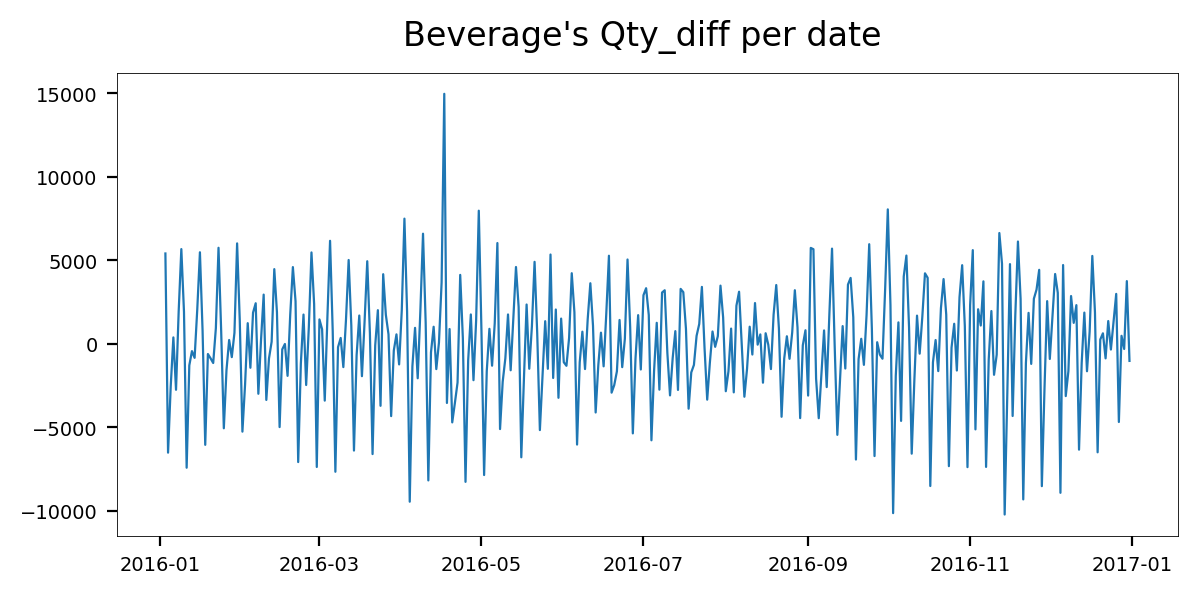

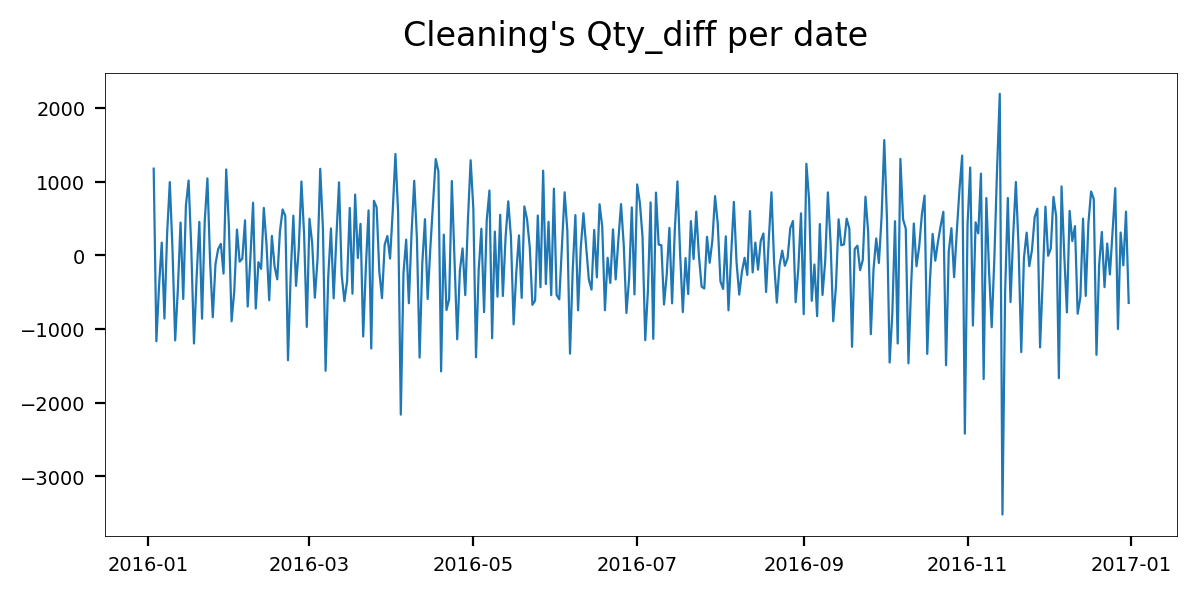

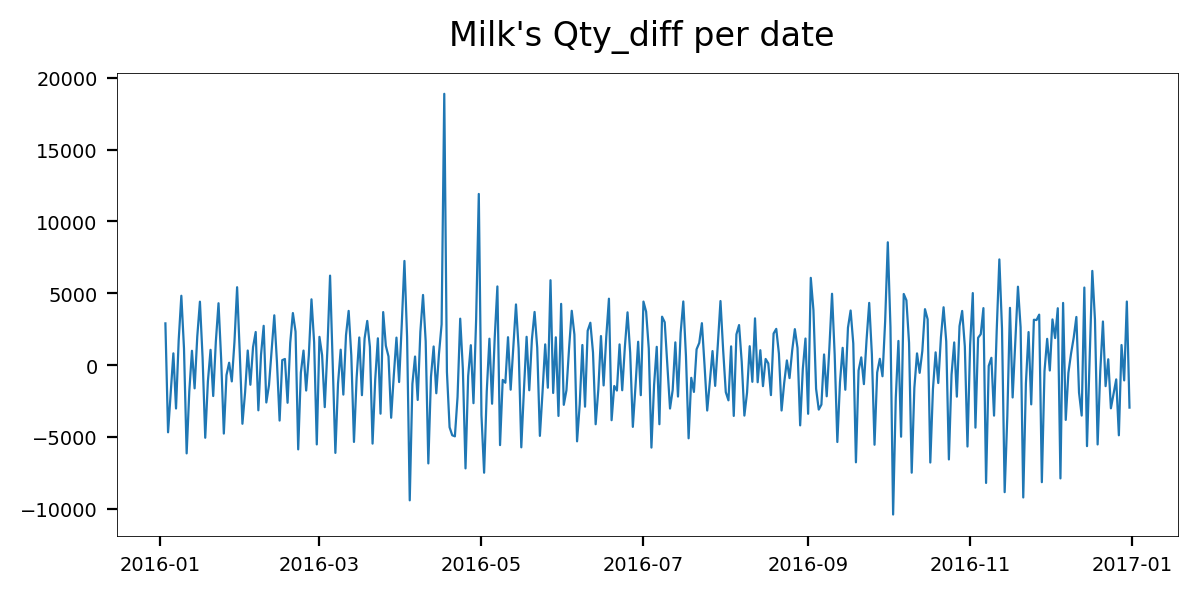

In [83]:
target_store = 44
target_products = [3,7,12]

for t in target_products:
    product_sales_diff_trend(target_store,t,'2016-01-01', '2016-12-31')



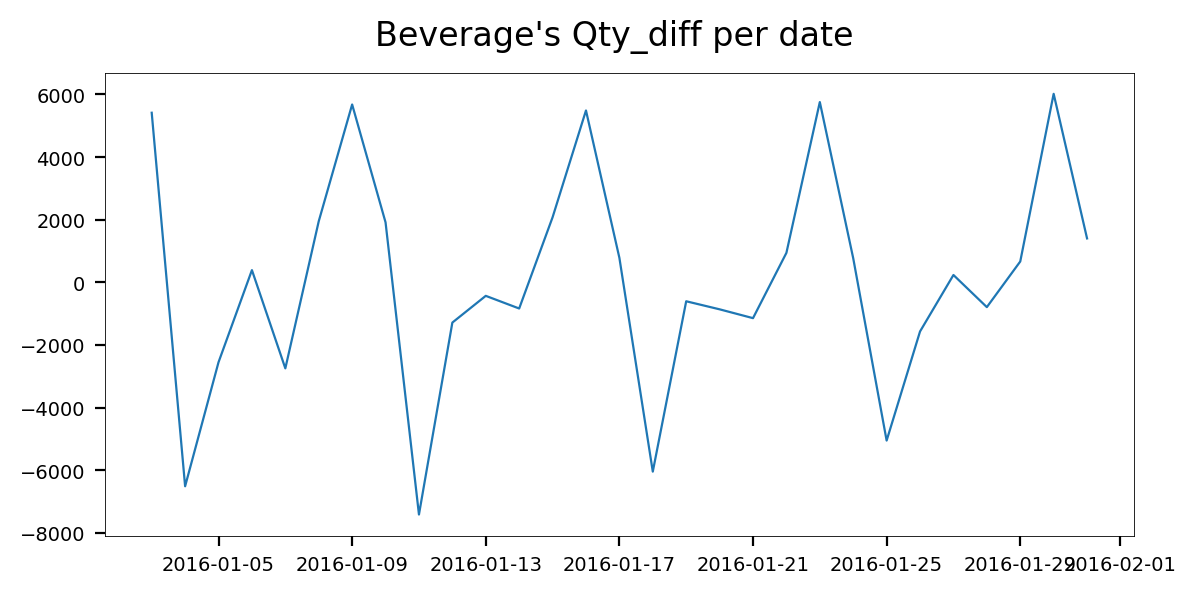

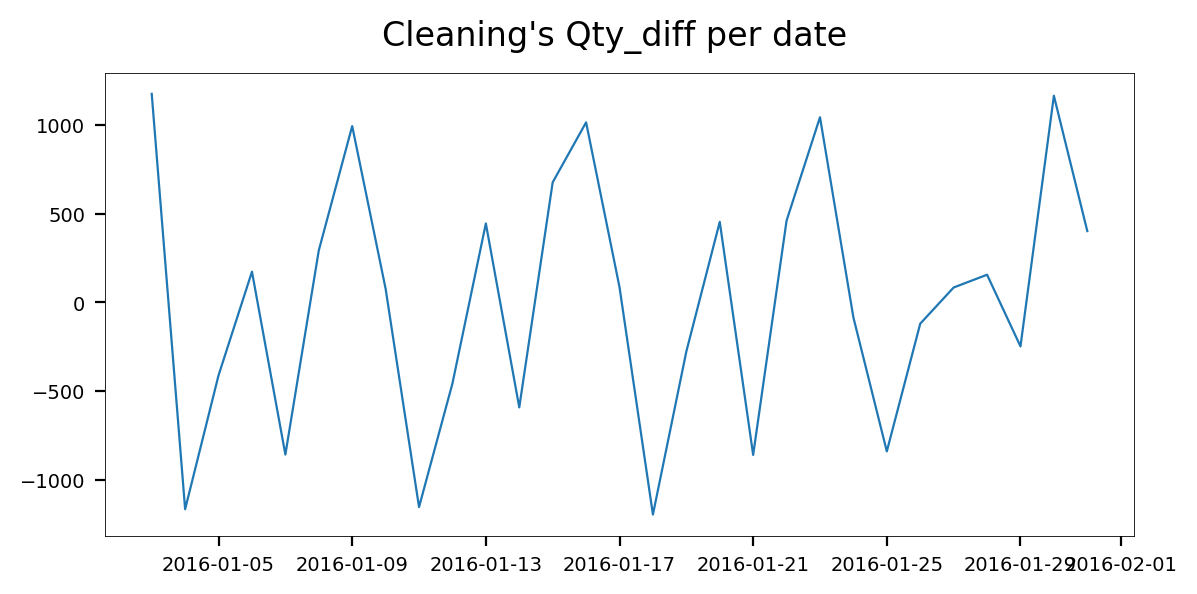

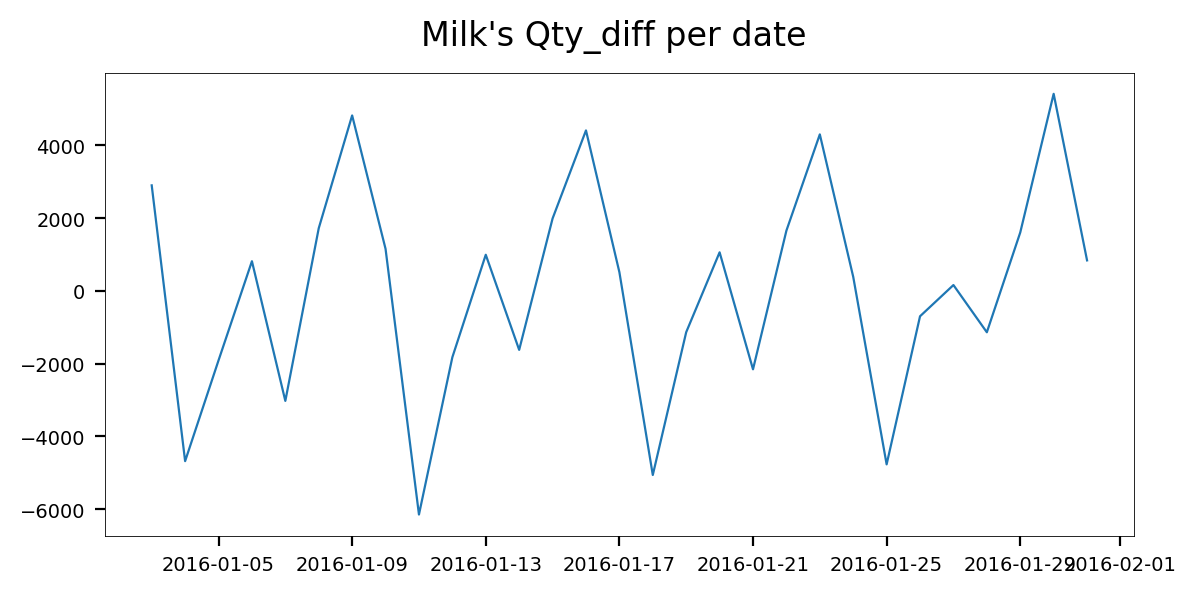

In [84]:
# (추가) 한달내 주기가 있나?
target_store = 44
target_products = [3,7,12]

for t in target_products:
    product_sales_diff_trend(target_store,t,'2016-01-01', '2016-01-31')

# (의견) 음료, 청소, 우유 등은 7주기로 상품 판매량이 변동함 

### 6) 요일별 판매량, 판매 변화량 비교

- 요일별 판매량과 판매 변화량을 막대그래프로 시각화해 비교합니다.
- 요일은 df['Weekday'] = df['Date'].dt.weekday 형태로 얻을 수 있습니다.
- Seaborn의 sns.barplot()을 사용하면 자동 집계되어 시각화되니 편리합니다.
- 우선 사용할 함수를 만듭니다.
- 함수 이름: weekly_sales_diff_trend
- 입력: 매장번호(store_id), 상품번호(product_id), 시작일(sdate), 종료일(edate)

In [86]:

def weekly_sales_diff_trend( store_id, product_id, sdate, edate):
    #대상 상품 판매량 추이
    temp = sales.loc[(sales['store_id']==store_id)&
    (sales['product_id']==product_id)&
    (sales['date'].between(sdate,edate))]

    # 상품 판매 변화량 측정할 열 생성 
    temp['Qty_diff'] = temp['qty'].diff()

    # 요일별로 집계할 수 있도록 요일 열 추가
    temp['Weekday'] = temp['date'].dt.weekday
    

    # 대상 상품과 연관된 상품의 중분류 
    target = products.loc[products['product_id'] ==product_id]['subcategory'].values[0]
    
    # 그래프 시각화
    plt.subplot(2, 1, 1)
    sns.barplot(x='Weekday', y='qty', data=temp)
    plt.title(f'{target}\'s Qty per Weekday ', size=12, pad=10)
    plt.subplot(2, 1, 2)
    sns.barplot(x='Weekday', y='Qty_diff', data=temp)
    plt.title(f'{target} relate products Qty_diff per date ' , size=12, pad=10)
    plt.tight_layout()
    plt.show()

- 위 함수를 사용해 1년간(2016년) 주요 상품의 요일별 판매량과 판매 변화량을 확인합니다.

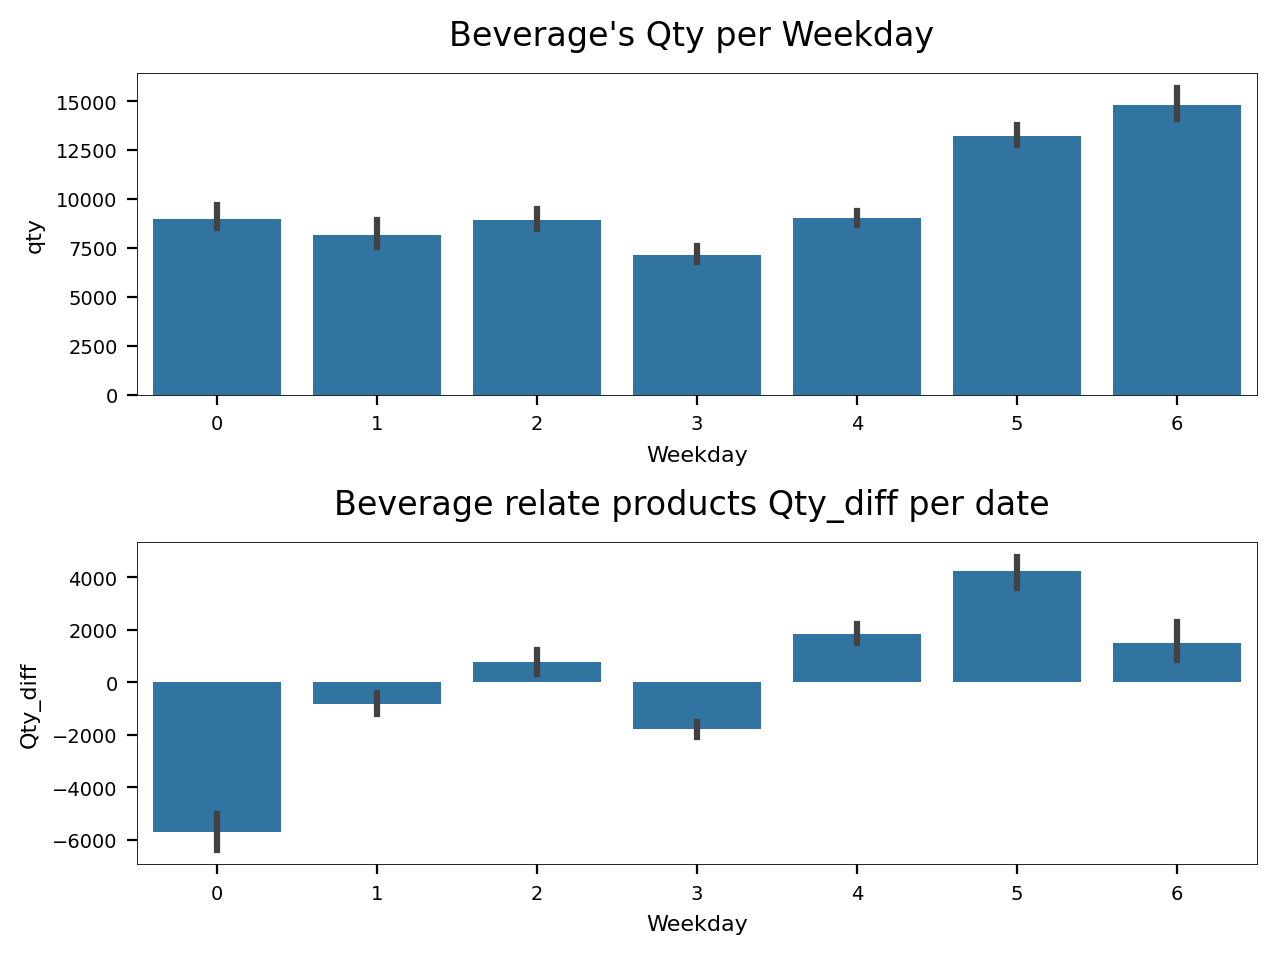

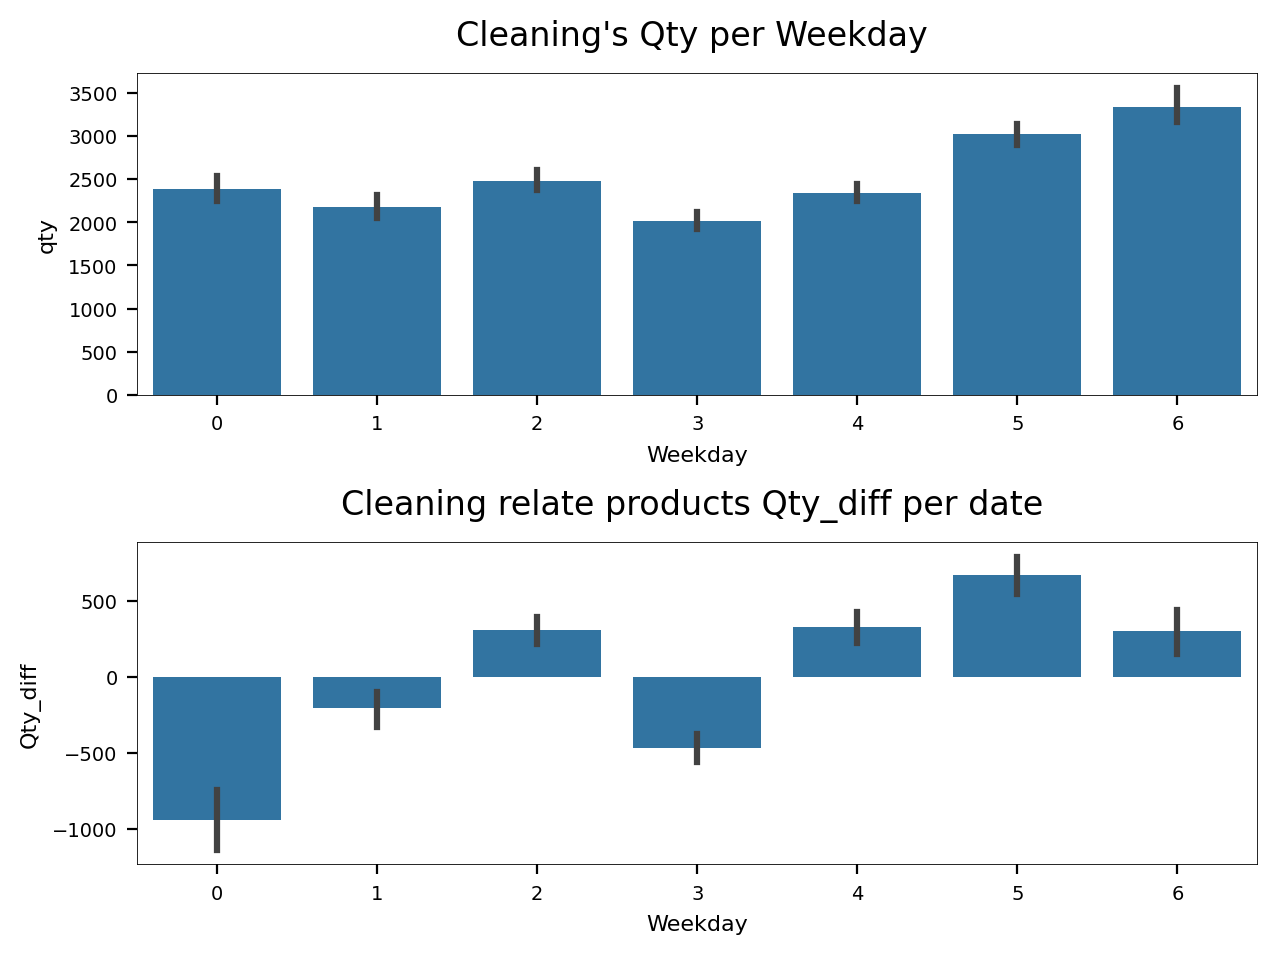

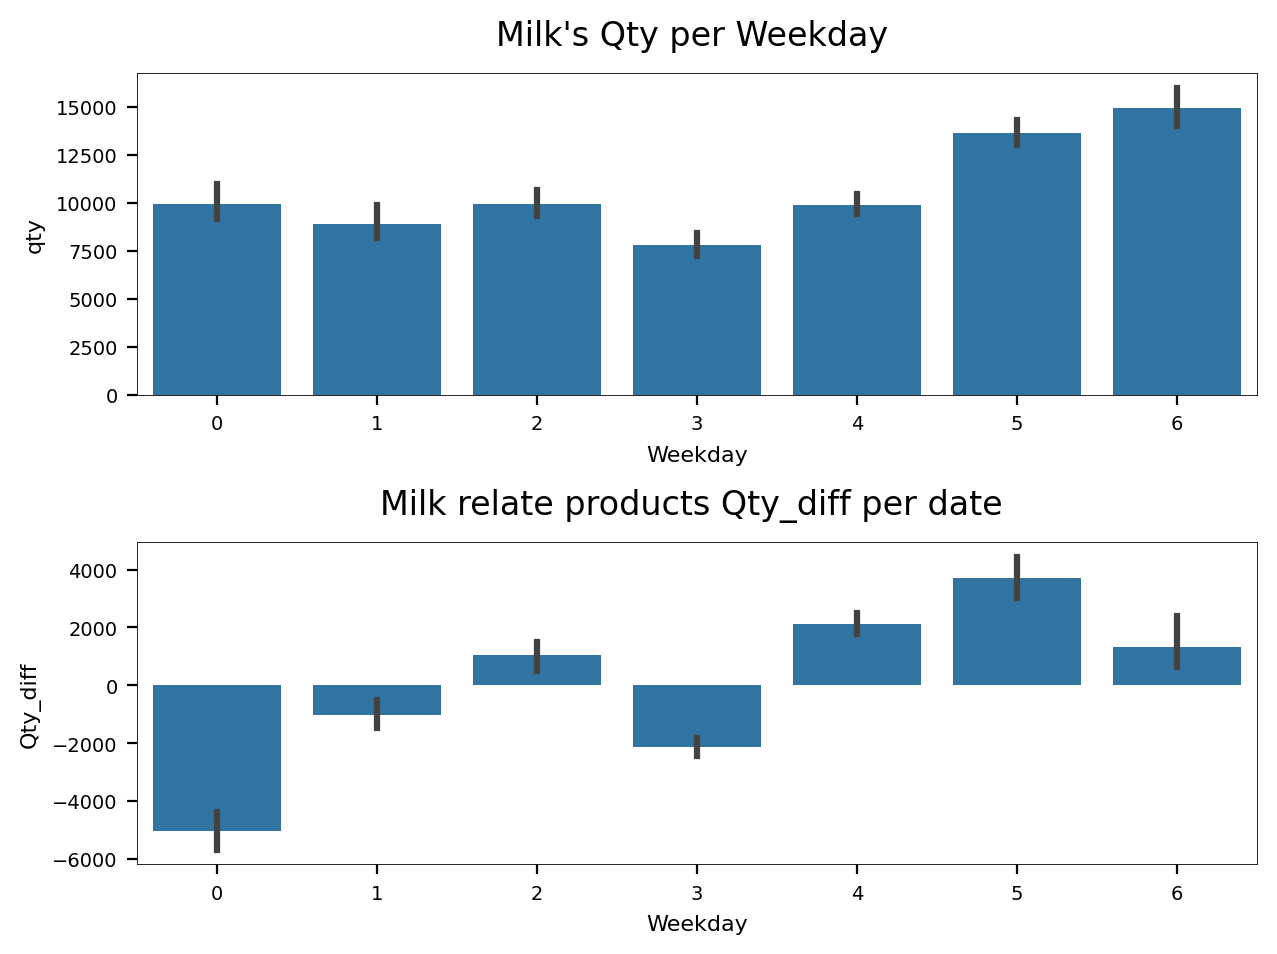

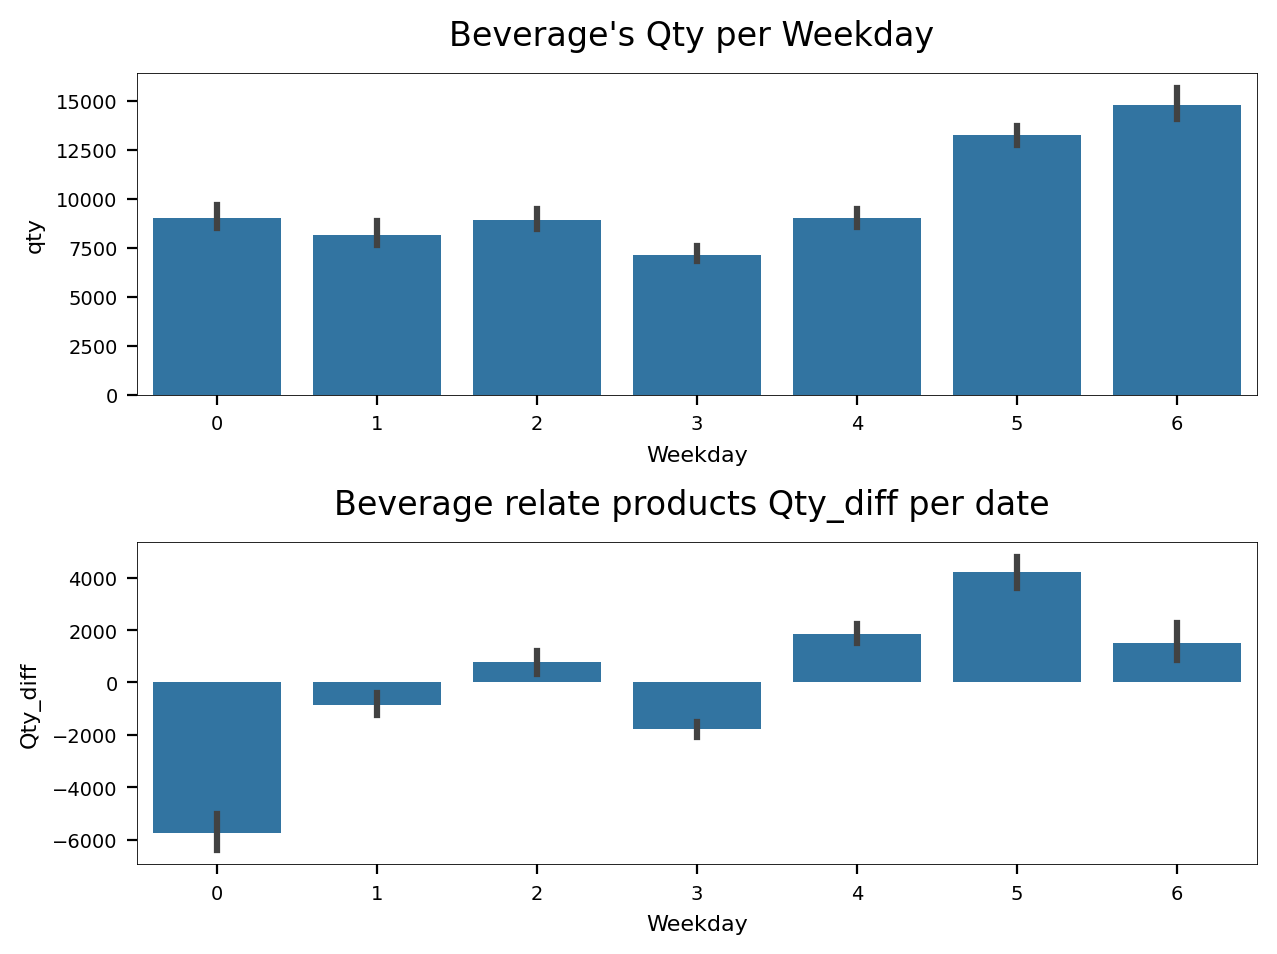

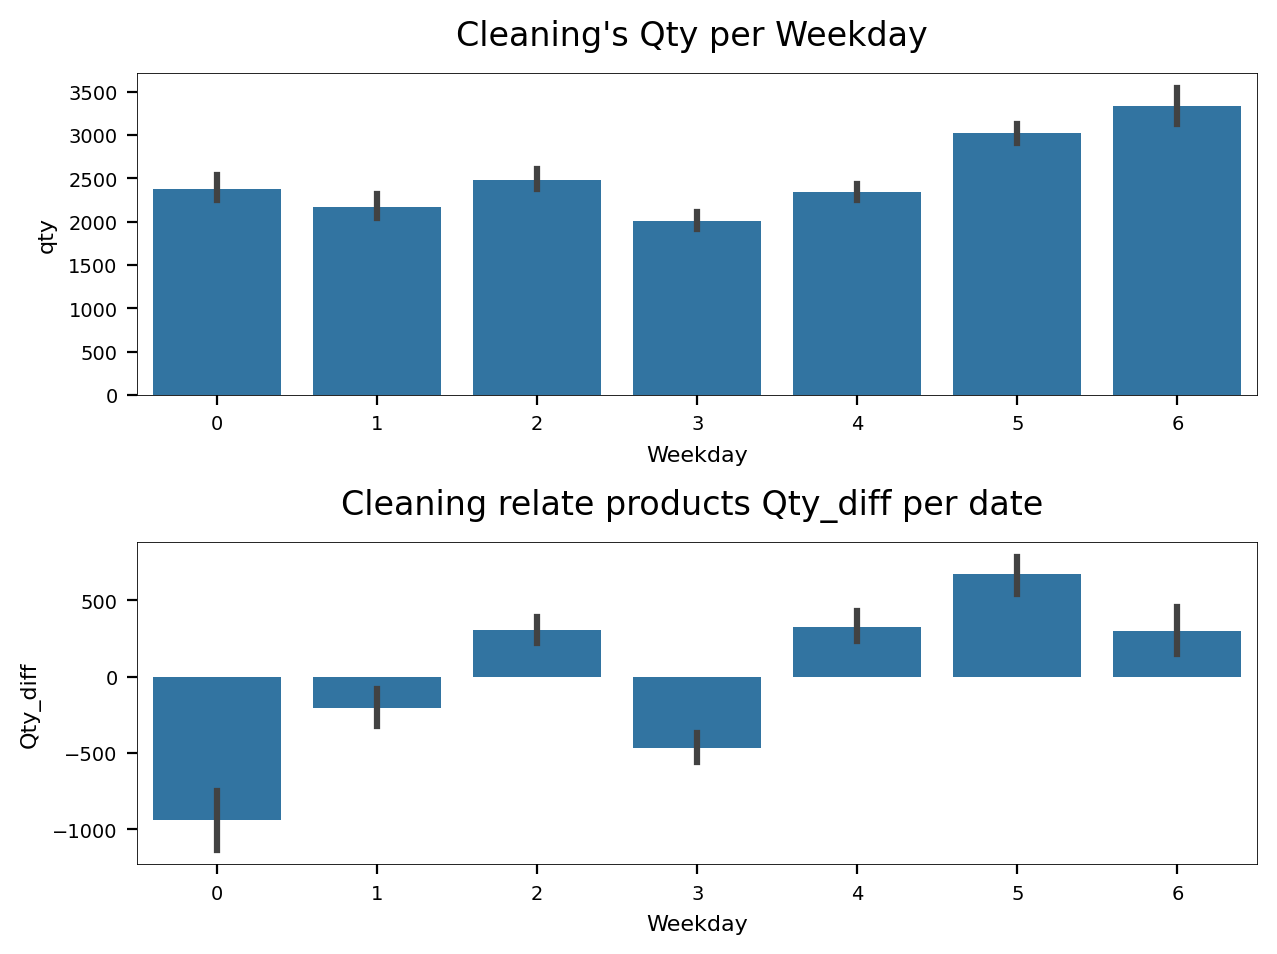

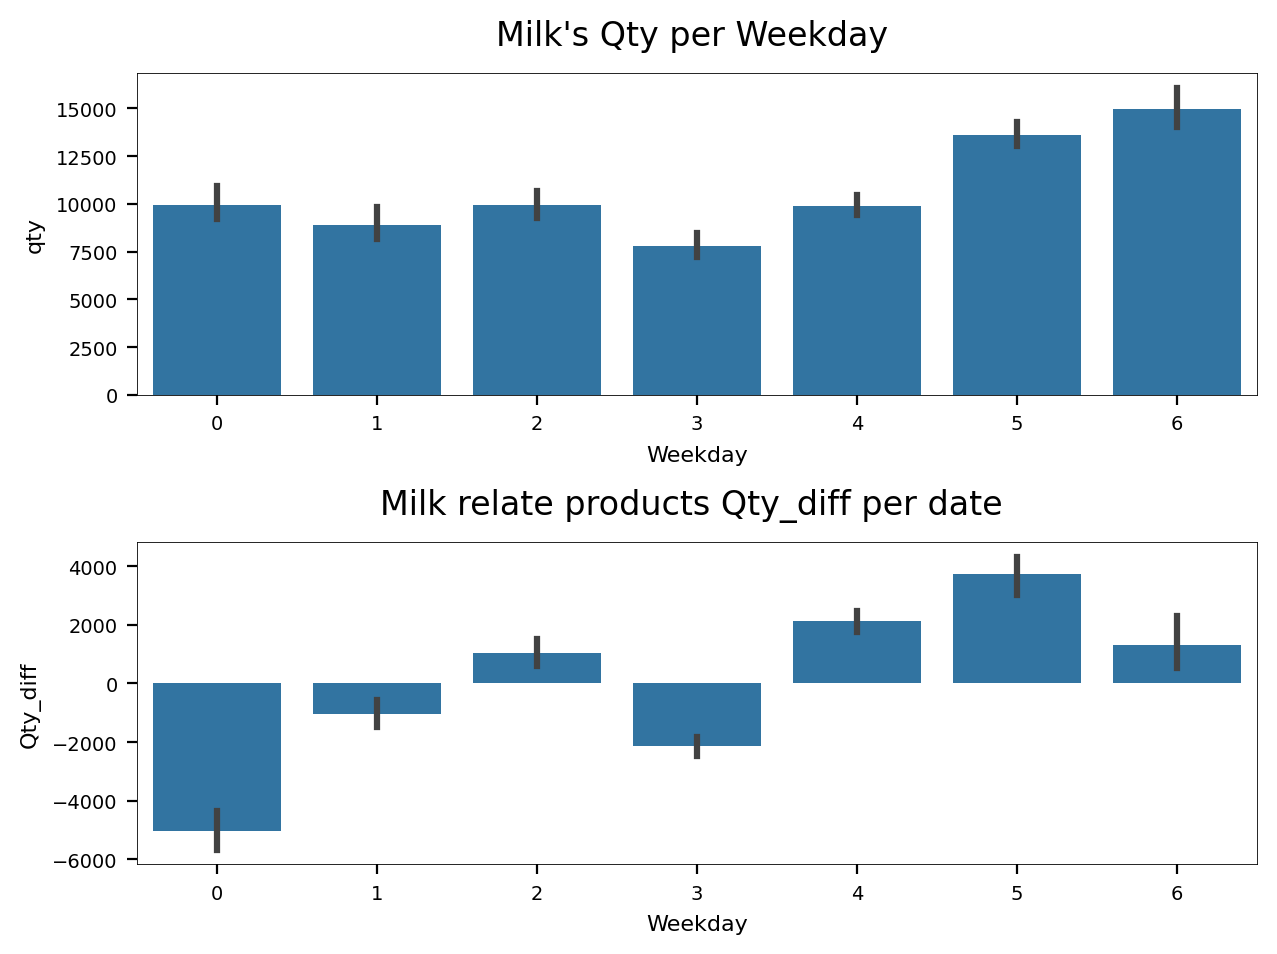

In [88]:
target_store = 44
target_products = [3,7,12]

for t in target_products:
    weekly_sales_diff_trend(target_store,t,'2016-01-01', '2016-12-31')

# 결론 3 7 12 상품은 주말 특ㅎarget_store = 44
target_products = [3,7,12]

for t in target_products:
    weekly_sales_diff_trend(target_store,t,'2016-01-01', '2016-12-31')

# 결론 3 7 12 상품은 주말 (특히 일요일)에 판매량이 증가함

## (4) 시계열 패턴 찾아보기 #2

- 시계열 패턴을 확인하기 위해 추가적인 분석을 진행합니다.

### 1) 시계열 데이터 분해

- 다음과 같은 형태로 시계열 데이터를 분해할 수 있습니다.

~~~
decomp = sm.tsa.seasonal_decompose(temp['변수'], model='additive', period=7)
~~~

- 분해 결과를 decomp 변수에 저장했으면 다음과 같이 데이터프레임을 만들어 시각화 할 수 있습니다.

~~~
result = pd.DataFrame({'observed':decomp.observed,
                       'trend':decomp.trend,
                       'seasonal':decomp.seasonal,
                       'residual':decomp.resid})
~~~

- 우선 사용할 함수를 만듭니다.
- 함수 이름: decomp_plot
- 입력: 매장번호(store_id), 상품번호(product_id), 시작일(sdate), 종료일(edate), 기간(period)

In [91]:
# 함수 만들기
def decomp_plot(store_id, product_id, sdate, edate, period):
    # 시계열 데이터 분해
    temp = sales.loc[(sales['store_id']==store_id) & (sales['product_id']==product_id) & (sales['date'].between(sdate, edate))]
    temp.reset_index(drop=True, inplace=True)
    decomp = sm.tsa.seasonal_decompose(temp['qty'], model='additive', period=period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed,
                          'trend':decomp.trend,
                          'seasonal':decomp.seasonal,
                          'residual':decomp.resid})

    # 4개의 그래프로 나눠서 그리기
    plt.figure(figsize=(12, 6))
    plt.suptitle('Time Series Decomposition', size=15)
   
    # observed
    plt.subplot(4, 1, 1)
    plt.plot(result['observed'], linewidth=0.8)
    plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.title(f'Product: {product_id}, Period: {sdate} ~ {edate}', size=9)
    plt.ylabel('observed')
    # trend
    plt.subplot(4, 1, 2)
    plt.plot(result['trend'], linewidth=0.8)
    plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.ylabel('trend')
    # seasonal
    plt.subplot(4, 1, 3)
    plt.plot(result['seasonal'], linewidth=0.8)
    plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.ylabel('seasonal')
    # residual
    plt.subplot(4, 1, 4)
    plt.plot(result['residual'], linewidth=0.8)
    plt.ylabel('residual')
    plt.tight_layout()
    plt.show()

- 위 함수를 사용해 1년간(2016년) 주요 상품의 시계열 데이터를 분해해 확인합니다.

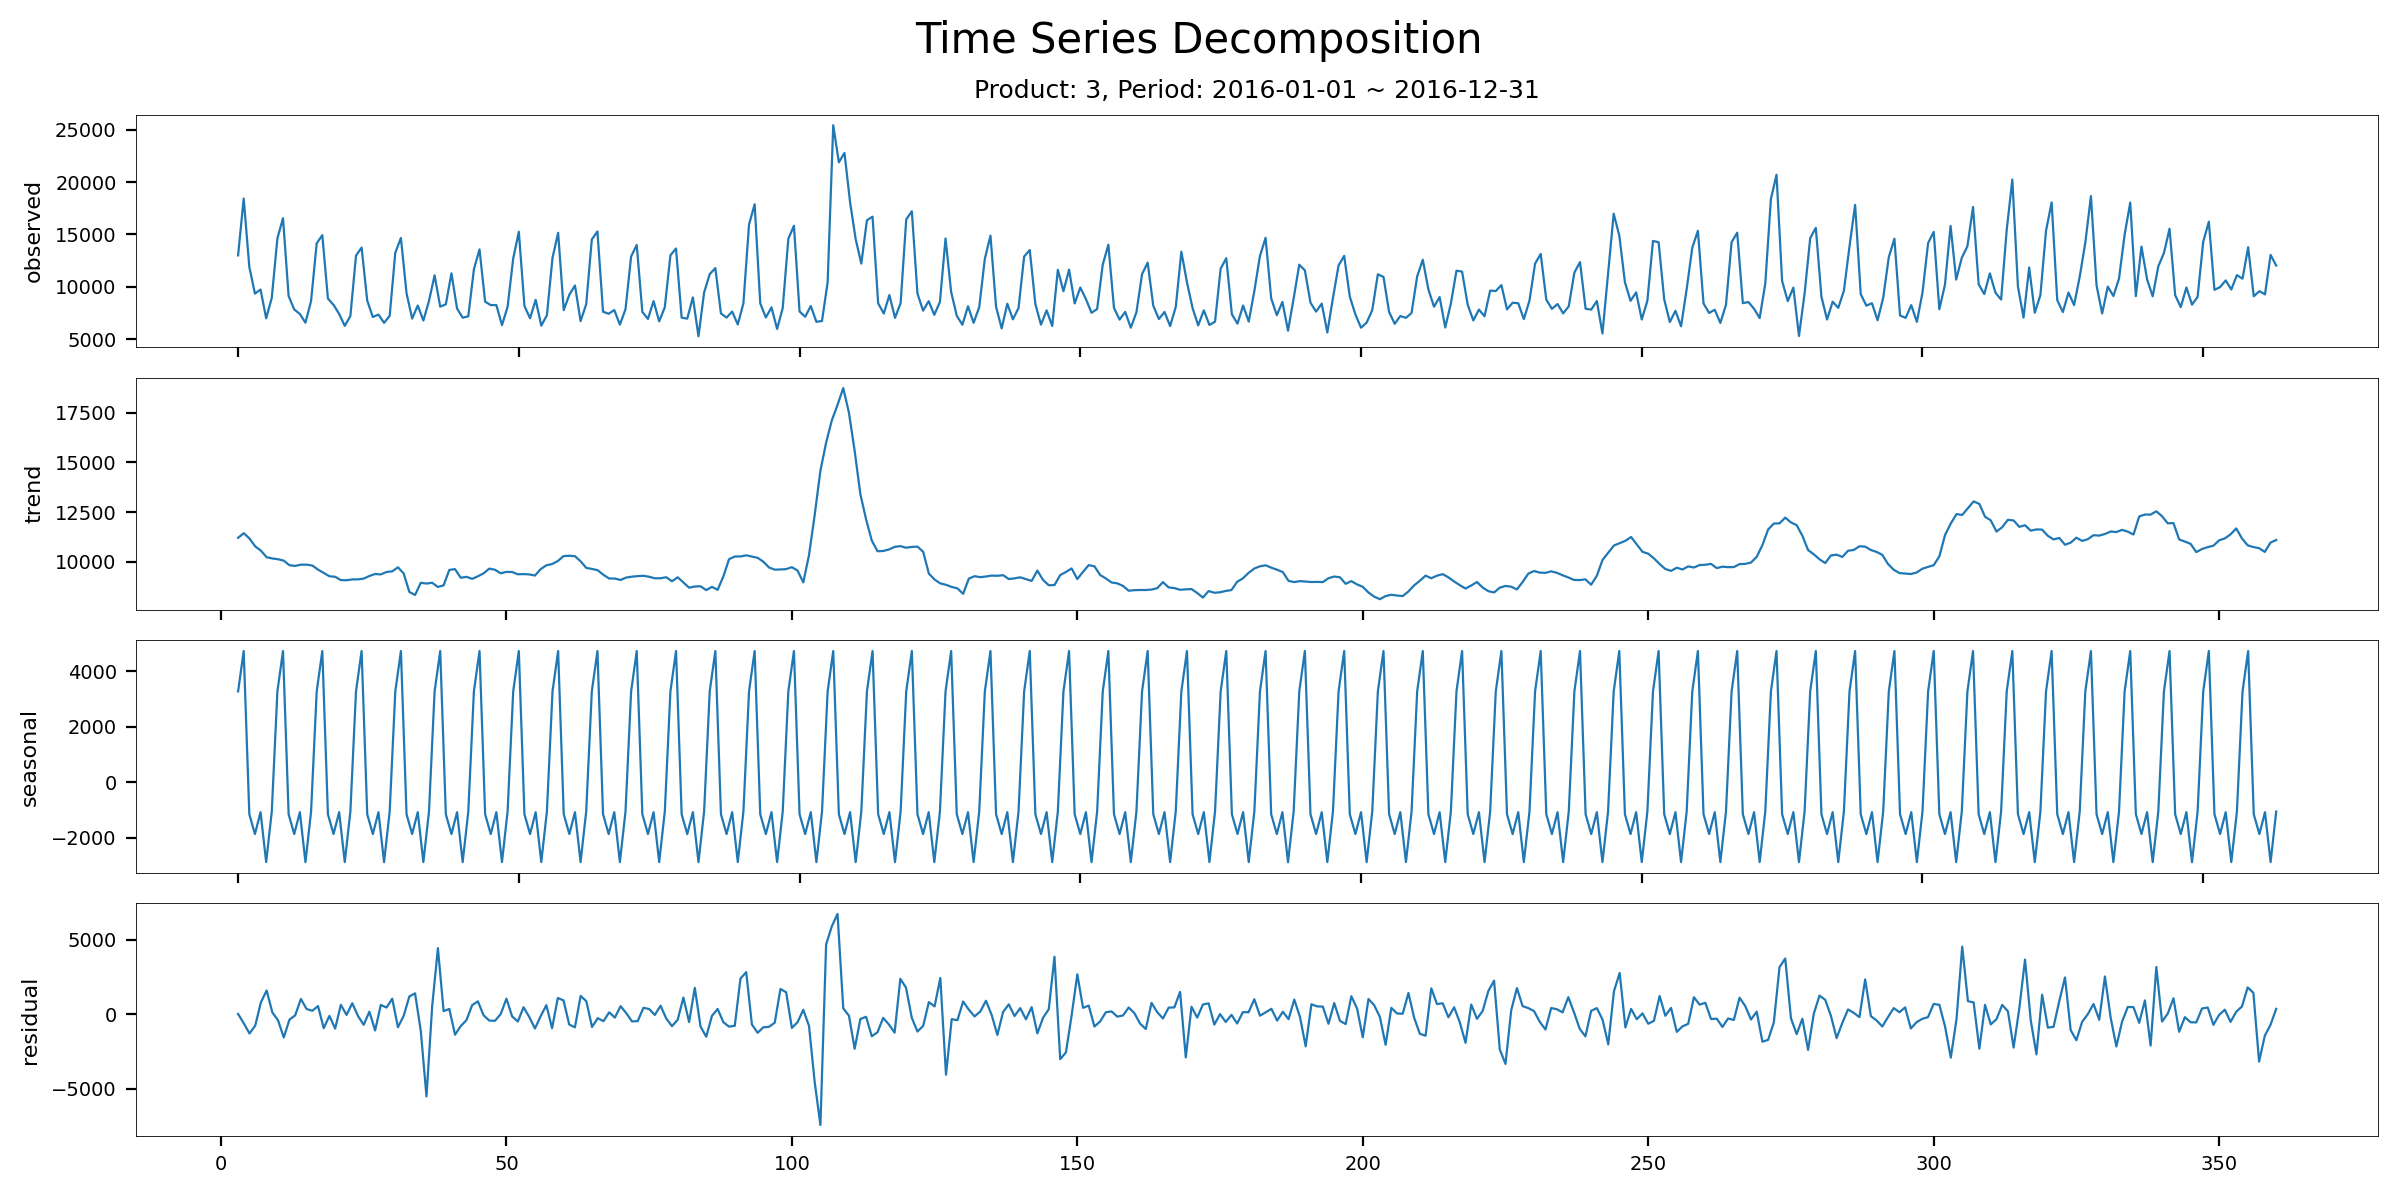

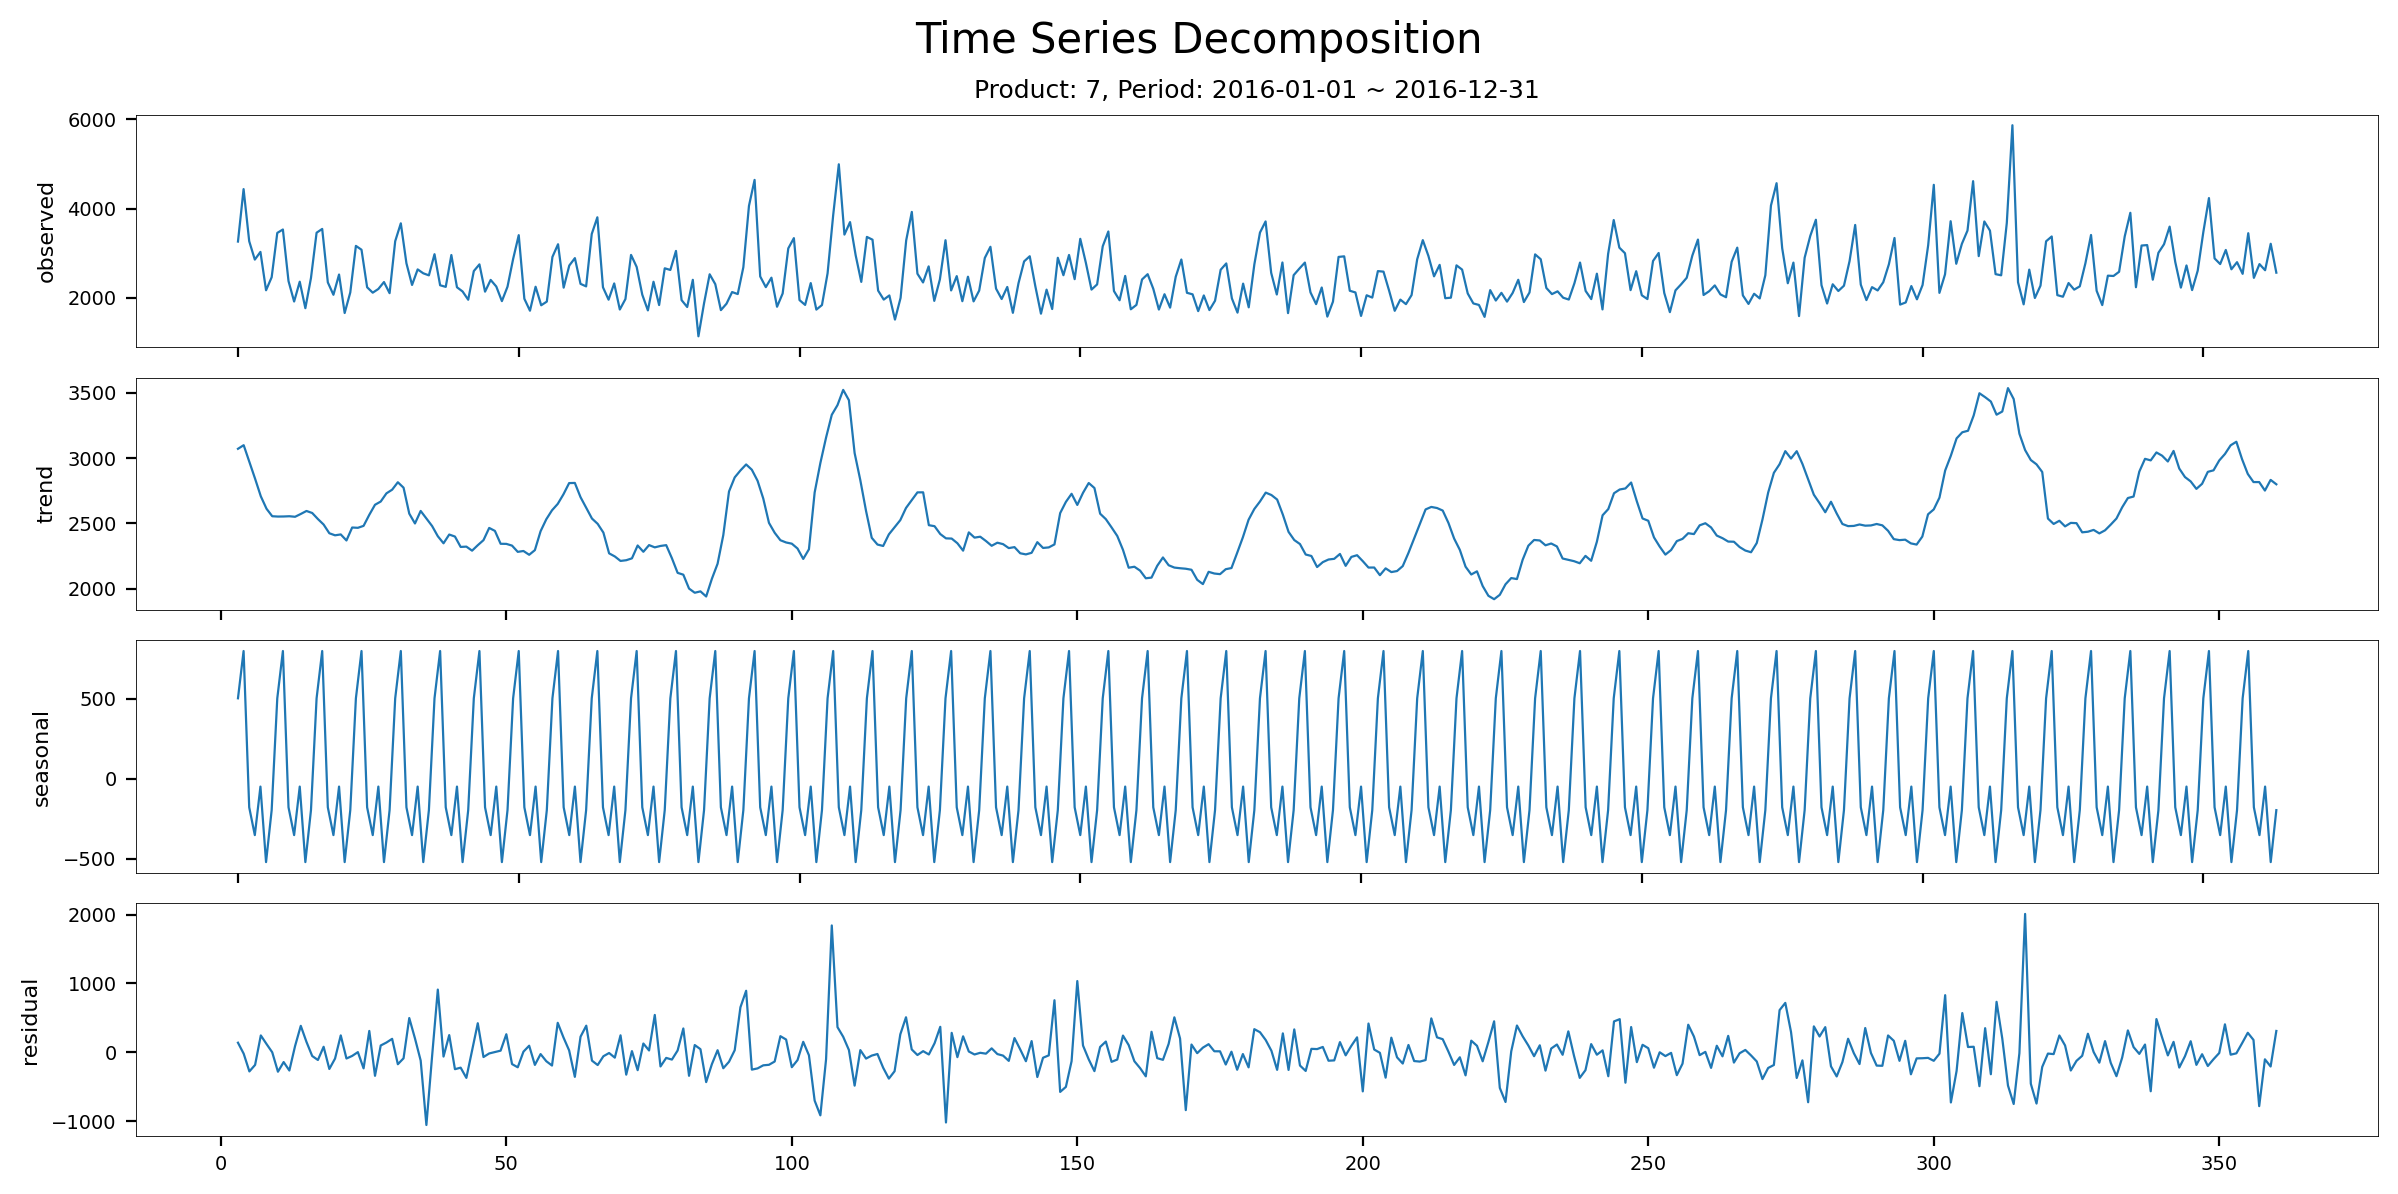

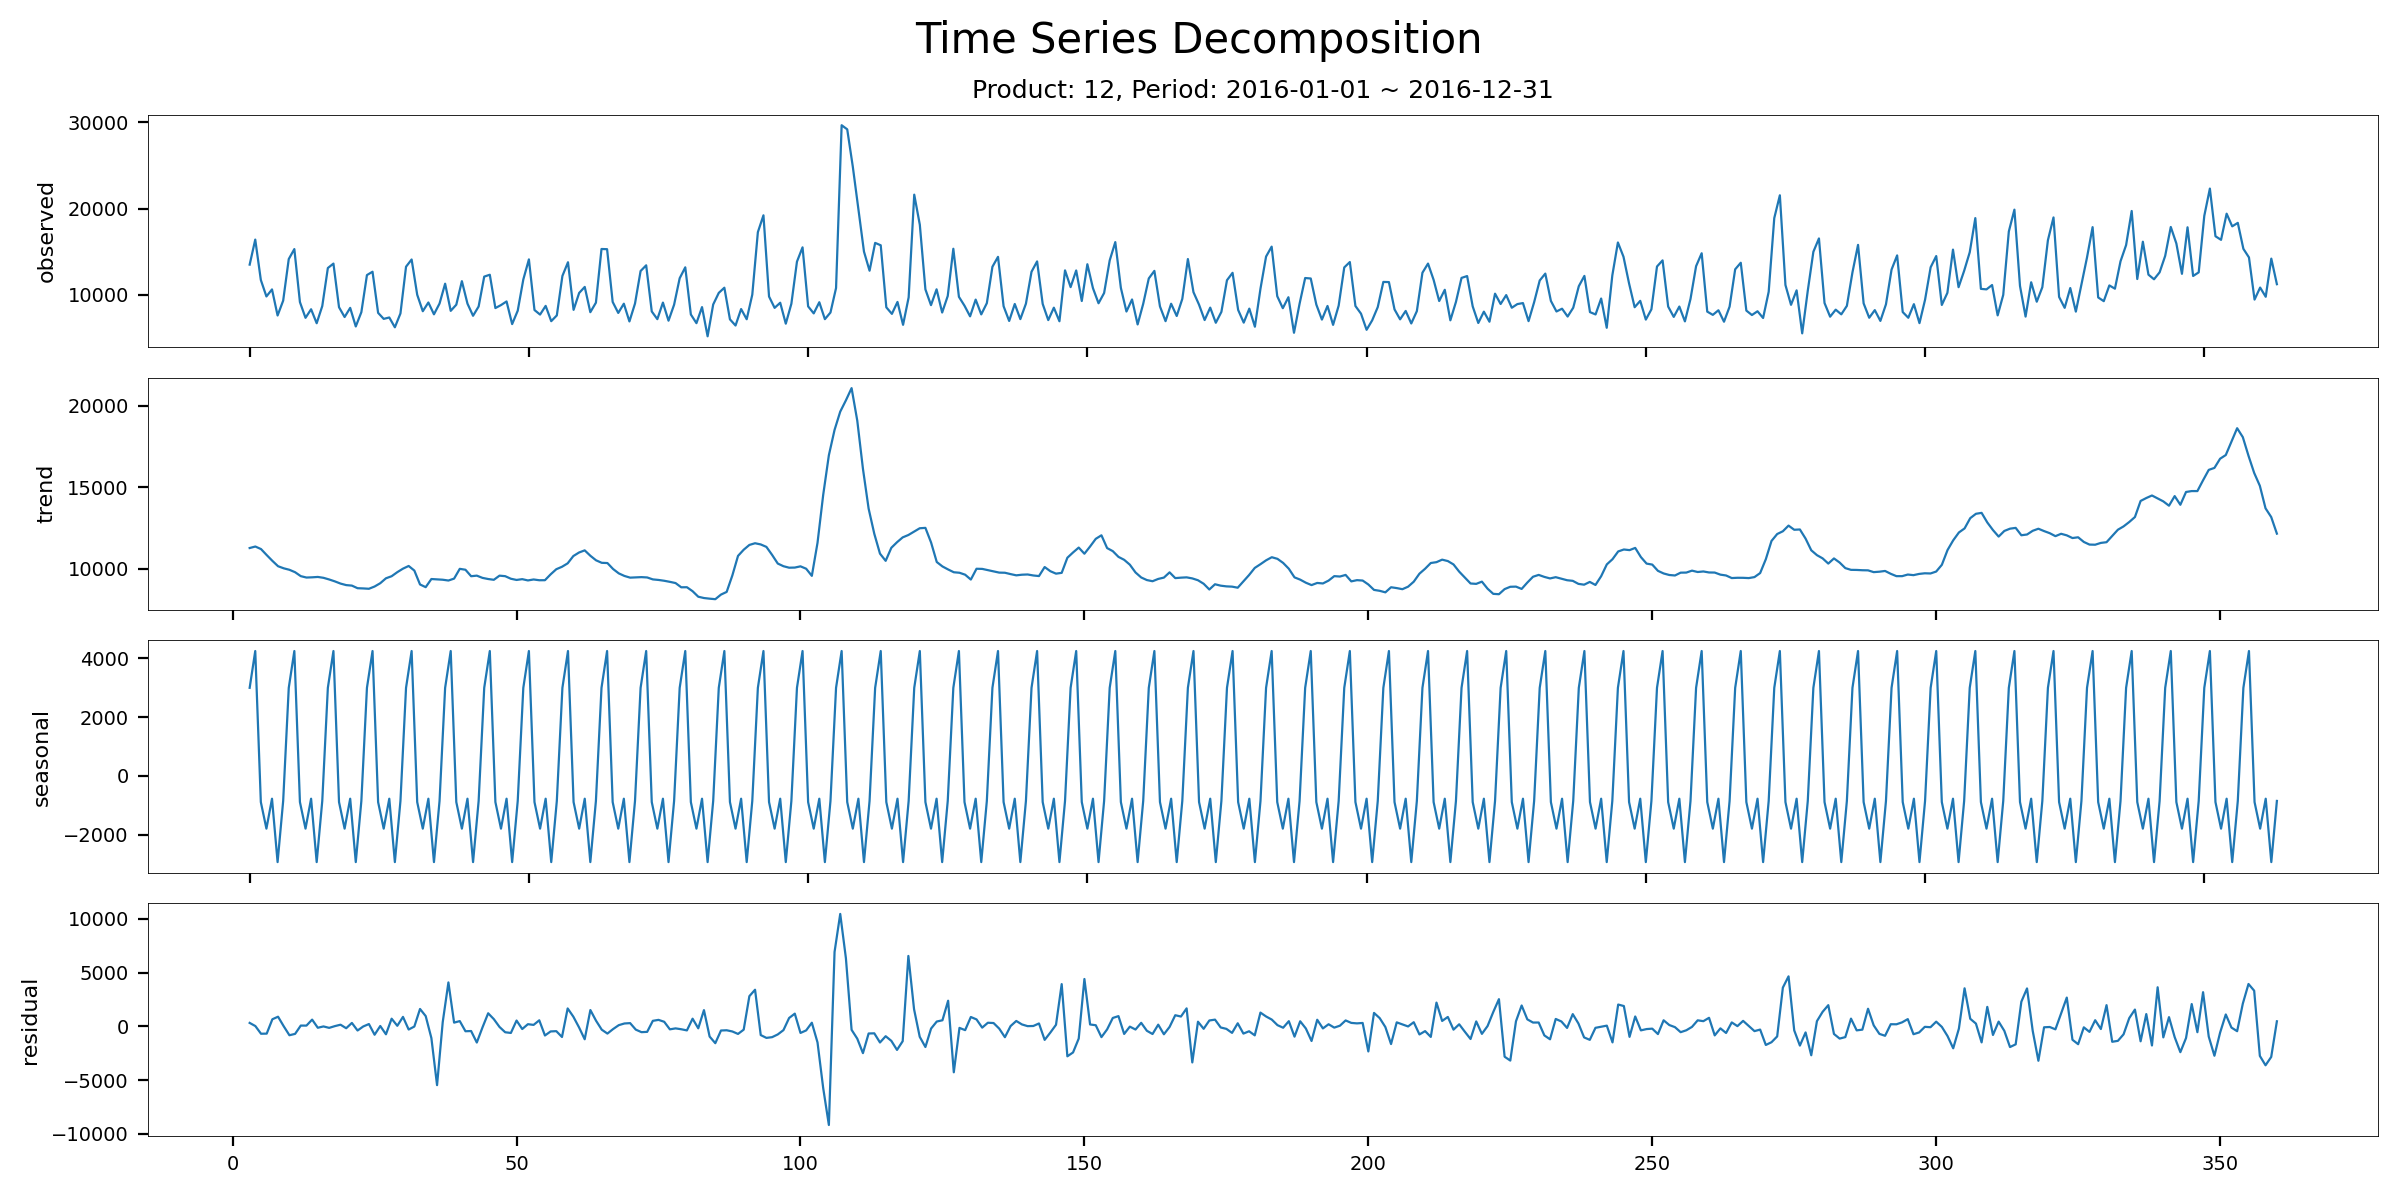

In [93]:
# 2016년 시계열 데이터를 분해
main_product = [3, 7, 12]
for p in main_product:
    decomp_plot(44, p, '2016-01-01', '2016-12-31', 7)

### 2) 자기상관 분석

- 자기상관 분석을 통해 이전 시점의 값과 어떤 관계를 가지는지를 확인합니다.
- 우선 사용할 함수를 만듭니다.
- 함수 이름: auto_correlation
- 입력: 매장번호(store_id), 상품번호(product_id), 시작일(sdate), 종료일(edate), 기간(period)

In [95]:
# 모듈 불러오기
from statsmodels.graphics.tsaplots import plot_acf

# 함수 만들기
def auto_correlation(store_id, product_id, sdate, edate):
    temp = sales.loc[(sales['store_id']==store_id) & (sales['product_id']==product_id) & (sales['date'].between(sdate, edate)), ['qty']]
    fig, ax = plt.subplots(figsize=(12, 3))
    plot_acf(temp['qty'], lags=50, alpha=0.05, ax=ax)
    plt.title('Auto Correlation', size=15, pad=30)
    plt.suptitle(f'Product: {product_id}, Period: {sdate} ~ {edate}', size=9)
    plt.show()

- 위 함수를 사용해 1년간(2016년) 주요 상품의 자기상관 분석을 수행합니다.

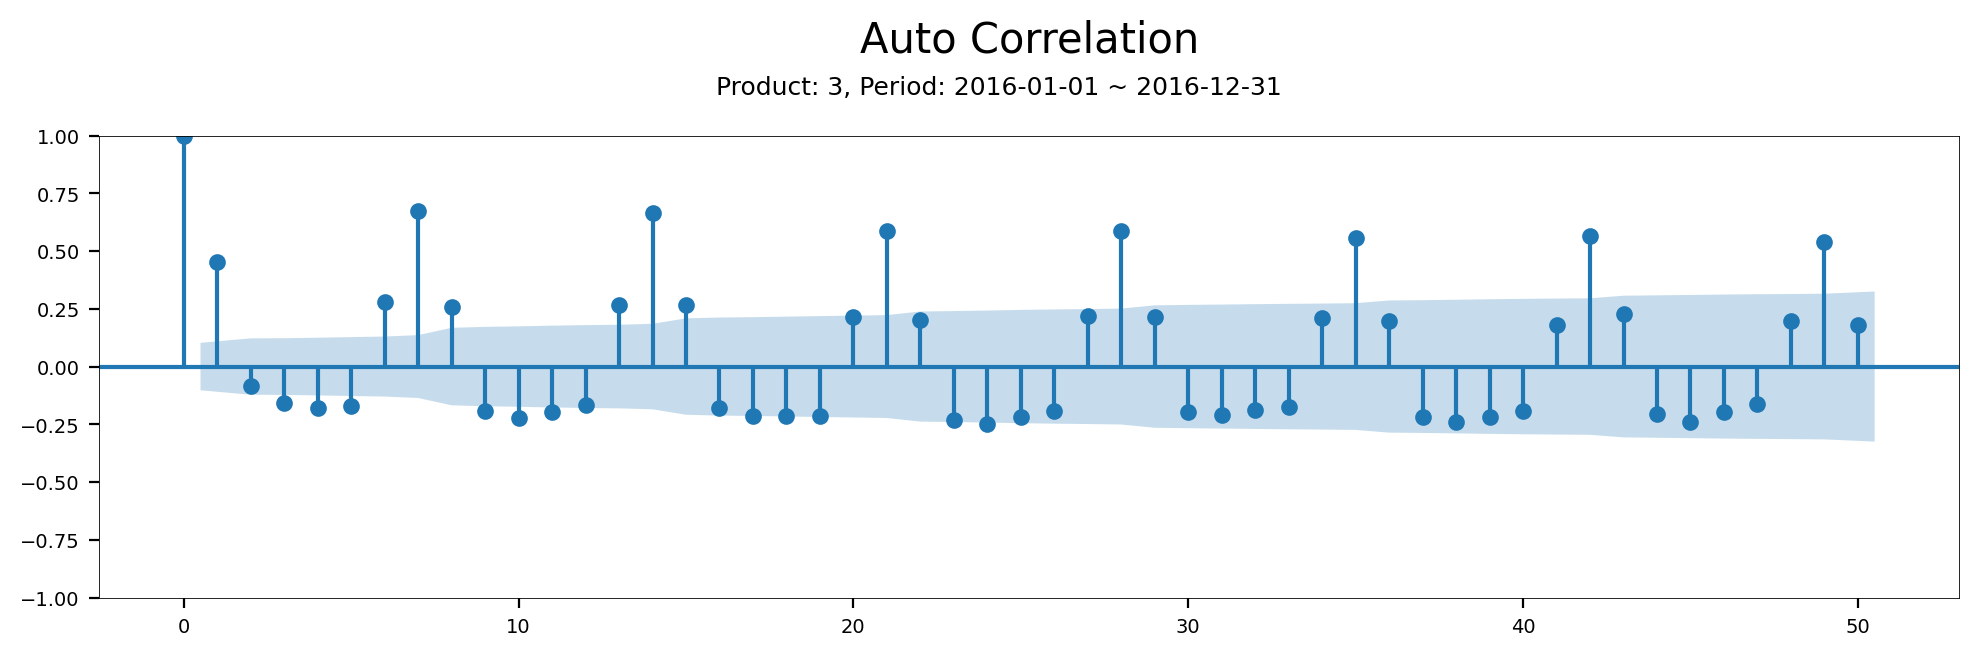

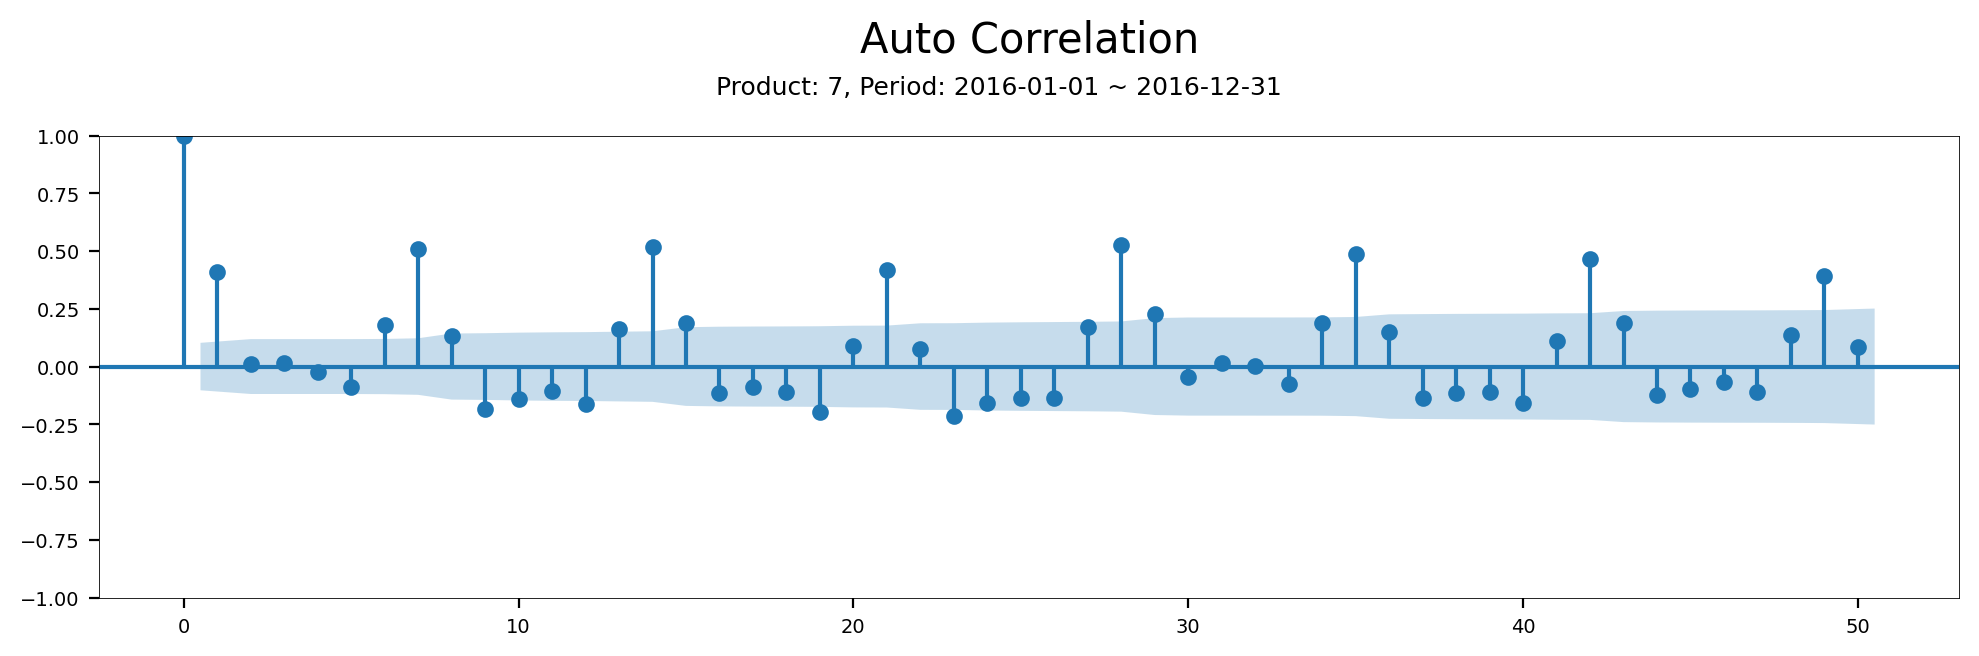

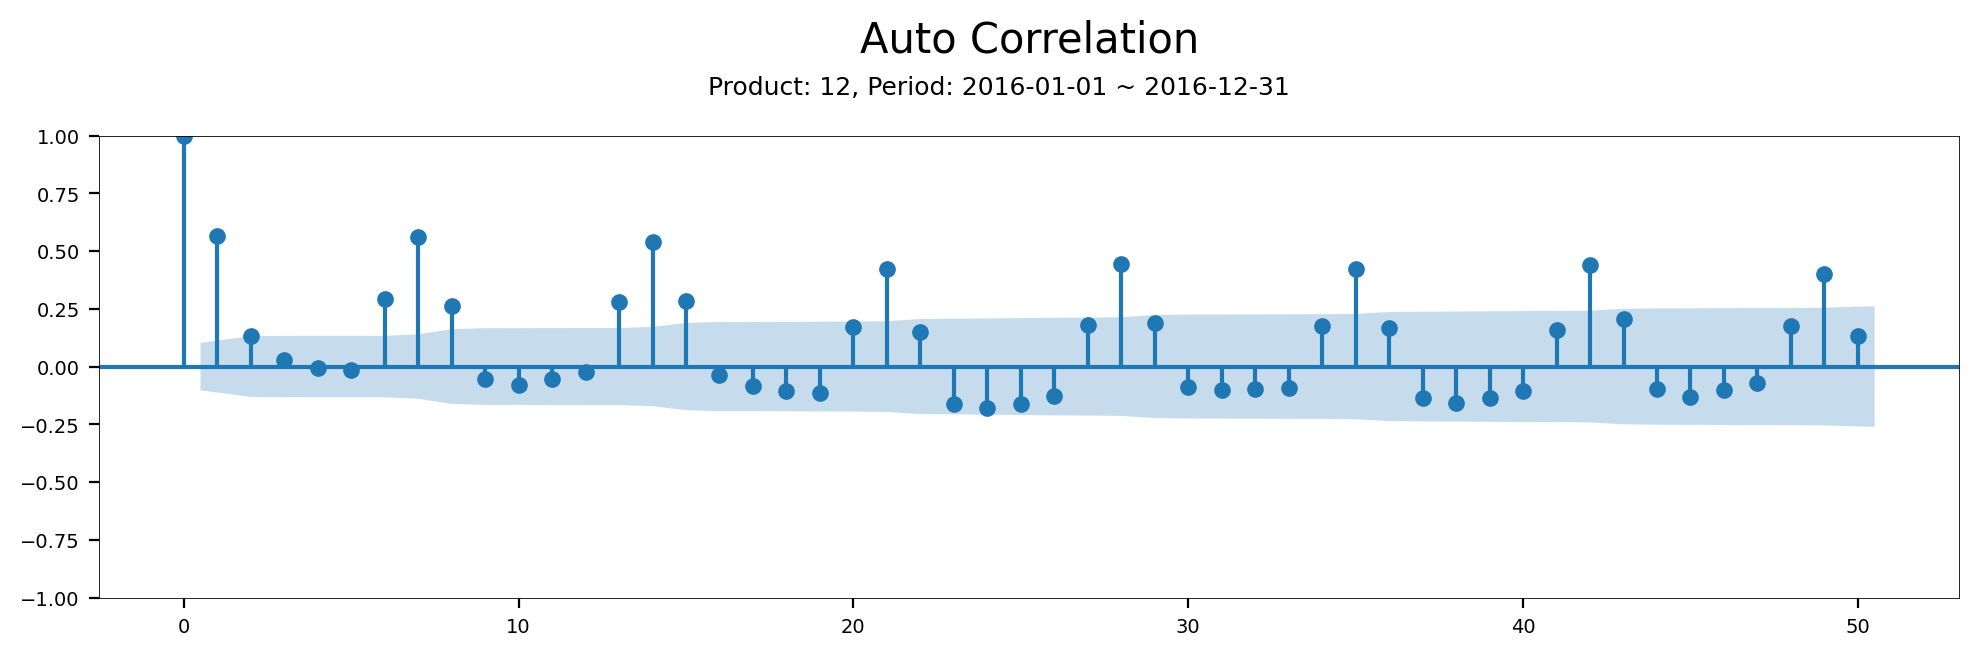

In [97]:
# 2016년 자기상관 분석
main_product = [3, 7, 12]
for p in main_product:
    auto_correlation(44, p, '2016-01-01', '2016-12-31')

## (5) 패턴 정리하기

- 다양한 탐색을 통해 찾은 시계열 패턴을 적어보세요.

In [99]:
# 1. 3 7 12 상품은 일정한 주기성을 띄고있다
# >> 비즈니스 전략을 생각해보자 